# Reduced Order Modelling
## Index
- Element-based Finite Volume Method
- Analytical Solution Validation
- POD / SVD Decompositions
- ROM Solution of the same problem
- ROM Solution of a different problem

## Element-based Finite Volume Method
In this section we are going to derive the equations used in the EbFVM method to solve numerically PDEs in unstructured meshes.

### Systems and Control Volumes
In thermal sciences, in special the ones that apply the continuum mechanics, it's common to apply conservation equations formulated in the context of closed systems to control volumes, in such a way that we can compute the flux of certain properties at the control surfaces in order to guarantee the conservation equations. To that purpose, the Element-based Finite Volumes method uses shape functions and elements in order to interpolate fields and gradients inside elements.

Examples of conservation equations for systems are

$$
\begin{array}{ c c l }
\text{Conservation of mass} & \displaystyle{\frac{dm}{dt} =0} & \begin{array}{ c l } m & \text{mass} \end{array}\\
\hline
\begin{array}{ c } \text{Newton's second law / }\\ \text{Conservation of momentum} \end{array} & 
\displaystyle{\mathbf{F}_{R} =\frac{\partial }{\partial t}( m\mathbf{v})} & 
\begin{array}{ c l } m & \text{mass}\\ \mathbf{v} & \text{velocity}\\ \mathbf{F}_{R} & \text{Net force} \end{array}\\
\hline
\begin{array}{ c } \text{First law of thermodynamics /}\\ \text{Conservation of energy} \end{array} & 
\Delta U=Q-W & \begin{array}{ c l } U & \text{Internal Energy}\\ Q & \text{Heat entering the system}\\ W & \text{Work done by the system} \end{array}
\end{array}
$$

The main way system equations are expressed using control volumes is through Gauss's divergence theorem, which states that for a vector field $\mathbf{F}(\mathbf{r})$, a generic volume $\Omega$ and its boundary $\Gamma = \partial \Omega$ we have the relation

$$\displaystyle{\iiint \limits _\Omega \nabla \cdot \mathbf{F}\ d\Omega} = \displaystyle{\iint \limits _\Gamma \mathbf{F} \cdot \mathbf{\hat{n}}\ d\Gamma}$$

In fluid domains it is common to use the Reynolds transport theorem, which states

$$\frac{dN}{dt}\bigg|_{sys} =\frac{\partial }{\partial t}\displaystyle{\iiint\limits _{\Omega} {\eta \rho\ d\Omega}} + \displaystyle{\iint\limits _{\Gamma} \eta \rho\ \mathbf{v} \cdotp \mathbf{\hat{n}}\ d\Gamma}$$

Where $N$ is an extensive property and $\eta = \frac{N}{m}$, and $m$ is the mass

### Elements and Control Volumes

Since the EbFVM deals with conservation equations, where the flux of properties are of intrest, and also evaluating them at the boundaries of the control volumes, we are going to create a mesh defined by elements, and from them create the control volumes, in such a way that the boundaries of the control volumes are inside the elements. Here is a short description of each geometrical entity.

- **Control volume**: For each control volume one or more conservation equation(s) will be solved. They are created using the elements and vertices.
- **Element**: The mesh is created using elements, which are defined by a set of vertices. Elements can be triangles and quadrilaterals in 2D simulations, or tetrahedrons, hexahedrons, triangular prisms and quadrilateral pyramids in 3D simulations.
- **Subelement**: Each element is subdivided into subelements, in order to create the control volumes. The faces dividing the element into subelements are called **inner faces**, and they compose the control surface of each control volume.
- **Vertex**: Each control volume is centered arround a vertex, which is itself a vertex of one or more elements. For each element that a vertex defines, there will be one subelement to compose the control volume.
- **Nodes**: The nodes are where the variables are stored. In a cell-vertex collocated grid using first order elements, the nodes coincide with the vertices, but depending on the arrangement of the method they can differ.
- **Mesh**: The mesh is the set of all other geometric entities, and in the EbFVM it can be easily visualized only from the elements, since most other entities come from them.
- **Regions**: Regions are groups of elements who share the same properties. The purpose of dividing the elements into regions, is that because different subelements compose the same control volume, one can assign different properties for each element.
- **Boundary**: The boundaries are groups of external faces on which different boundary conditions will be applied. They're composed of facets and outer faces.
- **Facet**: Facets are the faces of the elements that are connected only to external vertices, and during the division of the element into subelements, they also get divided into outer faces, which are the entities upon which Neumann boundary conditions are applied.

### Shape Functions
We have already shown that we care about fluxes of properties flowing through inner faces, and for such, we want to interpolate fields and gradients at the boundary of the control volumes, which we also have shown that lies inside the element. Since we have to deal with all sorts of elements in all sorts of configurations, it's easier to work with *standard* elements, meaning they have known vertex locations, and for that we create local coordinates for each element.

Suppose an element has its vertices at the locations $\mathbf{\hat{r}}_1=(\hat{x}_1,\hat{y}_1,\hat{z}_1), \dots, \mathbf{\hat{r}}_N=(\hat{x}_N,\hat{y}_N,\hat{z}_N)$, where $N$ is the number of vertices of the element. Then we say this element has local coordinates $\mathfrak{r}=(\xi, \eta, \zeta)$, for which the vertex locations are pre-determined. For example, the tetrahedron's vertices would have local coordinates $(0,0,0),\ (1,0,0),\ (0,1,0),\ (0,0,1)$, and the transformation of coordinates is made using shape functions, such that

$$x(\mathfrak{r}) =\sum \limits_{k=1}^{N}\mathcal{N}_{k}(\mathfrak{r})\hat{x}_{k}$$

Where $\mathcal{N}_k(\mathfrak{r})$ is the shape function of the vertex $k$, and $\mathbf{\hat{r}}_k=(\hat{x}_k,\hat{y}_k,\hat{z}_k)$ are its coordinates.

There are restrictions that the shape functions should follow, for example

$$\begin{array}{ c c|c c }
\mathcal{N}_{k}(\mathfrak{r})=\begin{cases}
1 & \text{if} \ \mathfrak{r} =\mathfrak{\hat{r}}_k\\
0 & \text{if} \ \mathfrak{r} =\mathfrak{\hat{r}}_i \ \text{and} \ i\neq k
\end{cases} &  &  & \sum \limits_{k=1}^{N}\mathcal{N}_{k}(\mathfrak{r}) =1,\ \forall \mathfrak{r} \in \mathbb{R}^{3}
\end{array}$$

Where $\mathbf{r}$ represents a global coordinate $(x,y,z)$, and $\mathfrak{r}$ represents a local coordinate $(\xi,\eta,\zeta)$. 

Besides interpolating the vertex coordinates, the shape functions can also be used to interpolate variables inside the element using the variables at the vertices. If for example there is a field $u(\mathbf{r})$ for which we know the values at the vertices of an element, namely $\hat{u}_1 = u(\mathbf{\hat{r}}_1),\ \hat{u}_2 = u(\mathbf{\hat{r}}_2), \dots, \hat{u}_N = u(\mathbf{\hat{r}}_N)$, we can interpolate the value of $u(\mathfrak{r})$ for any $\mathfrak{r}$ inside the element using the relation
$$u(\mathfrak{r}) \approx \sum \limits_{k=1}^{N}\mathcal{N}_{k}(\mathfrak{r})\ \hat{u}_{k}$$

The fact that we aren't expressing $u(\mathbf{r})$, but rather $u(\mathfrak{r})$ isn't necessarily a problem, since we want to interpolate variables in known locations of our element, for example in the inner faces. Since we have a field interpolation of $u(\mathfrak{r})$, the next logical step is to compute its gradient.

Notice that 
$$\partial_x u(\mathfrak{r}) \approx \sum \limits_{k=1}^{N} \partial_x \mathcal{N}_{k}(\mathfrak{r})\ \hat{u}_{k}$$

And once we have our shape functions it's easy to find $\frac{\partial\mathcal{N}_k}{\partial\xi}$, $\frac{\partial\mathcal{N}_k}{\partial\eta}$ and $\frac{\partial\mathcal{N}_k}{\partial\zeta}$, but finding $\frac{\partial\mathcal{N}_k}{\partial x}$, $\frac{\partial\mathcal{N}_k}{\partial y}$ and $\frac{\partial\mathcal{N}_k}{\partial z}$ is a more convoluted problem.

We can make use of the chain rule, which states that
$$
\begin{cases}
\partial _{\xi }\mathcal{N}_k(\mathfrak{r}) =\partial _{x}\mathcal{N}_k(\mathfrak{r}) \ \partial _{\xi } x+\partial _{y}\mathcal{N}_k(\mathfrak{r}) \ \partial _{\xi } y+\partial _{z}\mathcal{N}_k(\mathfrak{r}) \ \partial _{\xi } z\\
\partial _{\eta }\mathcal{N}_k(\mathfrak{r}) =\partial _{x}\mathcal{N}_k(\mathfrak{r}) \ \partial _{\eta } x+\partial _{y}\mathcal{N}_k(\mathfrak{r}) \ \partial _{\eta } y+\partial _{z}\mathcal{N}_k(\mathfrak{r}) \ \partial _{\eta } z\\
\partial _{\zeta }\mathcal{N}_k(\mathfrak{r}) =\partial _{x}\mathcal{N}_k(\mathfrak{r}) \ \partial _{\zeta } x+\partial _{y}\mathcal{N}_k(\mathfrak{r}) \ \partial _{\zeta } y+\partial _{z}\mathcal{N}_k(\mathfrak{r}) \ \partial _{\zeta } z
\end{cases}\\
$$

Or expressing it in the matrix form
$$
\begin{bmatrix}
\partial _{\xi }\mathcal{N}_k\\
\partial _{\eta }\mathcal{N}_k\\
\partial _{\zeta }\mathcal{N}_k
\end{bmatrix}(\mathfrak{r}) =\underbrace{\begin{bmatrix}
\partial _{\xi } x & \partial _{\xi } y & \partial _{\xi } z\\
\partial _{\eta } x & \partial _{\eta } y & \partial _{\eta } z\\
\partial _{\zeta } x & \partial _{\zeta } y & \partial _{\zeta } z
\end{bmatrix}}_{\mathbf{J}^{T}}\begin{bmatrix}
\partial _{x}\mathcal{N}_k\\
\partial _{y}\mathcal{N}_k\\
\partial _{z}\mathcal{N}_k
\end{bmatrix}(\mathfrak{r})$$

And therefore we can find the global derivatives of our shape functions

$$\begin{bmatrix}
\partial _{x}\mathcal{N}\\
\partial _{y}\mathcal{N}\\
\partial _{z}\mathcal{N}
\end{bmatrix}(\mathfrak{r}) =\left(\mathbf{J}^{T}\right)^{-1}\begin{bmatrix}
\partial _{\xi }\mathcal{N}\\
\partial _{\eta }\mathcal{N}\\
\partial _{\zeta }\mathcal{N}
\end{bmatrix}(\mathfrak{r})$$

Where we find the transposed jacobian of our transformation. The Jacobian can also be expressed using the rules for interpolating $\mathbf{r} = (x,y,z)$ by using the relation

$$
\partial _{\xi } x(\mathfrak{r}) =\sum\limits _{k=1}^{N} \partial _{\xi }\mathcal{N}_{k}(\mathfrak{r}) \ \hat{x}_{k}\\
\mathbf{J} =\begin{bmatrix}
\partial _{\xi } x & \partial _{\eta } x & \partial _{\zeta } x\\
\partial _{\xi } y & \partial _{\eta } y & \partial _{\zeta } y\\
\partial _{\xi } z & \partial _{\eta } z & \partial _{\zeta } z
\end{bmatrix} =\underbrace{\begin{bmatrix}
\hat{x}_{1} & \dotsc  & \hat{x}_{N}\\
\hat{y}_{1} & \dotsc  & \hat{y}_{N}\\
\hat{z}_{1} & \dotsc  & \hat{z}_{N}
\end{bmatrix}}_{\mathbf{C}^T}\underbrace{\begin{bmatrix}
\partial _{\xi }\mathcal{N}_{1} & \partial _{\eta }\mathcal{N}_{1} & \partial _{\zeta }\mathcal{N}_{1}\\
\vdots  & \vdots  & \vdots \\
\partial _{\xi }\mathcal{N}_{N} & \partial _{\eta }\mathcal{N}_{N} & \partial _{\zeta }\mathcal{N}_{N}
\end{bmatrix}}_{\mathbf{D}_\mathfrak{r}} = \mathbf{C}^T\mathbf{D}_\mathfrak{r}
$$

And for our simulation we'll know the local derivatives at the point of intrest, as well as the element vertices coordinates, and thus we can calculate global derivatives in any part of the interior of the element. Just to wrap everything up, we can actually compute the gradient of the field $u(\mathbf{r})$

$$\mathbf{\nabla } u=\begin{bmatrix}
\partial _{x} u\\
\partial _{y} u\\
\partial _{z} u
\end{bmatrix} \approx \left(\mathbf{D}_{\mathfrak{r}}^{T}\mathbf{C}\right)^{-1}\sum\limits _{k=1}^{N}{\textstyle \begin{bmatrix}
\partial _{\xi }\mathcal{N}_{k}(\mathfrak{r})\\
\partial _{\eta }\mathcal{N}_{k}(\mathfrak{r})\\
\partial _{\zeta }\mathcal{N}_{k}(\mathfrak{r})
\end{bmatrix}\hat{u}_{k}}\\
\mathbf{\nabla } u \approx \left(\mathbf{D}_{\mathfrak{r}}^{T}\mathbf{C}\right)^{-1}\underbrace{{\textstyle \begin{bmatrix}
\partial _{\xi }\mathcal{N}_{1} & \dotsc  & \partial _{\xi }\mathcal{N}_{N}\\
\partial _{\eta }\mathcal{N}_{1} & \dotsc  & \partial _{\eta }\mathcal{N}_{N}\\
\partial _{\zeta }\mathcal{N}_{1} & \dotsc  & \partial _{\zeta }\mathcal{N}_{N}
\end{bmatrix}}}_{\mathbf{D}_{\mathfrak{r}}^{T}}{\textstyle \underbrace{{\textstyle \begin{bmatrix}
{\textstyle \hat{u}_{1}}\\
\vdots \\
{\textstyle \hat{u}_{N}}
\end{bmatrix}}}_{\hat{\mathbf{u}}}}\\
\mathbf{\nabla } u \approx \underbrace{\left(\mathbf{D}_{\mathfrak{r}}^{T}\mathbf{C}\right)^{-1}{\textstyle \mathbf{D}_{\mathfrak{r}}^{T}}}_{\mathbf{G}_{\mathfrak{r}}}\hat{\mathbf{u}} =\mathbf{G}_{\mathfrak{r}}\hat{\mathbf{u}}
$$

Finally, another important quantity to be computed is the volume of each control volume, since it's common to make approximations 
$$\iiint\limits_{\Omega_i} u(\mathbf{r}) d\Omega_i \approx \hat{u}_i \Delta\Omega_i$$

By the chain rule we have
$$\underbrace{\pmatrix{dx\\ dy\\ dz}}_{d\mathbf{r}} =
\underbrace{\begin{bmatrix}
    \partial _{\xi } x & \partial _{\eta } x & \partial _{\zeta } x\\
    \partial _{\xi } y & \partial _{\eta } y & \partial _{\zeta } y\\
    \partial _{\xi } z & \partial _{\eta } z & \partial _{\zeta } z
\end{bmatrix}}_{\mathbf{J}}
\underbrace{\pmatrix{d\xi\\ d\eta\\ d\zeta}}_{d\mathfrak{r}}$$

And taking the absolute value of both sides we find
$$dx\ dy\ dz = |\mathbf{J}|\ d\xi\ d\eta\ d\zeta \\
d\Omega _{i}^{xyz} =| \mathbf{J}| \ d\Omega _{i}^{\xi \eta \zeta }$$

And we can integrate it in the subelement $s$
$$\iiint\limits_{s} d\Omega _{i}^{xyz} = \iiint\limits_{s} | \mathbf{J}| \ d\Omega _{i}^{\xi \eta \zeta } \\
\Delta\Omega _{i}^{xyz} \approx |\mathbf{J}_{\dot{s}}| \Delta\Omega _{i}^{\xi \eta \zeta }$$

## Discretization of the 2D Heat Equation
As we already derived, the heat equation can be expressed in the form
$$\frac{\partial u}{\partial t} = \alpha \nabla^2 u$$
In order to discretize it, we can integrate it in the control volume $\Omega_i$, and apply the divergence theorem, giving us the equation
$$\iiint \limits _{\Omega_i} \frac{\partial u}{\partial t} d\Omega_i = 
\iint \limits _{\Gamma_i} \alpha \nabla u \cdot \hat{\mathbf{n}}\ d\Gamma_i$$
We can make the approximation
$$\iiint\limits_{\Omega_i} \frac{\partial u_i}{\partial t} d\Omega_i \approx
\frac{\partial u_i}{\partial t} \Delta\Omega_i$$
Where $u_i$ is the temperature evaluated at the vertex centered in the control volume, and $\Delta\Omega_i$ is the control volume's volume.

The surface integral can be evaluated at each inner face $f\in\Gamma_i$, and we can make the approximation

$$\iint \limits _{\Gamma_i} \alpha \nabla u \cdot \hat{\mathbf{n}}\ d\Gamma_i = 
\sum\limits_{f\in\Gamma_i} \iint \limits _{f} \alpha \nabla u \cdot \hat{\mathbf{n}}\ d\Gamma_i \approx
\sum\limits_{f\in\Gamma_i} (\alpha \nabla u)_{\dot{f}} \cdot \Delta \mathbf{s}_f $$

Where $\dot{f}$ represents the centroid of the inner face, and $\Delta \mathbf{s}_f$ is the inner face's area vector. Integrating the equation in time we have
$$\int\limits_t^{t+\Delta t} \frac{\partial u_i}{\partial t} \Delta\Omega_i dt =
\int\limits_t^{t+\Delta t} \sum\limits_{f\in\Gamma_i} (\alpha \nabla u)_{\dot{f}} \cdot \Delta \mathbf{s}_f dt$$

Applying the fundamental theorem of calculus, approximating the right hand side, and dividing both sides by $\Delta t$, we got
$$\frac{u_i - u_i^{old}}{\Delta t} \Delta\Omega_i=
\sum\limits_{f\in\Gamma_i} (\alpha \nabla u)_{\dot{f}} \cdot \Delta \mathbf{s}_f$$
Finally, we can use the $\mathbf{G}_{\mathfrak{r}}$ operator that we learned, and to do so, we are going to divide our conrtrol surface using the element boundaries. Suppose there are $n$ elements that share the vertex $i$ and they belong to the set $\mathbb{E}_i$. Then the set of the inner faces that compose the control surface $\Gamma_i$ and belong to the element $e$ is $\Gamma_i^e$. Therefore we can break the summation into

$$\sum\limits_{f\in\Gamma_i} (\alpha \nabla u)_{\dot{f}} \cdot \Delta \mathbf{s}_f = 
\sum\limits_{e\in\mathbb{E}_i} \sum\limits_{f\in\Gamma_i^e} \alpha \Delta \mathbf{s}_f^T\mathbf{G}_\dot{f}^e \mathbf{\hat{u}}^e$$

And the discretized equation in its final form is
$$
\boxed{\frac{\Delta\Omega_i}{\Delta t} u_i -
\sum\limits_{e\in\mathbb{E}_i} \sum\limits_{f\in\Gamma_i^e} \alpha \Delta \mathbf{s}_f^T\mathbf{G}_\dot{f}^e \mathbf{\hat{u}}^e =
\frac{\Delta\Omega_i}{\Delta t} u_i^{old}}
$$
And we should apply it to every vertex $i = 1,2,\dots,N$, thus creating a linear system, which can be solved using matrices.

In [1]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mtick
from scipy.interpolate import griddata
from scipy.linalg import expm
import os

Note that while the method shown is very straightforward, there are some steps, such as calculating the shape functions, or their value on the inner faces, or the locations of the inner faces for each shape, that can be quite tedious. For that, we will use the PyEFVLib library, developed by me with the help of the Sinmec laboratory, especially my mentor Hermínio Tasinafo Honório. 

In [2]:
# pip install PyEFVLib==1.0.11

In [3]:
import PyEFVLib

For simplicity sake, the mesh file will be written with the code in the cell below. In the future, once this notebook is in a Git repository the file can be in a folder with the code.

In [4]:
# Create mesh file
if 0: # Unstructured grid
    textFile = '$MeshFormat\n2.2 0 8\n$EndMeshFormat\n$PhysicalNames\n5\n1 2 "North"\n1 3 "South"\n1 4 "East"\n1 5 "West"\n2 1 "Body"\n$EndPhysicalNames\n$Nodes\n879\n1 0 0 0\n2 0.5 0 0\n3 1 0 0\n4 1 0.5 0\n5 1 1 0\n6 0.5 1 0\n7 0 1 0\n8 0 0.5 0\n9 0.5 0.5 0\n10 0.0384615384614634 0 0\n11 0.07692307692292313 0 0\n12 0.1153846153843495 0 0\n13 0.1538461538457759 0 0\n14 0.1923076923072022 0 0\n15 0.2307692307686286 0 0\n16 0.2692307692301616 0 0\n17 0.3076923076918013 0 0\n18 0.3461538461534411 0 0\n19 0.3846153846150808 0 0\n20 0.4230769230767206 0 0\n21 0.4615384615383603 0 0\n22 0.5 0.0384615384614634 0\n23 0.5 0.07692307692292313 0\n24 0.5 0.1153846153843495 0\n25 0.5 0.1538461538457759 0\n26 0.5 0.1923076923072022 0\n27 0.5 0.2307692307686286 0\n28 0.5 0.2692307692301616 0\n29 0.5 0.3076923076918013 0\n30 0.5 0.3461538461534411 0\n31 0.5 0.3846153846150808 0\n32 0.5 0.4230769230767206 0\n33 0.5 0.4615384615383603 0\n34 0.4615384615383014 0.5 0\n35 0.4230769230767628 0.5 0\n36 0.3846153846154912 0.5 0\n37 0.3461538461542196 0.5 0\n38 0.3076923076929479 0.5 0\n39 0.2692307692316762 0.5 0\n40 0.2307692307701911 0.5 0\n41 0.1923076923084925 0.5 0\n42 0.153846153846794 0.5 0\n43 0.1153846153850955 0.5 0\n44 0.07692307692339695 0.5 0\n45 0.03846153846169853 0.5 0\n46 0 0.4615384615383014 0\n47 0 0.4230769230767628 0\n48 0 0.3846153846154912 0\n49 0 0.3461538461542196 0\n50 0 0.3076923076929479 0\n51 0 0.2692307692316762 0\n52 0 0.2307692307701911 0\n53 0 0.1923076923084925 0\n54 0 0.153846153846794 0\n55 0 0.1153846153850955 0\n56 0 0.07692307692339695 0\n57 0 0.03846153846169853 0\n58 0.5384615384615384 0 0\n59 0.5769230769230769 0 0\n60 0.6153846153846152 0 0\n61 0.6538461538461535 0 0\n62 0.692307692307692 0 0\n63 0.7307692307692305 0 0\n64 0.7692307692307689 0 0\n65 0.8076923076923075 0 0\n66 0.846153846153846 0 0\n67 0.8846153846153845 0 0\n68 0.9230769230769229 0 0\n69 0.9615384615384615 0 0\n70 1 0.0384615384614634 0\n71 1 0.07692307692292313 0\n72 1 0.1153846153843495 0\n73 1 0.1538461538457759 0\n74 1 0.1923076923072022 0\n75 1 0.2307692307686286 0\n76 1 0.2692307692301616 0\n77 1 0.3076923076918013 0\n78 1 0.3461538461534411 0\n79 1 0.3846153846150808 0\n80 1 0.4230769230767206 0\n81 1 0.4615384615383603 0\n82 0.9615384615384616 0.5 0\n83 0.9230769230769231 0.5 0\n84 0.8846153846153848 0.5 0\n85 0.8461538461538465 0.5 0\n86 0.807692307692308 0.5 0\n87 0.7692307692307695 0.5 0\n88 0.7307692307692311 0.5 0\n89 0.6923076923076925 0.5 0\n90 0.653846153846154 0.5 0\n91 0.6153846153846155 0.5 0\n92 0.5769230769230771 0.5 0\n93 0.5384615384615385 0.5 0\n94 1 0.5384615384615384 0\n95 1 0.5769230769230769 0\n96 1 0.6153846153846152 0\n97 1 0.6538461538461535 0\n98 1 0.692307692307692 0\n99 1 0.7307692307692305 0\n100 1 0.7692307692307689 0\n101 1 0.8076923076923075 0\n102 1 0.846153846153846 0\n103 1 0.8846153846153845 0\n104 1 0.9230769230769229 0\n105 1 0.9615384615384615 0\n106 0.9615384615384616 1 0\n107 0.9230769230769231 1 0\n108 0.8846153846153848 1 0\n109 0.8461538461538465 1 0\n110 0.807692307692308 1 0\n111 0.7692307692307695 1 0\n112 0.7307692307692311 1 0\n113 0.6923076923076925 1 0\n114 0.653846153846154 1 0\n115 0.6153846153846155 1 0\n116 0.5769230769230771 1 0\n117 0.5384615384615385 1 0\n118 0.5 0.9615384615384616 0\n119 0.5 0.9230769230769231 0\n120 0.5 0.8846153846153848 0\n121 0.5 0.8461538461538465 0\n122 0.5 0.807692307692308 0\n123 0.5 0.7692307692307695 0\n124 0.5 0.7307692307692311 0\n125 0.5 0.6923076923076925 0\n126 0.5 0.653846153846154 0\n127 0.5 0.6153846153846155 0\n128 0.5 0.5769230769230771 0\n129 0.5 0.5384615384615385 0\n130 0.4615384615383014 1 0\n131 0.4230769230767628 1 0\n132 0.3846153846154912 1 0\n133 0.3461538461542196 1 0\n134 0.3076923076929479 1 0\n135 0.2692307692316762 1 0\n136 0.2307692307701911 1 0\n137 0.1923076923084925 1 0\n138 0.153846153846794 1 0\n139 0.1153846153850955 1 0\n140 0.07692307692339695 1 0\n141 0.03846153846169853 1 0\n142 0 0.9615384615384616 0\n143 0 0.9230769230769231 0\n144 0 0.8846153846153848 0\n145 0 0.8461538461538465 0\n146 0 0.807692307692308 0\n147 0 0.7692307692307695 0\n148 0 0.7307692307692311 0\n149 0 0.6923076923076925 0\n150 0 0.653846153846154 0\n151 0 0.6153846153846155 0\n152 0 0.5769230769230771 0\n153 0 0.5384615384615385 0\n154 0.2500000000009766 0.4666913306238462 0\n155 0.2515964557902447 0.03195771970721609 0\n156 0.03337032926941385 0.2519477408807478 0\n157 0.4674884822452617 0.2499999999995033 0\n158 0.134615384616361 0.4666913306236161 0\n159 0.4693083010960032 0.362970240786643 0\n160 0.0323552339311315 0.1365610030347841 0\n161 0.3653846153842641 0.03330866937635713 0\n162 0.3694557321623787 0.4617987456228057 0\n163 0.0344753794119371 0.3660443979291078 0\n164 0.4658210618112759 0.1341927191733785 0\n165 0.1346153846150627 0.03330866937622746 0\n166 0.4394914826430576 0.4643889319162363 0\n167 0.03483450951740613 0.4387759377284075 0\n168 0.03183359368571417 0.05722499123466167 0\n169 0.4408201871308003 0.03244985786218782 0\n170 0.2884615384623163 0.4666913306238874 0\n171 0.2692307692317208 0.4333826612477221 0\n172 0.2307692307703791 0.4333826612476437 0\n173 0.2500000000011539 0.4000739918715307 0\n174 0.2115384615397955 0.4000739918714179 0\n175 0.2307692307705781 0.3667653224952999 0\n176 0.2692307692319449 0.3667653224954286 0\n177 0.2484035442105864 0.3343783672997229 0\n178 0.211272385574856 0.3336102721491309 0\n179 0.2304588088114588 0.3003272059446779 0\n180 0.2640995071269397 0.2993412487188161 0\n181 0.2474847317160601 0.2658061643678663 0\n182 0.2110675131660247 0.2666969930671209 0\n183 0.2302715279943516 0.2333347331074064 0\n184 0.2639029416178716 0.2304304886683995 0\n185 0.1922488578130114 0.233510101186762 0\n186 0.2114457053281524 0.200185899666404 0\n187 0.1729886259336496 0.2668121701826667 0\n188 0.1730516579607717 0.2002125389888477 0\n189 0.1922880220879917 0.1669057208090299 0\n190 0.2275334996760028 0.1649940907400019 0\n191 0.1538461538482409 0.166913306237771 0\n192 0.1352361664092422 0.2005812425148336 0\n193 0.1730736447087763 0.1336033726233928 0\n194 0.1346148382225202 0.1336044261550788 0\n195 0.3060958519022618 0.434733610916799 0\n196 0.153845516387513 0.1007249571496026 0\n197 0.1153844180775638 0.1007966661332459 0\n198 0.192307039671365 0.1003672550563469 0\n199 0.1923076923090048 0.433382661247538 0\n200 0.1730769230783912 0.4000739918713071 0\n201 0.09393322346617644 0.1365440491592891 0\n202 0.07732872975840877 0.09943412351118944 0\n203 0.173076923079251 0.06698729810896882 0\n204 0.09995647061527385 0.06718096430637963 0\n205 0.2105534934662404 0.06949080221313768 0\n206 0.2272049908501044 0.09853440982155412 0\n207 0.1538461538475182 0.4333826612473879 0\n208 0.1346153846169487 0.4000739918711294 0\n209 0.1538461538477732 0.3667653224950274 0\n210 0.1153846153863503 0.3667653224949 0\n211 0.1346153846171642 0.3334566531187634 0\n212 0.09615384615574862 0.3334566531186326 0\n213 0.1153846153865632 0.3001479837425005 0\n214 0.09615384615553557 0.4000739918710404 0\n215 0.07761343048005102 0.3005465595531173 0\n216 0.09615384615596534 0.266839314366188 0\n217 0.05835827961330316 0.3327012902275749 0\n218 0.03728481452332664 0.2960214914104613 0\n219 0.0333189460251582 0.211863085019335 0\n220 0.07236904380552554 0.2325866086343 0\n221 0.0657571006867257 0.1916539363262109 0\n222 0.2887276144261047 0.03308351109812918 0\n223 0.2701427156954082 0.06606910025323262 0\n224 0.307888644763409 0.06648843928971739 0\n225 0.2902427081745412 0.09889143762125449 0\n226 0.3272526613866775 0.09973209646711939 0\n227 0.3080441000545763 0.1330299304769551 0\n228 0.3462674089577106 0.1331682343901566 0\n229 0.3270006361168989 0.1664981485242738 0\n230 0.3654164690503098 0.1665247399694774 0\n231 0.346172081629855 0.1998413820462406 0\n232 0.3846237328050391 0.1998471427372144 0\n233 0.3653890459949383 0.2331581010120466 0\n234 0.384639620693395 0.1332205025007104 0\n235 0.4038461538451785 0.2331606856340989 0\n236 0.3863337460781955 0.266929159943307 0\n237 0.3464409781654381 0.2665455583954796 0\n238 0.3657188642963561 0.2998673591062946 0\n239 0.404145733888261 0.3000582431566338 0\n240 0.3847210227736493 0.3331482860111787 0\n241 0.3462271606648831 0.333111848257516 0\n242 0.3654144408287872 0.3664098209296219 0\n243 0.4231881149457195 0.2002550651999002 0\n244 0.4027077082333921 0.3670783550174036 0\n245 0.385975122622285 0.3989285519966514 0\n246 0.421864118298807 0.4005022629464002 0\n247 0.3301576117443127 0.3683687133331727 0\n248 0.2884615384608101 0.1665433468814621 0\n249 0.4045581589438892 0.4360397365291998 0\n250 0.3130574165339365 0.3344648118436337 0\n251 0.03810139697846943 0.09737867022868341 0\n252 0.4035982363164972 0.03316553412398923 0\n253 0.422787685959075 0.06645034762496124 0\n254 0.4645707742399788 0.06264578220653705 0\n255 0.442307692307497 0.09992600812908994 0\n256 0.4038019870060852 0.09989581377355672 0\n257 0.4240446733574398 0.1333869562233611 0\n258 0.4430717033580507 0.1698322453487683 0\n259 0.3654551514687226 0.0998752207728173 0\n260 0.3532828378544922 0.400488634417243 0\n261 0.4638218224415177 0.2067157696385387 0\n262 0.4674028363395513 0.2876672206915155 0\n263 0.4291767238991827 0.2673587058956183 0\n264 0.4701152119422281 0.3255459558685926 0\n265 0.4615595819789792 0.401676319667377 0\n266 0.3295295000929306 0.2991177786527268 0\n267 0.3129642857343617 0.2636616816219942 0\n268 0.3282122360113714 0.2324570313891363 0\n269 0.3085835345783456 0.1993392066219934 0\n270 0.09646819298596454 0.466872818851168 0\n271 0.2729059210338208 0.1311511875626196 0\n272 0.07636971240283236 0.3665192745853676 0\n273 0.05742014497325948 0.4014404028678316 0\n274 0.2087928785579146 0.1320730164568403 0\n275 0.1730325770843983 0.3334822562905937 0\n276 0.4184826923575418 0.336582378073858 0\n277 0.326923076922672 0.03330866937638273 0\n278 0.4041640523683256 0.1671777753299053 0\n279 0.2452569855559432 0.1973800008590672 0\n280 0.1922559553159653 0.3667951928621294 0\n281 0.03300453664995928 0.1734242810460008 0\n282 0.1539208846868075 0.2335810020382776 0\n283 0.1175409557980178 0.1688872560117196 0\n284 0.3273355204213885 0.4665302935570328 0\n285 0.1922073445680728 0.3001640533788514 0\n286 0.2115384615395516 0.4666913306237717 0\n287 0.2875611356233789 0.4006124619463985 0\n288 0.1538073220345379 0.3001504051799624 0\n289 0.1346153846173795 0.2668393143663988 0\n290 0.346253255756857 0.0665550723391683 0\n291 0.1153665212832855 0.2338024159273806 0\n292 0.1730769230779537 0.4666913306237189 0\n293 0.3845468219819168 0.06654177633514163 0\n294 0.07663994961639563 0.4347210120924835 0\n295 0.1153898186397873 0.4336359677594709 0\n296 0.06240161494530024 0.1562056288009495 0\n297 0.05886561912240384 0.4684388800423112 0\n298 0.4681179437788054 0.4415794349562617 0\n299 0.05634973127999089 0.03097493373426916 0\n300 0.2110677958380193 0.03308245131350981 0\n301 0.1729827899370622 0.02667568375974122 0\n302 0.1353757425549329 0.07379971101488488 0\n303 0.3413609913529804 0.4328029884298646 0\n304 0.0943226009671166 0.03179198490593116 0\n305 0.4042395362883159 0.4724454828136484 0\n306 0.09957329465423745 0.2015660027057403 0\n307 0.06292290318317273 0.2694861790437284 0\n308 0.4381655709767324 0.2307692307692792 0\n309 0.4394081314539133 0.3105130370832304 0\n310 0.4384052806452168 0.4290925410184936 0\n311 0.06552363677774185 0.0658171156947909 0\n312 0.02534600678052054 0.4027906092435202 0\n313 0.474235654573694 0.09615384615396635 0\n314 0.4353415550321347 0.3704172643697775 0\n315 0.4745429175221689 0.1713789160627327 0\n316 0.02652240624341791 0.3292468245275715 0\n317 0.4718441997088321 0.4718441997088481 0\n318 0.02815580029115763 0.4718441997088422 0\n319 0.4718441997087853 0.02815580029116755 0\n320 0.02795997171356528 0.02795997171362948 0\n321 0.06164804412067417 0.1257570048803525 0\n322 0.3732941216844959 0.4270608247549748 0\n323 0.3194286669043528 0.4015503361037128 0\n324 0.2981135729486911 0.3722956075787986 0\n325 0.2788828037180617 0.3389869382026053 0\n326 0.2962241876701149 0.2994733977059612 0\n327 0.297304576078455 0.228311352209964 0\n328 0.2788095039749692 0.1943217311742595 0\n329 0.2595787347443114 0.161013061797932 0\n330 0.2595787347444309 0.09439572304528542 0\n331 0.2398297957104525 0.06225878265081858 0\n332 0.2803300383239672 0.2645040555488335 0\n333 0.240350074353248 0.128033249690716 0\n334 0.08784123791009153 0.1709713746007819 0\n335 0.446822318908781 0.3434881965801315 0\n336 0.748704465336605 0.0298649663126323 0\n337 0.749291403912034 0.4686562800806691 0\n338 0.5333086693762996 0.2499999999993984 0\n339 0.9680422802928362 0.2484035442086986 0\n340 0.8653846153846148 0.03330866937631963 0\n341 0.6334232801298497 0.02614801514758194 0\n342 0.5333086693764028 0.3653846153842357 0\n343 0.9666913306235878 0.365384615384261 0\n344 0.5333086693762275 0.1346153846150627 0\n345 0.963414870060181 0.1332514307073971 0\n346 0.6339556020712478 0.4655246205886155 0\n347 0.8665767198701261 0.4738519848521742 0\n348 0.5324498578622394 0.4408201871307585 0\n349 0.9408201871309606 0.03244985786211502 0\n350 0.5572249912345064 0.03183359368546656 0\n351 0.9643889319164043 0.4394914826430226 0\n352 0.5333086693763408 0.2884615384609493 0\n353 0.5666173387526425 0.2692307692301123 0\n354 0.5666173387525746 0.2307692307685815 0\n355 0.5990042939484808 0.2515964557898854 0\n356 0.5997723890989334 0.2887276144259673 0\n357 0.6330554553035507 0.2695411911893243 0\n358 0.6340414125291283 0.2359004928730497 0\n359 0.6675764968802866 0.2525152682843518 0\n360 0.6666856681811782 0.2889324868348734 0\n361 0.7000479281409701 0.2697284720064184 0\n362 0.7028973630345901 0.236096706908874 0\n363 0.7339100602796175 0.2513159102511033 0\n364 0.7333182333890305 0.2887638072986627 0\n365 0.7666205087439297 0.2695004657447516 0\n366 0.7695147557481208 0.2358591643329588 0\n367 0.7664693550106502 0.3076923076912548 0\n368 0.7998032166758262 0.2885064878795909 0\n369 0.7331869435935247 0.3269734550618953 0\n370 0.7997822231018274 0.3269305684918178 0\n371 0.833091592263919 0.3077010478559505 0\n372 0.8350036474962572 0.2724567108493632 0\n373 0.833087088443343 0.3461545503616166 0\n374 0.7997787899529065 0.3653859813467926 0\n375 0.8663962453364379 0.3269246509841075 0\n376 0.8663955759525274 0.3653849950952666 0\n377 0.8992749795290155 0.3461541717815527 0\n378 0.8992033236651277 0.3846155021709092 0\n379 0.899632670717597 0.3076926243061754 0\n380 0.8669822640052143 0.4026852138440845 0\n381 0.9005320430562046 0.4216337658253347 0\n382 0.9330127018923569 0.3269230769216655 0\n383 0.9340971198094482 0.4034763636448691 0\n384 0.9305091902137321 0.2894464722461797 0\n385 0.9014655804409055 0.2727949650655351 0\n386 0.5333086693763879 0.3269230769225797 0\n387 0.566617338752763 0.3461538461533541 0\n388 0.5666173387528128 0.384615384615 0\n389 0.5999260081291465 0.3653846153841255 0\n390 0.5999260081292187 0.4038461538457394 0\n391 0.6332346775055482 0.3846153846149023 0\n392 0.63323467750548 0.3461538461533045 0\n393 0.6665433468818687 0.3653846153840786 0\n394 0.6665433468819242 0.4038461538456411 0\n395 0.6998520162582387 0.3846153846148215 0\n396 0.6994534404474617 0.4223865695213519 0\n397 0.7326956805219631 0.403040741364695 0\n398 0.6672987097729806 0.4416417203879215 0\n399 0.7041049519363001 0.4629219823500641 0\n400 0.7330875611089237 0.3652587763270344 0\n401 0.6665670670983648 0.3270015683181172 0\n402 0.5664742035004876 0.4228290055471516 0\n403 0.5993936126856212 0.4418418031949614 0\n404 0.5625731336969065 0.4645101214507548 0\n405 0.7663797943321217 0.3844604036855089 0\n406 0.7669974798190471 0.4203538704546512 0\n407 0.7998512460030639 0.4033667092474121 0\n408 0.7981386721546722 0.439596049704114 0\n409 0.83272118177693 0.4221386585078565 0\n410 0.6332204938561243 0.3077880506929163 0\n411 0.533141678248657 0.4035569167281579 0\n412 0.9669164889019262 0.2112723855727894 0\n413 0.9339308997467397 0.2298572843034158 0\n414 0.9342131988089826 0.1933266280706746 0\n415 0.9012255020618081 0.2099598372968394 0\n416 0.9030418704949842 0.1683468806424568 0\n417 0.8674518872972908 0.1912562478611949 0\n418 0.8667653224949571 0.1538461538454751 0\n419 0.8335710805856786 0.1729016823352133 0\n420 0.8331910773090551 0.1350792009844726 0\n421 0.8001227923519021 0.1538942497835055 0\n422 0.7998148754882518 0.1159629572618056 0\n423 0.7667795977586132 0.1347197909172301 0\n424 0.8654317124195061 0.1183012579632905 0\n425 0.7664357772508208 0.09715537373159995 0\n426 0.7334534360359675 0.1155689376972677 0\n427 0.733507824062818 0.153894275281298 0\n428 0.7002053039666226 0.1346541252393671 0\n429 0.700206328846703 0.0961910233093142 0\n430 0.6669079198348578 0.1153972683471731 0\n431 0.6669096298955389 0.1538547194432252 0\n432 0.6336031264034744 0.1346189210412609 0\n433 0.802526852661877 0.07451862187112906 0\n434 0.6329331705123729 0.09731756726379649 0\n435 0.6002959674844937 0.1153846153835099 0\n436 0.6007249512300965 0.1538467432495098 0\n437 0.5993864824200748 0.07839455341573877 0\n438 0.8334566531185509 0.2115384615377039 0\n439 0.567134336777255 0.1000471186541718 0\n440 0.5998980410158599 0.3269833800835501 0\n441 0.597470151193377 0.03779696922384248 0\n442 0.9035982363166981 0.03316553412394777 0\n443 0.9227876859592192 0.06645034762485866 0\n444 0.9645707742400816 0.06264578220645266 0\n445 0.9419886769594037 0.09861034872110305 0\n446 0.8992770475861912 0.1007225957535653 0\n447 0.9228282149380145 0.1327807385494221 0\n448 0.6345969838656356 0.1714825825234847 0\n449 0.5994878219772044 0.1872282664957235 0\n450 0.5665609542724023 0.1698460916038497 0\n451 0.6697884176776033 0.1872536776358311 0\n452 0.7012174789000371 0.1713462895336406 0\n453 0.736403091713021 0.1872375547772173 0\n454 0.5319577197072749 0.2131349173284794 0\n455 0.6670001966786838 0.07733826216220729 0\n456 0.7019734261953723 0.0599455944908488 0\n457 0.6998481585331544 0.3461543512328894 0\n458 0.7678268147090244 0.1713568934812427 0\n459 0.8269230769230758 0.03330866937632454 0\n460 0.8461249548987819 0.06614030363926554 0\n461 0.7866480647301111 0.03345183042374052 0\n462 0.63339199284109 0.4235526394129635 0\n463 0.7323826267247493 0.08026283227701748 0\n464 0.833136024355664 0.3841860180671715 0\n465 0.6999165283280281 0.3078590094300228 0\n466 0.8026012226151267 0.2546557650143838 0\n467 0.766447444516659 0.3461169154340507 0\n468 0.8689200930869942 0.2270348996067658 0\n469 0.8837595259216885 0.06450271093517985 0\n470 0.8679260810941634 0.2912033207845755 0\n471 0.8006745571572306 0.1913964121161035 0\n472 0.9021957852667133 0.4621757721622267 0\n473 0.9670228412683566 0.1741903468935159 0\n474 0.5665870743954878 0.3077467042127522 0\n475 0.8286425412605956 0.4658519904039843 0\n476 0.6713487892685125 0.03409691447216839 0\n477 0.9416412760992219 0.4681912997530161 0\n478 0.5309749337342676 0.05634973127972613 0\n479 0.531789152815846 0.09432810680024542 0\n480 0.5736049758280951 0.1347479907012208 0\n481 0.5312504368601467 0.1747275018114266 0\n482 0.9669175482927905 0.2889322023760245 0\n483 0.973324316161747 0.3270172097054387 0\n484 0.9275934333486979 0.3653318515242471 0\n485 0.9730354764698881 0.4032089538727908 0\n486 0.8343656116747115 0.09941665727193975 0\n487 0.7342141029239885 0.4380523633628458 0\n488 0.7606856103646271 0.06082516067780606 0\n489 0.78846153846154 0.4732490962931337 0\n490 0.7115384615384608 0.02675090370582927 0\n491 0.9285710312295985 0.4389937368056938 0\n492 0.5658164466775885 0.06562572603600576 0\n493 0.596697636969836 0.4742865490609507 0\n494 0.9742356545738479 0.09615384615379061 0\n495 0.8704172643704289 0.435341555032158 0\n496 0.6295827356296769 0.06465844496675287 0\n497 0.6707531754732902 0.4734775937575253 0\n498 0.9375924898390504 0.1611377908572566 0\n499 0.8914688335867306 0.134799525350842 0\n500 0.5281558002911749 0.4718441997087983 0\n501 0.9718441997088255 0.4718441997087979 0\n502 0.9718441997088765 0.02815580029110406 0\n503 0.5279599717136095 0.02795997171358903 0\n504 0.5621173393406071 0.2012575502798715 0\n505 0.5943957230461724 0.2211171962813511 0\n506 0.6340708488578933 0.2040284338323853 0\n507 0.7046161717509241 0.2030271283636988 0\n508 0.7717019941222316 0.2026742965543306 0\n509 0.8056782688251528 0.2211904960244454 0\n510 0.8389869382014741 0.2404212652551934 0\n511 0.9056042769541708 0.2404212652551452 0\n512 0.9377412165806647 0.2601702008115379 0\n513 0.6688317851217375 0.2198036179830318 0\n514 0.7371429061165364 0.2198884393371267 0\n515 0.8719667503098641 0.2596499256463217 0\n516 0.8655923475864374 0.08854916714390082 0\n517 0.7712400269884405 0.4496984517370463 0\n518 0.7287427860332951 0.05036517911620895 0\n519 0.9686562800808269 0.7507085960880217 0\n520 0.530617083187918 0.750559992106561 0\n521 0.7500000000000001 0.5333086693763245 0\n522 0.7499999999999997 0.9666913306236764 0\n523 0.9658577277678935 0.8662073064376326 0\n524 0.6346153846153841 0.9666913306236764 0\n525 0.638686501393201 0.5382012543769484 0\n526 0.8653846153846154 0.5333086693763245 0\n527 0.5322129740486135 0.6327175846381731 0\n528 0.9738519848523017 0.6334232801298503 0\n529 0.8653846153846148 0.9666913306236755 0\n530 0.5341798388169736 0.8657599935199534 0\n531 0.5591798128690324 0.9675501421378789 0\n532 0.5325681555790704 0.55785528343388 0\n533 0.9653549456198384 0.937262231387909 0\n534 0.9681664063144551 0.5572249912344525 0\n535 0.9035318070148924 0.966872818851322 0\n536 0.8845629934768391 0.9334129092852919 0\n537 0.8461451142974206 0.9333877025870084 0\n538 0.8653744282187847 0.9000798734339599 0\n539 0.8269199237526991 0.9000758123547923 0\n540 0.846151622764476 0.8667666061691524 0\n541 0.8076914115990141 0.8667658398544054 0\n542 0.8269225570092971 0.833456953290737 0\n543 0.7884613024603571 0.833456789373722 0\n544 0.8076921817064782 0.8001480564800041 0\n545 0.769230708899598 0.8001480185742699 0\n546 0.7884615074087018 0.7668393322940906 0\n547 0.7499999847693287 0.7668393231591595 0\n548 0.7307692181755878 0.8001479910129954 0\n549 0.7692307615168474 0.7335306494430374 0\n550 0.7307692269451276 0.7335306471972497 0\n551 0.8076923012311782 0.7335306487197366 0\n552 0.7884615378465526 0.7002219759681396 0\n553 0.8269230757437205 0.7002219762939774 0\n554 0.807692307393245 0.6669133064094148 0\n555 0.7692307690784222 0.6669133063247102 0\n556 0.846153738503909 0.8001480458937709 0\n557 0.8461538459074378 0.6669133063790135 0\n558 0.7692305805483546 0.8667654314305442 0\n559 0.8653846151469846 0.7002219757502696 0\n560 0.8269230768994039 0.6336046368740931 0\n561 0.8653846153395957 0.6336046368864161 0\n562 0.8846133161895154 0.8667665167009322 0\n563 0.8461538461423906 0.6007252029793108 0\n564 0.8846153846059657 0.6007967422262335 0\n565 0.8076923076864461 0.6003675067355843 0\n566 0.8076903268545064 0.9333838048845889 0\n567 0.9026851309579189 0.6330177824499646 0\n568 0.9216058962857274 0.5994840468664112 0\n569 0.826923076923066 0.5669872981077816 0\n570 0.8999529195840792 0.5671852159596082 0\n571 0.788461538461528 0.5669872981077823 0\n572 0.769230769229783 0.6007371261812843 0\n573 0.9233924010089286 0.9336543573241856 0\n574 0.8461538448408256 0.7335306457474726 0\n575 0.8846153843569413 0.7335306451386094 0\n576 0.9038461537634703 0.7002219756608077 0\n577 0.9205139359667294 0.7329100925821389 0\n578 0.9027286357296693 0.7671344648002246 0\n579 0.9397026347090766 0.7018581268561862 0\n580 0.7884605019975562 0.9000745902737851 0\n581 0.7499997958089324 0.9000741097607945 0\n582 0.730769165290315 0.8667653602989717 0\n583 0.7115384165934628 0.9000740178200349 0\n584 0.6923076739037045 0.8667653331202507 0\n585 0.6730769125187572 0.9000739979667884 0\n586 0.6538461490191259 0.8667653252815902 0\n587 0.6730769192050847 0.8334566553537863 0\n588 0.6343679246747256 0.8333137837291276 0\n589 0.653804909877401 0.8001241725497492 0\n590 0.6152157722097714 0.79962407266323 0\n591 0.6347024561875261 0.7666775408801094 0\n592 0.6150959127658201 0.8665986411680096 0\n593 0.6730845610108173 0.7668083835860768 0\n594 0.6538619387638215 0.733498527611862 0\n595 0.6155238442289909 0.7334278434051129 0\n596 0.6346412202423861 0.7001994891194442 0\n597 0.5961813568990705 0.7002010942667628 0\n598 0.61568528419085 0.6670745362225931 0\n599 0.653900571251687 0.6669364301521252 0\n600 0.6349663433948755 0.633803820469795 0\n601 0.6731444857744201 0.6336416881145557 0\n602 0.6923076923076833 0.666913306236759 0\n603 0.6554604154613053 0.6012270620915121 0\n604 0.622497249667425 0.600363278340055 0\n605 0.6925879963597927 0.600457325127697 0\n606 0.6923076830571646 0.9333826665881474 0\n607 0.6730769230769111 0.5669872981077859 0\n608 0.5768025495939972 0.6696082112962741 0\n609 0.5598546979947963 0.7024072228683107 0\n610 0.7115384615384496 0.566987298107785 0\n611 0.6923115954789317 0.7335201373311806 0\n612 0.7308159481110754 0.6008256223628332 0\n613 0.865384401958828 0.8334567763398115 0\n614 0.9038457735375416 0.833456872689654 0\n615 0.9230769230769209 0.8667653224946998 0\n616 0.9423076923076887 0.8334566531183751 0\n617 0.9429553301160679 0.9013015605602679 0\n618 0.9222002531176947 0.8005957878871877 0\n619 0.9629709267907177 0.7959771492093988 0\n620 0.8651983441616329 0.7668885166146433 0\n621 0.634567264948052 0.9000462131303545 0\n622 0.5960977091061568 0.9000415818598025 0\n623 0.5756507776242816 0.8663094362917763 0\n624 0.5576923076923058 0.900073991871035 0\n625 0.5574441058017564 0.8314370797250232 0\n626 0.5957875748713993 0.8326223919047075 0\n627 0.5776880441218086 0.7993082561148144 0\n628 0.5367561154775438 0.794711778991581 0\n629 0.6923020885576345 0.8001388616644527 0\n630 0.9622030950190206 0.5974840889712927 0\n631 0.5990182945541165 0.5323602531879099 0\n632 0.8268919863087876 0.7668475409582862 0\n633 0.5964017636832997 0.9668344658760437 0\n634 0.5330026345221637 0.5958647087812396 0\n635 0.5612173775680714 0.5761961321138369 0\n636 0.5620502586401749 0.6131558139545314 0\n637 0.788461538381215 0.6336900865642534 0\n638 0.7500039725432071 0.6336944551740116 0\n639 0.7307698928343684 0.6669282759703468 0\n640 0.749999906152112 0.8334567073014802 0\n641 0.7115394458229045 0.7668308906585191 0\n642 0.750000108293295 0.700224471752761 0\n643 0.6730888208294712 0.7002169770876017 0\n644 0.7115724087068052 0.6336754575937334 0\n645 0.8845207556117087 0.8001823687974546 0\n646 0.7307691877047979 0.9333826861106136 0\n647 0.8269212914740393 0.9666923614531583 0\n648 0.7884613750623117 0.9666914249622649 0\n649 0.7115374952140732 0.8334551514586562 0\n650 0.7115384615384527 0.7002219756130829 0\n651 0.5801454495615227 0.7328748477265659 0\n652 0.903995898681176 0.9003300899665561 0\n653 0.7692301979046841 0.9333829911026206 0\n654 0.7115384528193016 0.9666913356576857 0\n655 0.8844218806987201 0.6668154972272037 0\n656 0.6730769230769235 0.9666913306236776 0\n657 0.6538381306001491 0.9333780333633328 0\n658 0.9222040656278363 0.6672741945764664 0\n659 0.5772029578661587 0.9335442507065781 0\n660 0.6154538684698667 0.9334226459266312 0\n661 0.5354278891635252 0.93735344612656 0\n662 0.5976674437290468 0.7665488692336777 0\n663 0.5366000000159442 0.6722589362742523 0\n664 0.9658609445963342 0.6713570513759728 0\n665 0.594280819795781 0.631935247694542 0\n666 0.9406909899664894 0.9679083336799895 0\n667 0.5603383980857084 0.5351511571403033 0\n668 0.9436502687200843 0.5309749337341595 0\n669 0.6132703710531261 0.5665191436444121 0\n670 0.6766936454612201 0.5323071993332478 0\n671 0.7122618060153187 0.5265206333634715 0\n672 0.7500066739058298 0.5725673480306769 0\n673 0.7901301808007349 0.5313240251942297 0\n674 0.8272568053909142 0.5263239985356671 0\n675 0.8646059685280234 0.5738006257298517 0\n676 0.905671895522058 0.5317922431449817 0\n677 0.9380277534918668 0.7657747616343591 0\n678 0.5624057031344893 0.7645860705972379 0\n679 0.9732490962935744 0.7115384615384608 0\n680 0.5267509037064144 0.7115384615384621 0\n681 0.9343743399762392 0.5658361456935205 0\n682 0.5257643454260688 0.9038461538461552 0\n683 0.9369191002891812 0.6306475710536945 0\n684 0.5256760120192547 0.8291510012165425 0\n685 0.974013076340247 0.8297115588093488 0\n686 0.9752250946081649 0.9028793876814891 0\n687 0.9718441997088882 0.9718441997088885 0\n688 0.5281558002911109 0.5281558002911109 0\n689 0.5281558002911115 0.9718441997088889 0\n690 0.9720400282863433 0.5279599717136576 0\n691 0.6415366180443784 0.5739961854768773 0\n692 0.5605295322154962 0.6435298584500162 0\n693 0.5902447743806494 0.5913113691110629 0\n694 0.5505200173178226 0.7292298126134334 0\n695 0.9497110527706087 0.7287544147008431 0\n696 0.5869372902477349 0.5599205421116036 0\n697 0.4666913306236755 0.7500000000000001 0\n698 0.03053536350029959 0.7491237734625682 0\n699 0.2500000000009336 0.5333086693761859 0\n700 0.2515964557915746 0.9680422802928482 0\n701 0.3667485692926253 0.9634148700601818 0\n702 0.3653846153848553 0.5333086693760934 0\n703 0.1346153846159447 0.9666913306235368 0\n704 0.1346153846159448 0.5333086693764632 0\n705 0.4693083010963144 0.6370297592129468 0\n706 0.4666913306236838 0.865384615384631 0\n707 0.03419730943275577 0.634111479380065 0\n708 0.02614801514784945 0.8665767198700677 0\n709 0.4387759377284802 0.9651654904830543 0\n710 0.439491482643368 0.5356110680838492 0\n711 0.05917981286928767 0.5324498578622413 0\n712 0.06050851735708281 0.964388931916317 0\n713 0.2884615384623353 0.5333086693761582 0\n714 0.2692307692317042 0.5666173387524212 0\n715 0.2307692307702174 0.5666173387524823 0\n716 0.2500000000010238 0.5999260081287501 0\n717 0.2115384615395055 0.5999260081288148 0\n718 0.2307692307703264 0.6332346775050894 0\n719 0.2692307692318445 0.6332346775050174 0\n720 0.2484035442104915 0.6656216327008799 0\n721 0.2112723855743843 0.6663897278514392 0\n722 0.2304588088111366 0.6996727940559588 0\n723 0.2657196932190536 0.6978799080443984 0\n724 0.2493630836725671 0.7328021305648097 0\n725 0.2113805718250879 0.7330710560888947 0\n726 0.2306367630966807 0.7663946575745944 0\n727 0.2675580305292907 0.7655054241292532 0\n728 0.1922592994109661 0.7664419671802405 0\n729 0.2115083181112156 0.7997610101756771 0\n730 0.1730425426424598 0.7331411827383967 0\n731 0.173063833690569 0.7997706240465392 0\n732 0.1923004868397858 0.8330826246711448 0\n733 0.2291665501636977 0.8321614656986364 0\n734 0.1538427713714299 0.8330847821910496 0\n735 0.1346126393057671 0.7997764724015648 0\n736 0.1730751584208984 0.866394366362052 0\n737 0.1346145267612756 0.8663948784145298 0\n738 0.3076923076931676 0.5666173387522828 0\n739 0.1538457167622433 0.8992745501100973 0\n740 0.1153843995626799 0.8992031358387844 0\n741 0.1923073253521647 0.8996322859851753 0\n742 0.1923076923086918 0.5666173387525272 0\n743 0.1730769230777379 0.5999260081290103 0\n744 0.09731469008766122 0.8669821164443162 0\n745 0.07836620178565215 0.900531987158175 0\n746 0.1730769230786427 0.9330127018920417 0\n747 0.09652363149671109 0.934097110745843 0\n748 0.2105535226171865 0.9305091509551021 0\n749 0.2273876682950644 0.9012415644172953 0\n750 0.2887276144274047 0.9669164889019717 0\n751 0.2701427156967908 0.9339308997468319 0\n752 0.3066733719294688 0.9342131988090769 0\n753 0.2884615384623264 0.9000739918712851 0\n754 0.3314276016089254 0.9028773690392384 0\n755 0.3100395175979378 0.868154266203519 0\n756 0.346153846154528 0.8667653224950339 0\n757 0.3273142785746126 0.8341173792253522 0\n758 0.3649567925004524 0.8332821270824039 0\n759 0.3477441984062175 0.8015799667565227 0\n760 0.3843161163505512 0.8000729128513053 0\n761 0.3671962518403376 0.7679871805671536 0\n762 0.3817047409508674 0.8654468873817467 0\n763 0.4032104789966007 0.7666800472794468 0\n764 0.3848113782168642 0.7336954115089203 0\n765 0.3496932278958069 0.7337425667619881 0\n766 0.3660071779423247 0.7002847569954422 0\n767 0.4030737218087089 0.6997351708155903 0\n768 0.3846153846160689 0.6669133062372899 0\n769 0.3462576065807454 0.6669237698009358 0\n770 0.365401908789686 0.6336063807882912 0\n771 0.4255471869390642 0.8025781085181956 0\n772 0.4026880132016543 0.6329346106437228 0\n773 0.3846153846160699 0.600295967484752 0\n774 0.4216342127931426 0.5993706512440858 0\n775 0.3301605973912941 0.6316399232965058 0\n776 0.2937836887630269 0.833212458327637 0\n777 0.4034763758963585 0.5658806418922711 0\n778 0.3104385045906597 0.6652699281718988 0\n779 0.288461538462542 0.5999260081286777 0\n780 0.3499656077172211 0.5984612852710214 0\n781 0.09640176368369997 0.5331655341240775 0\n782 0.0772123140410997 0.5664503476251088 0\n783 0.03542922576007788 0.5626457822066565 0\n784 0.05769230769258287 0.5999260081292795 0\n785 0.09620205234048125 0.5998981762746474 0\n786 0.07596310108732941 0.6333761725089403 0\n787 0.1152326537766689 0.6332536213637636 0\n788 0.09615384615417706 0.6665433468819995 0\n789 0.1345900576810172 0.6665465041916883 0\n790 0.115380394229164 0.699852542476614 0\n791 0.07732409429961488 0.6996156593305451 0\n792 0.09691033241261701 0.7327228047055712 0\n793 0.05787551305302888 0.6677920390899406 0\n794 0.03613007892882966 0.7060940569756188 0\n795 0.1347350320605372 0.7330845427000604 0\n796 0.1538166057562134 0.6332383610334922 0\n797 0.173023431245978 0.6665188838496503 0\n798 0.1155301801173395 0.7663834257026575 0\n799 0.07963640580852102 0.7670026057447512 0\n800 0.09662987087226828 0.7998523192938275 0\n801 0.0604017596928764 0.7981397053574524 0\n802 0.07786039040027951 0.8327215082655994 0\n803 0.1154821755240208 0.5665610123803635 0\n804 0.4668728188513285 0.9035318070149018 0\n805 0.435529108124628 0.8845629934768425 0\n806 0.4346863593508086 0.8460970300802446 0\n807 0.4348510180727002 0.923305958074781 0\n808 0.3995828545437632 0.8993913434843779 0\n809 0.4017616426631008 0.941431706625505 0\n810 0.367035352908782 0.9228984005662588 0\n811 0.4666913306236501 0.8269230769231205 0\n812 0.4659851872006527 0.7868725298167254 0\n813 0.4615267383356556 0.5983055252168816 0\n814 0.469996627656562 0.6743216578360236 0\n815 0.4182831348131401 0.6633956172395757 0\n816 0.4283305798869913 0.7319333723718709 0\n817 0.1538465250280173 0.699832612035699 0\n818 0.4669788470148518 0.7127342587015907 0\n819 0.2481051179120537 0.7986843604022273 0\n820 0.2842978020941834 0.7308777773352422 0\n821 0.2987644459289596 0.7656438578353707 0\n822 0.1346094273870425 0.5999157529889745 0\n823 0.1922495063273575 0.633205611082916 0\n824 0.2107061981788683 0.8664846117122562 0\n825 0.2442167816410833 0.8675573225067371 0\n826 0.1158124814664469 0.8331353461684812 0\n827 0.3313083690766869 0.698138477998848 0\n828 0.1538739212046064 0.7664330357949098 0\n829 0.03782422321081753 0.9021957772811844 0\n830 0.1921707108545106 0.6997710427700065 0\n831 0.3258096531065987 0.967022841268401 0\n832 0.1538614209985521 0.5666062418339433 0\n833 0.2115384615394003 0.5333086693762528 0\n834 0.3253785688880461 0.532416947245982 0\n835 0.1730794676029793 0.5333068198898643 0\n836 0.03414784603418392 0.8286426120484116 0\n837 0.4684543569447787 0.941127941317323 0\n838 0.4681140338214563 0.5584184037204392 0\n839 0.03180869969618998 0.9416412751485261 0\n840 0.3667525444290678 0.5707259778556343 0\n841 0.4032089563233672 0.5269600758704428 0\n842 0.313883818931559 0.800225158866582 0\n843 0.2110677973568484 0.9669175462488018 0\n844 0.1729827902413445 0.973324315752876 0\n845 0.1346681178214797 0.9275933438759003 0\n846 0.0967910451556462 0.9730354746571394 0\n847 0.4007278115151579 0.8344117537147877 0\n848 0.06174241000669829 0.7358320450693097 0\n849 0.4374770289521542 0.7662404548325349 0\n850 0.4389647502462913 0.68937572635847 0\n851 0.02675090370666931 0.78846153846154 0\n852 0.06100625470929071 0.9285710164500091 0\n853 0.4388485686979963 0.5715172580315053 0\n854 0.403846153846127 0.9742356545738177 0\n855 0.02576434542632013 0.5961538461541387 0\n856 0.06465844496802357 0.8704172643700226 0\n857 0.4353415550330321 0.6295827356299564 0\n858 0.3388622091429262 0.9375924898391759 0\n859 0.3651808792333732 0.8914758645933312 0\n860 0.02534115262599696 0.672280773099724 0\n861 0.4718441997088149 0.9718441997088585 0\n862 0.4718441997088153 0.5281558002911417 0\n863 0.02815580029125572 0.9718441997087879 0\n864 0.02815580029125476 0.528155800291212 0\n865 0.3373725850541085 0.5624958301469858 0\n866 0.2794799700427486 0.795480270331697 0\n867 0.3178120387415762 0.5956390685111597 0\n868 0.2984965184329346 0.6289493093851051 0\n869 0.2796248413889072 0.6618602640691668 0\n870 0.3324373627239272 0.7661896647678611 0\n871 0.2596520344881111 0.8275564086798692 0\n872 0.2788095039757306 0.8722956075780472 0\n873 0.2595787347450283 0.9056042769543193 0\n874 0.2398377224479217 0.9377314959207042 0\n875 0.2981114641099019 0.6946505884432729 0\n876 0.3167688169039341 0.729264371171426 0\n877 0.4119238780519692 0.8656023217414104 0\n878 0.0504684870796035 0.7708085447431068 0\n879 0.4467446124768685 0.6564846985684269 0\n$EndNodes\n$Elements\n1756\n1 1 2 3 1 1 10\n2 1 2 3 1 10 11\n3 1 2 3 1 11 12\n4 1 2 3 1 12 13\n5 1 2 3 1 13 14\n6 1 2 3 1 14 15\n7 1 2 3 1 15 16\n8 1 2 3 1 16 17\n9 1 2 3 1 17 18\n10 1 2 3 1 18 19\n11 1 2 3 1 19 20\n12 1 2 3 1 20 21\n13 1 2 3 1 21 2\n14 1 2 5 4 8 46\n15 1 2 5 4 46 47\n16 1 2 5 4 47 48\n17 1 2 5 4 48 49\n18 1 2 5 4 49 50\n19 1 2 5 4 50 51\n20 1 2 5 4 51 52\n21 1 2 5 4 52 53\n22 1 2 5 4 53 54\n23 1 2 5 4 54 55\n24 1 2 5 4 55 56\n25 1 2 5 4 56 57\n26 1 2 5 4 57 1\n27 1 2 3 5 2 58\n28 1 2 3 5 58 59\n29 1 2 3 5 59 60\n30 1 2 3 5 60 61\n31 1 2 3 5 61 62\n32 1 2 3 5 62 63\n33 1 2 3 5 63 64\n34 1 2 3 5 64 65\n35 1 2 3 5 65 66\n36 1 2 3 5 66 67\n37 1 2 3 5 67 68\n38 1 2 3 5 68 69\n39 1 2 3 5 69 3\n40 1 2 4 6 3 70\n41 1 2 4 6 70 71\n42 1 2 4 6 71 72\n43 1 2 4 6 72 73\n44 1 2 4 6 73 74\n45 1 2 4 6 74 75\n46 1 2 4 6 75 76\n47 1 2 4 6 76 77\n48 1 2 4 6 77 78\n49 1 2 4 6 78 79\n50 1 2 4 6 79 80\n51 1 2 4 6 80 81\n52 1 2 4 6 81 4\n53 1 2 4 8 4 94\n54 1 2 4 8 94 95\n55 1 2 4 8 95 96\n56 1 2 4 8 96 97\n57 1 2 4 8 97 98\n58 1 2 4 8 98 99\n59 1 2 4 8 99 100\n60 1 2 4 8 100 101\n61 1 2 4 8 101 102\n62 1 2 4 8 102 103\n63 1 2 4 8 103 104\n64 1 2 4 8 104 105\n65 1 2 4 8 105 5\n66 1 2 2 9 5 106\n67 1 2 2 9 106 107\n68 1 2 2 9 107 108\n69 1 2 2 9 108 109\n70 1 2 2 9 109 110\n71 1 2 2 9 110 111\n72 1 2 2 9 111 112\n73 1 2 2 9 112 113\n74 1 2 2 9 113 114\n75 1 2 2 9 114 115\n76 1 2 2 9 115 116\n77 1 2 2 9 116 117\n78 1 2 2 9 117 6\n79 1 2 2 11 6 130\n80 1 2 2 11 130 131\n81 1 2 2 11 131 132\n82 1 2 2 11 132 133\n83 1 2 2 11 133 134\n84 1 2 2 11 134 135\n85 1 2 2 11 135 136\n86 1 2 2 11 136 137\n87 1 2 2 11 137 138\n88 1 2 2 11 138 139\n89 1 2 2 11 139 140\n90 1 2 2 11 140 141\n91 1 2 2 11 141 7\n92 1 2 5 12 7 142\n93 1 2 5 12 142 143\n94 1 2 5 12 143 144\n95 1 2 5 12 144 145\n96 1 2 5 12 145 146\n97 1 2 5 12 146 147\n98 1 2 5 12 147 148\n99 1 2 5 12 148 149\n100 1 2 5 12 149 150\n101 1 2 5 12 150 151\n102 1 2 5 12 151 152\n103 1 2 5 12 152 153\n104 1 2 5 12 153 8\n105 2 2 1 1 51 156 218\n106 2 2 1 1 300 203 301\n107 2 2 1 1 205 203 300\n108 2 2 1 1 243 258 261\n109 2 2 1 1 216 220 291\n110 2 2 1 1 236 235 263\n111 2 2 1 1 299 304 311\n112 2 2 1 1 304 204 311\n113 2 2 1 1 167 273 294\n114 2 2 1 1 203 165 301\n115 2 2 1 1 165 203 302\n116 2 2 1 1 249 166 305\n117 2 2 1 1 162 249 305\n118 2 2 1 1 204 165 302\n119 2 2 1 1 165 204 304\n120 2 2 1 1 166 249 310\n121 2 2 1 1 249 162 322\n122 2 2 1 1 239 236 263\n123 2 2 1 1 218 156 307\n124 2 2 1 1 261 258 315\n125 2 2 1 1 291 220 306\n126 2 2 1 1 50 51 218\n127 2 2 1 1 22 23 254\n128 2 2 1 1 273 167 312\n129 2 2 1 1 250 325 326\n130 2 2 1 1 325 180 326\n131 2 2 1 1 163 272 273\n132 2 2 1 1 255 164 257\n133 2 2 1 1 265 246 314\n134 2 2 1 1 22 254 319\n135 2 2 1 1 220 216 307\n136 2 2 1 1 263 235 308\n137 2 2 1 1 163 217 272\n138 2 2 1 1 257 164 258\n139 2 2 1 1 167 294 297\n140 2 2 1 1 159 265 314\n141 2 2 1 1 220 221 306\n142 2 2 1 1 246 265 310\n143 2 2 1 1 202 251 311\n144 2 2 1 1 243 261 308\n145 2 2 1 1 251 202 321\n146 2 2 1 1 257 258 278\n147 2 2 1 1 258 243 278\n148 2 2 1 1 163 273 312\n149 2 2 1 1 164 255 313\n150 2 2 1 1 309 264 335\n151 2 2 1 1 228 226 259\n152 2 2 1 1 42 158 292\n153 2 2 1 1 234 257 278\n154 2 2 1 1 290 161 293\n155 2 2 1 1 234 256 257\n156 2 2 1 1 234 228 259\n157 2 2 1 1 158 207 292\n158 2 2 1 1 259 290 293\n159 2 2 1 1 256 234 259\n160 2 2 1 1 221 219 281\n161 2 2 1 1 219 53 281\n162 2 2 1 1 30 159 264\n163 2 2 1 1 259 226 290\n164 2 2 1 1 222 17 277\n165 2 2 1 1 158 270 295\n166 2 2 1 1 39 40 154\n167 2 2 1 1 224 222 277\n168 2 2 1 1 39 154 170\n169 2 2 1 1 34 35 166\n170 2 2 1 1 46 47 167\n171 2 2 1 1 56 168 251\n172 2 2 1 1 270 294 295\n173 2 2 1 1 253 169 254\n174 2 2 1 1 170 154 171\n175 2 2 1 1 209 275 280\n176 2 2 1 1 15 16 155\n177 2 2 1 1 29 30 264\n178 2 2 1 1 158 43 270\n179 2 2 1 1 161 19 252\n180 2 2 1 1 253 254 255\n181 2 2 1 1 252 169 253\n182 2 2 1 1 159 31 265\n183 2 2 1 1 242 245 260\n184 2 2 1 1 56 57 168\n185 2 2 1 1 51 52 156\n186 2 2 1 1 231 233 268\n187 2 2 1 1 190 189 274\n188 2 2 1 1 160 55 251\n189 2 2 1 1 248 229 269\n190 2 2 1 1 43 44 270\n191 2 2 1 1 231 268 269\n192 2 2 1 1 241 250 266\n193 2 2 1 1 215 217 218\n194 2 2 1 1 20 21 169\n195 2 2 1 1 238 241 266\n196 2 2 1 1 256 255 257\n197 2 2 1 1 20 169 252\n198 2 2 1 1 30 31 159\n199 2 2 1 1 227 248 271\n200 2 2 1 1 247 242 260\n201 2 2 1 1 241 242 247\n202 2 2 1 1 200 208 209\n203 2 2 1 1 189 193 274\n204 2 2 1 1 275 178 280\n205 2 2 1 1 31 32 265\n206 2 2 1 1 238 240 241\n207 2 2 1 1 241 240 242\n208 2 2 1 1 55 56 251\n209 2 2 1 1 42 43 158\n210 2 2 1 1 237 238 266\n211 2 2 1 1 27 28 157\n212 2 2 1 1 225 227 271\n213 2 2 1 1 245 246 249\n214 2 2 1 1 229 231 269\n215 2 2 1 1 54 55 160\n216 2 2 1 1 200 209 280\n217 2 2 1 1 16 17 222\n218 2 2 1 1 193 196 198\n219 2 2 1 1 227 228 229\n220 2 2 1 1 225 226 227\n221 2 2 1 1 233 237 268\n222 2 2 1 1 217 212 272\n223 2 2 1 1 237 266 267\n224 2 2 1 1 227 229 248\n225 2 2 1 1 227 226 228\n226 2 2 1 1 241 247 250\n227 2 2 1 1 253 255 256\n228 2 2 1 1 18 19 161\n229 2 2 1 1 237 236 238\n230 2 2 1 1 212 210 272\n231 2 2 1 1 198 206 274\n232 2 2 1 1 198 196 203\n233 2 2 1 1 229 230 231\n234 2 2 1 1 242 244 245\n235 2 2 1 1 19 20 252\n236 2 2 1 1 198 203 205\n237 2 2 1 1 229 228 230\n238 2 2 1 1 193 198 274\n239 2 2 1 1 198 205 206\n240 2 2 1 1 209 208 210\n241 2 2 1 1 197 202 204\n242 2 2 1 1 215 212 217\n243 2 2 1 1 233 236 237\n244 2 2 1 1 209 210 211\n245 2 2 1 1 225 224 226\n246 2 2 1 1 211 210 212\n247 2 2 1 1 17 18 277\n248 2 2 1 1 237 267 268\n249 2 2 1 1 235 232 243\n250 2 2 1 1 52 53 219\n251 2 2 1 1 210 214 272\n252 2 2 1 1 238 239 240\n253 2 2 1 1 243 232 278\n254 2 2 1 1 193 194 196\n255 2 2 1 1 210 208 214\n256 2 2 1 1 272 214 273\n257 2 2 1 1 209 211 275\n258 2 2 1 1 223 224 225\n259 2 2 1 1 155 222 223\n260 2 2 1 1 186 189 190\n261 2 2 1 1 231 232 233\n262 2 2 1 1 28 29 262\n263 2 2 1 1 230 228 234\n264 2 2 1 1 262 29 264\n265 2 2 1 1 53 54 281\n266 2 2 1 1 231 230 232\n267 2 2 1 1 157 262 263\n268 2 2 1 1 40 41 286\n269 2 2 1 1 185 182 187\n270 2 2 1 1 27 157 261\n271 2 2 1 1 211 212 213\n272 2 2 1 1 230 234 278\n273 2 2 1 1 277 161 290\n274 2 2 1 1 181 183 184\n275 2 2 1 1 200 207 208\n276 2 2 1 1 177 175 178\n277 2 2 1 1 174 200 280\n278 2 2 1 1 181 179 182\n279 2 2 1 1 186 190 279\n280 2 2 1 1 233 232 235\n281 2 2 1 1 232 230 278\n282 2 2 1 1 213 212 215\n283 2 2 1 1 189 191 193\n284 2 2 1 1 242 240 244\n285 2 2 1 1 233 235 236\n286 2 2 1 1 183 185 186\n287 2 2 1 1 18 161 277\n288 2 2 1 1 181 182 183\n289 2 2 1 1 170 171 195\n290 2 2 1 1 245 244 246\n291 2 2 1 1 183 182 185\n292 2 2 1 1 180 179 181\n293 2 2 1 1 155 16 222\n294 2 2 1 1 184 183 279\n295 2 2 1 1 41 42 292\n296 2 2 1 1 173 174 175\n297 2 2 1 1 183 186 279\n298 2 2 1 1 177 178 179\n299 2 2 1 1 177 179 180\n300 2 2 1 1 191 188 192\n301 2 2 1 1 38 39 170\n302 2 2 1 1 238 236 239\n303 2 2 1 1 172 154 286\n304 2 2 1 1 178 275 285\n305 2 2 1 1 196 194 197\n306 2 2 1 1 26 27 261\n307 2 2 1 1 223 222 224\n308 2 2 1 1 213 215 216\n309 2 2 1 1 185 187 282\n310 2 2 1 1 171 173 287\n311 2 2 1 1 171 154 172\n312 2 2 1 1 186 188 189\n313 2 2 1 1 193 191 194\n314 2 2 1 1 178 175 280\n315 2 2 1 1 173 175 176\n316 2 2 1 1 175 174 280\n317 2 2 1 1 54 160 281\n318 2 2 1 1 24 25 164\n319 2 2 1 1 176 175 177\n320 2 2 1 1 179 178 285\n321 2 2 1 1 186 185 188\n322 2 2 1 1 174 199 200\n323 2 2 1 1 12 13 165\n324 2 2 1 1 195 171 287\n325 2 2 1 1 240 239 276\n326 2 2 1 1 187 182 285\n327 2 2 1 1 173 172 174\n328 2 2 1 1 192 188 282\n329 2 2 1 1 37 38 284\n330 2 2 1 1 171 172 173\n331 2 2 1 1 220 219 221\n332 2 2 1 1 189 188 191\n333 2 2 1 1 187 285 288\n334 2 2 1 1 191 192 283\n335 2 2 1 1 36 37 162\n336 2 2 1 1 197 201 202\n337 2 2 1 1 38 170 284\n338 2 2 1 1 188 185 282\n339 2 2 1 1 156 219 220\n340 2 2 1 1 244 240 276\n341 2 2 1 1 197 194 201\n342 2 2 1 1 211 213 288\n343 2 2 1 1 285 275 288\n344 2 2 1 1 157 28 262\n345 2 2 1 1 182 179 285\n346 2 2 1 1 48 49 163\n347 2 2 1 1 194 191 283\n348 2 2 1 1 170 195 284\n349 2 2 1 1 256 259 293\n350 2 2 1 1 154 40 286\n351 2 2 1 1 162 37 284\n352 2 2 1 1 275 211 288\n353 2 2 1 1 174 172 199\n354 2 2 1 1 201 194 283\n355 2 2 1 1 288 213 289\n356 2 2 1 1 213 216 289\n357 2 2 1 1 200 199 207\n358 2 2 1 1 199 172 286\n359 2 2 1 1 173 176 287\n360 2 2 1 1 161 252 293\n361 2 2 1 1 253 256 293\n362 2 2 1 1 156 52 219\n363 2 2 1 1 187 288 289\n364 2 2 1 1 282 187 289\n365 2 2 1 1 226 224 290\n366 2 2 1 1 224 277 290\n367 2 2 1 1 289 216 291\n368 2 2 1 1 207 158 295\n369 2 2 1 1 282 289 291\n370 2 2 1 1 192 282 291\n371 2 2 1 1 208 207 295\n372 2 2 1 1 252 253 293\n373 2 2 1 1 286 41 292\n374 2 2 1 1 207 199 292\n375 2 2 1 1 199 286 292\n376 2 2 1 1 273 214 294\n377 2 2 1 1 214 208 295\n378 2 2 1 1 294 214 295\n379 2 2 1 1 276 309 335\n380 2 2 1 1 281 160 296\n381 2 2 1 1 294 270 297\n382 2 2 1 1 44 45 297\n383 2 2 1 1 32 33 298\n384 2 2 1 1 15 155 300\n385 2 2 1 1 166 35 305\n386 2 2 1 1 203 196 302\n387 2 2 1 1 197 204 302\n388 2 2 1 1 165 13 301\n389 2 2 1 1 12 165 304\n390 2 2 1 1 36 162 305\n391 2 2 1 1 284 195 303\n392 2 2 1 1 221 281 296\n393 2 2 1 1 300 155 331\n394 2 2 1 1 303 195 323\n395 2 2 1 1 239 263 309\n396 2 2 1 1 283 192 306\n397 2 2 1 1 215 218 307\n398 2 2 1 1 157 263 308\n399 2 2 1 1 156 220 307\n400 2 2 1 1 251 168 311\n401 2 2 1 1 270 44 297\n402 2 2 1 1 265 32 298\n403 2 2 1 1 160 251 321\n404 2 2 1 1 258 164 315\n405 2 2 1 1 10 11 299\n406 2 2 1 1 299 11 304\n407 2 2 1 1 14 15 300\n408 2 2 1 1 14 300 301\n409 2 2 1 1 13 14 301\n410 2 2 1 1 196 197 302\n411 2 2 1 1 11 12 304\n412 2 2 1 1 162 284 303\n413 2 2 1 1 35 36 305\n414 2 2 1 1 205 300 331\n415 2 2 1 1 260 303 323\n416 2 2 1 1 167 47 312\n417 2 2 1 1 48 163 312\n418 2 2 1 1 24 164 313\n419 2 2 1 1 244 276 314\n420 2 2 1 1 26 261 315\n421 2 2 1 1 164 25 315\n422 2 2 1 1 262 264 309\n423 2 2 1 1 328 279 329\n424 2 2 1 1 327 184 328\n425 2 2 1 1 184 279 328\n426 2 2 1 1 279 190 329\n427 2 2 1 1 330 206 331\n428 2 2 1 1 206 205 331\n429 2 2 1 1 250 247 324\n430 2 2 1 1 247 260 323\n431 2 2 1 1 250 324 325\n432 2 2 1 1 247 323 324\n433 2 2 1 1 327 267 332\n434 2 2 1 1 330 271 333\n435 2 2 1 1 201 283 334\n436 2 2 1 1 168 299 311\n437 2 2 1 1 21 2 319\n438 2 2 1 1 2 22 319\n439 2 2 1 1 9 34 317\n440 2 2 1 1 254 169 319\n441 2 2 1 1 8 46 318\n442 2 2 1 1 33 9 317\n443 2 2 1 1 45 8 318\n444 2 2 1 1 265 298 310\n445 2 2 1 1 260 245 322\n446 2 2 1 1 266 250 326\n447 2 2 1 1 268 267 327\n448 2 2 1 1 225 271 330\n449 2 2 1 1 177 180 325\n450 2 2 1 1 190 274 333\n451 2 2 1 1 180 181 332\n452 2 2 1 1 217 163 316\n453 2 2 1 1 329 190 333\n454 2 2 1 1 326 180 332\n455 2 2 1 1 57 1 320\n456 2 2 1 1 1 10 320\n457 2 2 1 1 296 201 334\n458 2 2 1 1 192 291 306\n459 2 2 1 1 162 303 322\n460 2 2 1 1 303 260 322\n461 2 2 1 1 216 215 307\n462 2 2 1 1 261 157 308\n463 2 2 1 1 235 243 308\n464 2 2 1 1 163 49 316\n465 2 2 1 1 298 166 310\n466 2 2 1 1 254 23 313\n467 2 2 1 1 50 218 316\n468 2 2 1 1 263 262 309\n469 2 2 1 1 276 239 309\n470 2 2 1 1 249 246 310\n471 2 2 1 1 49 50 316\n472 2 2 1 1 204 202 311\n473 2 2 1 1 202 201 321\n474 2 2 1 1 47 48 312\n475 2 2 1 1 23 24 313\n476 2 2 1 1 255 254 313\n477 2 2 1 1 246 244 314\n478 2 2 1 1 25 26 315\n479 2 2 1 1 201 296 321\n480 2 2 1 1 218 217 316\n481 2 2 1 1 297 45 318\n482 2 2 1 1 298 33 317\n483 2 2 1 1 314 276 335\n484 2 2 1 1 283 306 334\n485 2 2 1 1 168 57 320\n486 2 2 1 1 169 21 319\n487 2 2 1 1 34 166 317\n488 2 2 1 1 46 167 318\n489 2 2 1 1 184 327 332\n490 2 2 1 1 206 330 333\n491 2 2 1 1 296 160 321\n492 2 2 1 1 245 249 322\n493 2 2 1 1 195 287 323\n494 2 2 1 1 267 266 326\n495 2 2 1 1 176 177 325\n496 2 2 1 1 248 269 328\n497 2 2 1 1 269 268 327\n498 2 2 1 1 269 327 328\n499 2 2 1 1 324 176 325\n500 2 2 1 1 248 328 329\n501 2 2 1 1 271 248 329\n502 2 2 1 1 323 287 324\n503 2 2 1 1 287 176 324\n504 2 2 1 1 223 225 330\n505 2 2 1 1 155 223 331\n506 2 2 1 1 223 330 331\n507 2 2 1 1 181 184 332\n508 2 2 1 1 274 206 333\n509 2 2 1 1 267 326 332\n510 2 2 1 1 271 329 333\n511 2 2 1 1 264 159 335\n512 2 2 1 1 167 297 318\n513 2 2 1 1 166 298 317\n514 2 2 1 1 299 168 320\n515 2 2 1 1 10 299 320\n516 2 2 1 1 221 296 334\n517 2 2 1 1 306 221 334\n518 2 2 1 1 159 314 335\n519 2 2 1 2 475 409 495\n520 2 2 1 2 476 455 496\n521 2 2 1 2 337 88 399\n522 2 2 1 2 347 475 495\n523 2 2 1 2 341 476 496\n524 2 2 1 2 433 459 460\n525 2 2 1 2 382 384 482\n526 2 2 1 2 382 482 483\n527 2 2 1 2 479 478 492\n528 2 2 1 2 459 433 461\n529 2 2 1 2 439 479 492\n530 2 2 1 2 439 344 479\n531 2 2 1 2 344 439 480\n532 2 2 1 2 343 382 483\n533 2 2 1 2 382 343 484\n534 2 2 1 2 351 383 485\n535 2 2 1 2 450 344 480\n536 2 2 1 2 344 450 481\n537 2 2 1 2 343 383 484\n538 2 2 1 2 383 343 485\n539 2 2 1 2 383 351 491\n540 2 2 1 2 337 399 487\n541 2 2 1 2 88 89 399\n542 2 2 1 2 92 93 404\n543 2 2 1 2 70 71 444\n544 2 2 1 2 64 65 461\n545 2 2 1 2 505 449 506\n546 2 2 1 2 358 505 506\n547 2 2 1 2 346 403 462\n548 2 2 1 2 445 345 447\n549 2 2 1 2 433 460 486\n550 2 2 1 2 381 472 495\n551 2 2 1 2 437 441 496\n552 2 2 1 2 404 93 500\n553 2 2 1 2 70 444 502\n554 2 2 1 2 398 346 462\n555 2 2 1 2 65 459 461\n556 2 2 1 2 336 64 461\n557 2 2 1 2 408 409 475\n558 2 2 1 2 456 455 476\n559 2 2 1 2 447 416 499\n560 2 2 1 2 416 447 498\n561 2 2 1 2 472 347 495\n562 2 2 1 2 441 341 496\n563 2 2 1 2 472 381 491\n564 2 2 1 2 441 437 492\n565 2 2 1 2 447 345 498\n566 2 2 1 2 345 445 494\n567 2 2 1 2 403 346 493\n568 2 2 1 2 405 374 407\n569 2 2 1 2 374 405 467\n570 2 2 1 2 405 400 467\n571 2 2 1 2 356 357 410\n572 2 2 1 2 400 369 467\n573 2 2 1 2 369 400 457\n574 2 2 1 2 407 374 464\n575 2 2 1 2 392 389 440\n576 2 2 1 2 369 457 465\n577 2 2 1 2 380 409 464\n578 2 2 1 2 457 401 465\n579 2 2 1 2 401 360 465\n580 2 2 1 2 360 401 410\n581 2 2 1 2 357 360 410\n582 2 2 1 2 409 407 464\n583 2 2 1 2 387 386 474\n584 2 2 1 2 356 410 440\n585 2 2 1 2 373 376 464\n586 2 2 1 2 410 392 440\n587 2 2 1 2 348 402 404\n588 2 2 1 2 402 348 411\n589 2 2 1 2 389 387 440\n590 2 2 1 2 374 373 464\n591 2 2 1 2 440 387 474\n592 2 2 1 2 342 386 387\n593 2 2 1 2 376 380 464\n594 2 2 1 2 342 388 411\n595 2 2 1 2 388 402 411\n596 2 2 1 2 342 30 386\n597 2 2 1 2 29 28 352\n598 2 2 1 2 352 338 353\n599 2 2 1 2 375 371 470\n600 2 2 1 2 443 349 444\n601 2 2 1 2 388 387 389\n602 2 2 1 2 348 32 411\n603 2 2 1 2 68 349 442\n604 2 2 1 2 342 387 388\n605 2 2 1 2 353 338 354\n606 2 2 1 2 442 349 443\n607 2 2 1 2 31 342 411\n608 2 2 1 2 384 379 385\n609 2 2 1 2 371 372 470\n610 2 2 1 2 443 444 445\n611 2 2 1 2 28 338 352\n612 2 2 1 2 60 341 441\n613 2 2 1 2 58 59 350\n614 2 2 1 2 68 69 349\n615 2 2 1 2 428 427 452\n616 2 2 1 2 33 32 348\n617 2 2 1 2 80 81 351\n618 2 2 1 2 437 435 439\n619 2 2 1 2 388 389 390\n620 2 2 1 2 400 395 457\n621 2 2 1 2 28 27 338\n622 2 2 1 2 75 76 339\n623 2 2 1 2 390 389 391\n624 2 2 1 2 379 375 470\n625 2 2 1 2 350 59 441\n626 2 2 1 2 434 432 435\n627 2 2 1 2 452 427 453\n628 2 2 1 2 391 389 392\n629 2 2 1 2 430 431 432\n630 2 2 1 2 32 31 411\n631 2 2 1 2 403 390 462\n632 2 2 1 2 393 392 401\n633 2 2 1 2 442 443 469\n634 2 2 1 2 391 392 393\n635 2 2 1 2 395 393 457\n636 2 2 1 2 340 67 442\n637 2 2 1 2 436 449 450\n638 2 2 1 2 393 401 457\n639 2 2 1 2 394 393 395\n640 2 2 1 2 353 354 355\n641 2 2 1 2 401 392 410\n642 2 2 1 2 67 68 442\n643 2 2 1 2 31 30 342\n644 2 2 1 2 78 79 343\n645 2 2 1 2 435 432 436\n646 2 2 1 2 430 432 434\n647 2 2 1 2 382 379 384\n648 2 2 1 2 386 352 474\n649 2 2 1 2 394 395 396\n650 2 2 1 2 423 421 458\n651 2 2 1 2 391 393 394\n652 2 2 1 2 430 434 455\n653 2 2 1 2 459 340 460\n654 2 2 1 2 431 428 452\n655 2 2 1 2 429 428 430\n656 2 2 1 2 66 340 459\n657 2 2 1 2 427 423 458\n658 2 2 1 2 434 435 437\n659 2 2 1 2 398 396 399\n660 2 2 1 2 396 395 397\n661 2 2 1 2 397 395 400\n662 2 2 1 2 460 340 469\n663 2 2 1 2 376 378 380\n664 2 2 1 2 443 446 469\n665 2 2 1 2 453 427 458\n666 2 2 1 2 59 60 441\n667 2 2 1 2 402 390 403\n668 2 2 1 2 430 428 431\n669 2 2 1 2 429 430 455\n670 2 2 1 2 397 400 405\n671 2 2 1 2 402 403 404\n672 2 2 1 2 60 61 341\n673 2 2 1 2 66 67 340\n674 2 2 1 2 426 429 463\n675 2 2 1 2 30 29 386\n676 2 2 1 2 65 66 459\n677 2 2 1 2 397 405 406\n678 2 2 1 2 429 456 463\n679 2 2 1 2 412 413 414\n680 2 2 1 2 371 368 372\n681 2 2 1 2 406 407 408\n682 2 2 1 2 426 428 429\n683 2 2 1 2 63 64 336\n684 2 2 1 2 426 427 428\n685 2 2 1 2 364 369 465\n686 2 2 1 2 365 363 366\n687 2 2 1 2 432 431 448\n688 2 2 1 2 87 88 337\n689 2 2 1 2 357 355 358\n690 2 2 1 2 426 423 427\n691 2 2 1 2 361 363 364\n692 2 2 1 2 390 391 462\n693 2 2 1 2 361 362 363\n694 2 2 1 2 361 359 362\n695 2 2 1 2 364 363 365\n696 2 2 1 2 367 365 368\n697 2 2 1 2 425 426 463\n698 2 2 1 2 360 359 361\n699 2 2 1 2 364 367 369\n700 2 2 1 2 357 359 360\n701 2 2 1 2 394 396 398\n702 2 2 1 2 364 365 367\n703 2 2 1 2 406 405 407\n704 2 2 1 2 372 368 466\n705 2 2 1 2 361 364 465\n706 2 2 1 2 365 366 466\n707 2 2 1 2 425 423 426\n708 2 2 1 2 422 425 433\n709 2 2 1 2 360 361 465\n710 2 2 1 2 448 431 451\n711 2 2 1 2 418 420 424\n712 2 2 1 2 368 365 466\n713 2 2 1 2 394 398 462\n714 2 2 1 2 369 367 467\n715 2 2 1 2 370 373 374\n716 2 2 1 2 357 358 359\n717 2 2 1 2 370 368 371\n718 2 2 1 2 446 445 447\n719 2 2 1 2 414 413 415\n720 2 2 1 2 385 379 470\n721 2 2 1 2 367 368 370\n722 2 2 1 2 340 442 469\n723 2 2 1 2 429 455 456\n724 2 2 1 2 414 415 416\n725 2 2 1 2 422 423 425\n726 2 2 1 2 422 421 423\n727 2 2 1 2 391 394 462\n728 2 2 1 2 354 338 454\n729 2 2 1 2 356 355 357\n730 2 2 1 2 370 374 467\n731 2 2 1 2 367 370 467\n732 2 2 1 2 377 375 379\n733 2 2 1 2 420 421 422\n734 2 2 1 2 451 431 452\n735 2 2 1 2 388 390 402\n736 2 2 1 2 458 421 471\n737 2 2 1 2 370 371 373\n738 2 2 1 2 380 378 381\n739 2 2 1 2 420 419 421\n740 2 2 1 2 353 355 356\n741 2 2 1 2 408 407 409\n742 2 2 1 2 418 419 420\n743 2 2 1 2 421 419 471\n744 2 2 1 2 419 417 438\n745 2 2 1 2 416 417 418\n746 2 2 1 2 418 417 419\n747 2 2 1 2 416 415 417\n748 2 2 1 2 419 438 471\n749 2 2 1 2 417 415 468\n750 2 2 1 2 436 448 449\n751 2 2 1 2 443 445 446\n752 2 2 1 2 29 352 386\n753 2 2 1 2 83 84 472\n754 2 2 1 2 436 432 448\n755 2 2 1 2 84 85 347\n756 2 2 1 2 90 91 346\n757 2 2 1 2 438 417 468\n758 2 2 1 2 377 379 382\n759 2 2 1 2 373 371 375\n760 2 2 1 2 373 375 376\n761 2 2 1 2 376 377 378\n762 2 2 1 2 25 24 344\n763 2 2 1 2 72 73 345\n764 2 2 1 2 84 347 472\n765 2 2 1 2 381 378 383\n766 2 2 1 2 338 27 454\n767 2 2 1 2 376 375 377\n768 2 2 1 2 27 26 454\n769 2 2 1 2 73 74 473\n770 2 2 1 2 356 440 474\n771 2 2 1 2 412 339 413\n772 2 2 1 2 353 356 474\n773 2 2 1 2 75 339 412\n774 2 2 1 2 345 73 473\n775 2 2 1 2 352 353 474\n776 2 2 1 2 74 75 412\n777 2 2 1 2 412 414 473\n778 2 2 1 2 74 412 473\n779 2 2 1 2 487 406 517\n780 2 2 1 2 85 86 475\n781 2 2 1 2 61 62 476\n782 2 2 1 2 82 83 477\n783 2 2 1 2 347 85 475\n784 2 2 1 2 341 61 476\n785 2 2 1 2 439 435 480\n786 2 2 1 2 436 450 480\n787 2 2 1 2 344 24 479\n788 2 2 1 2 25 344 481\n789 2 2 1 2 454 26 481\n790 2 2 1 2 339 76 482\n791 2 2 1 2 78 343 483\n792 2 2 1 2 80 351 485\n793 2 2 1 2 343 79 485\n794 2 2 1 2 383 378 484\n795 2 2 1 2 377 382 484\n796 2 2 1 2 337 487 517\n797 2 2 1 2 422 433 486\n798 2 2 1 2 424 420 486\n799 2 2 1 2 339 482 512\n800 2 2 1 2 454 481 504\n801 2 2 1 2 475 86 489\n802 2 2 1 2 476 62 490\n803 2 2 1 2 399 396 487\n804 2 2 1 2 397 406 487\n805 2 2 1 2 350 441 492\n806 2 2 1 2 446 424 516\n807 2 2 1 2 83 472 477\n808 2 2 1 2 408 475 489\n809 2 2 1 2 456 476 490\n810 2 2 1 2 87 337 489\n811 2 2 1 2 63 336 490\n812 2 2 1 2 23 22 478\n813 2 2 1 2 23 478 479\n814 2 2 1 2 24 23 479\n815 2 2 1 2 435 436 480\n816 2 2 1 2 26 25 481\n817 2 2 1 2 76 77 482\n818 2 2 1 2 482 77 483\n819 2 2 1 2 77 78 483\n820 2 2 1 2 378 377 484\n821 2 2 1 2 79 80 485\n822 2 2 1 2 482 384 512\n823 2 2 1 2 481 450 504\n824 2 2 1 2 461 433 488\n825 2 2 1 2 72 345 494\n826 2 2 1 2 346 91 493\n827 2 2 1 2 409 380 495\n828 2 2 1 2 455 434 496\n829 2 2 1 2 416 418 499\n830 2 2 1 2 414 416 498\n831 2 2 1 2 345 473 498\n832 2 2 1 2 450 449 504\n833 2 2 1 2 504 449 505\n834 2 2 1 2 366 508 509\n835 2 2 1 2 466 366 509\n836 2 2 1 2 466 509 510\n837 2 2 1 2 372 466 510\n838 2 2 1 2 385 511 512\n839 2 2 1 2 384 385 512\n840 2 2 1 2 451 507 513\n841 2 2 1 2 453 508 514\n842 2 2 1 2 468 511 515\n843 2 2 1 2 433 425 488\n844 2 2 1 2 478 350 492\n845 2 2 1 2 348 404 500\n846 2 2 1 2 9 33 500\n847 2 2 1 2 81 4 501\n848 2 2 1 2 4 82 501\n849 2 2 1 2 93 9 500\n850 2 2 1 2 69 3 502\n851 2 2 1 2 3 70 502\n852 2 2 1 2 444 349 502\n853 2 2 1 2 477 472 491\n854 2 2 1 2 451 452 507\n855 2 2 1 2 358 355 505\n856 2 2 1 2 453 458 508\n857 2 2 1 2 449 448 506\n858 2 2 1 2 468 415 511\n859 2 2 1 2 359 358 513\n860 2 2 1 2 470 372 515\n861 2 2 1 2 363 362 514\n862 2 2 1 2 469 446 516\n863 2 2 1 2 346 398 497\n864 2 2 1 2 424 446 499\n865 2 2 1 2 372 510 515\n866 2 2 1 2 358 506 513\n867 2 2 1 2 362 507 514\n868 2 2 1 2 420 422 486\n869 2 2 1 2 2 58 503\n870 2 2 1 2 22 2 503\n871 2 2 1 2 396 397 487\n872 2 2 1 2 90 346 497\n873 2 2 1 2 446 447 499\n874 2 2 1 2 351 477 491\n875 2 2 1 2 425 463 488\n876 2 2 1 2 336 461 488\n877 2 2 1 2 92 404 493\n878 2 2 1 2 444 71 494\n879 2 2 1 2 399 89 497\n880 2 2 1 2 86 87 489\n881 2 2 1 2 62 63 490\n882 2 2 1 2 381 383 491\n883 2 2 1 2 89 90 497\n884 2 2 1 2 488 463 518\n885 2 2 1 2 437 439 492\n886 2 2 1 2 424 486 516\n887 2 2 1 2 336 488 518\n888 2 2 1 2 91 92 493\n889 2 2 1 2 71 72 494\n890 2 2 1 2 404 403 493\n891 2 2 1 2 445 444 494\n892 2 2 1 2 380 381 495\n893 2 2 1 2 434 437 496\n894 2 2 1 2 398 399 497\n895 2 2 1 2 418 424 499\n896 2 2 1 2 473 414 498\n897 2 2 1 2 82 477 501\n898 2 2 1 2 58 350 503\n899 2 2 1 2 33 348 500\n900 2 2 1 2 351 81 501\n901 2 2 1 2 349 69 502\n902 2 2 1 2 507 362 513\n903 2 2 1 2 508 366 514\n904 2 2 1 2 511 385 515\n905 2 2 1 2 490 336 518\n906 2 2 1 2 489 337 517\n907 2 2 1 2 354 454 504\n908 2 2 1 2 354 504 505\n909 2 2 1 2 355 354 505\n910 2 2 1 2 448 451 506\n911 2 2 1 2 452 453 507\n912 2 2 1 2 458 471 508\n913 2 2 1 2 508 471 509\n914 2 2 1 2 471 438 509\n915 2 2 1 2 509 438 510\n916 2 2 1 2 438 468 510\n917 2 2 1 2 415 413 511\n918 2 2 1 2 511 413 512\n919 2 2 1 2 413 339 512\n920 2 2 1 2 362 359 513\n921 2 2 1 2 366 363 514\n922 2 2 1 2 385 470 515\n923 2 2 1 2 486 460 516\n924 2 2 1 2 506 451 513\n925 2 2 1 2 510 468 515\n926 2 2 1 2 507 453 514\n927 2 2 1 2 460 469 516\n928 2 2 1 2 406 408 517\n929 2 2 1 2 463 456 518\n930 2 2 1 2 477 351 501\n931 2 2 1 2 350 478 503\n932 2 2 1 2 478 22 503\n933 2 2 1 2 408 489 517\n934 2 2 1 2 456 490 518\n935 2 2 1 3 658 664 683\n936 2 2 1 3 100 519 619\n937 2 2 1 3 664 528 683\n938 2 2 1 3 607 610 670\n939 2 2 1 3 670 610 671\n940 2 2 1 3 571 569 673\n941 2 2 1 3 673 569 674\n942 2 2 1 3 520 123 628\n943 2 2 1 3 668 676 681\n944 2 2 1 3 676 570 681\n945 2 2 1 3 573 533 617\n946 2 2 1 3 610 521 671\n947 2 2 1 3 521 610 672\n948 2 2 1 3 569 526 674\n949 2 2 1 3 526 569 675\n950 2 2 1 3 525 607 670\n951 2 2 1 3 571 521 672\n952 2 2 1 3 521 571 673\n953 2 2 1 3 570 526 675\n954 2 2 1 3 526 570 676\n955 2 2 1 3 607 525 691\n956 2 2 1 3 619 519 677\n957 2 2 1 3 101 100 619\n958 2 2 1 3 123 122 628\n959 2 2 1 3 119 118 661\n960 2 2 1 3 520 628 678\n961 2 2 1 3 623 530 624\n962 2 2 1 3 630 568 683\n963 2 2 1 3 617 533 686\n964 2 2 1 3 661 118 689\n965 2 2 1 3 523 615 617\n966 2 2 1 3 530 623 625\n967 2 2 1 3 615 523 616\n968 2 2 1 3 532 635 667\n969 2 2 1 3 573 617 652\n970 2 2 1 3 658 579 664\n971 2 2 1 3 609 608 663\n972 2 2 1 3 533 573 666\n973 2 2 1 3 617 615 652\n974 2 2 1 3 528 630 683\n975 2 2 1 3 568 630 681\n976 2 2 1 3 667 635 696\n977 2 2 1 3 592 588 626\n978 2 2 1 3 625 627 628\n979 2 2 1 3 663 608 692\n980 2 2 1 3 625 626 627\n981 2 2 1 3 623 592 626\n982 2 2 1 3 588 590 626\n983 2 2 1 3 625 623 626\n984 2 2 1 3 624 530 682\n985 2 2 1 3 626 590 627\n986 2 2 1 3 578 620 645\n987 2 2 1 3 556 620 632\n988 2 2 1 3 618 578 645\n989 2 2 1 3 620 556 645\n990 2 2 1 3 572 612 638\n991 2 2 1 3 620 574 632\n992 2 2 1 3 587 584 649\n993 2 2 1 3 574 551 632\n994 2 2 1 3 593 629 641\n995 2 2 1 3 629 548 641\n996 2 2 1 3 602 639 644\n997 2 2 1 3 553 551 574\n998 2 2 1 3 550 642 650\n999 2 2 1 3 615 562 652\n1000 2 2 1 3 584 582 649\n1001 2 2 1 3 554 560 637\n1002 2 2 1 3 648 566 653\n1003 2 2 1 3 522 648 653\n1004 2 2 1 3 642 639 650\n1005 2 2 1 3 639 638 644\n1006 2 2 1 3 637 572 638\n1007 2 2 1 3 108 107 535\n1008 2 2 1 3 611 550 650\n1009 2 2 1 3 531 116 633\n1010 2 2 1 3 548 547 641\n1011 2 2 1 3 560 565 637\n1012 2 2 1 3 566 580 653\n1013 2 2 1 3 582 558 640\n1014 2 2 1 3 116 115 633\n1015 2 2 1 3 555 554 637\n1016 2 2 1 3 546 544 632\n1017 2 2 1 3 593 589 629\n1018 2 2 1 3 583 582 584\n1019 2 2 1 3 611 593 641\n1020 2 2 1 3 566 539 580\n1021 2 2 1 3 556 542 613\n1022 2 2 1 3 558 543 640\n1023 2 2 1 3 605 601 644\n1024 2 2 1 3 522 111 648\n1025 2 2 1 3 595 594 596\n1026 2 2 1 3 618 616 619\n1027 2 2 1 3 91 92 631\n1028 2 2 1 3 95 534 630\n1029 2 2 1 3 540 562 613\n1030 2 2 1 3 639 602 650\n1031 2 2 1 3 614 616 618\n1032 2 2 1 3 596 594 643\n1033 2 2 1 3 545 544 546\n1034 2 2 1 3 547 546 549\n1035 2 2 1 3 560 561 563\n1036 2 2 1 3 634 527 636\n1037 2 2 1 3 544 556 632\n1038 2 2 1 3 564 567 568\n1039 2 2 1 3 622 592 623\n1040 2 2 1 3 565 569 571\n1041 2 2 1 3 565 571 572\n1042 2 2 1 3 586 587 588\n1043 2 2 1 3 529 108 535\n1044 2 2 1 3 532 128 634\n1045 2 2 1 3 557 553 559\n1046 2 2 1 3 588 589 590\n1047 2 2 1 3 621 592 622\n1048 2 2 1 3 603 605 607\n1049 2 2 1 3 635 634 636\n1050 2 2 1 3 638 612 644\n1051 2 2 1 3 537 538 539\n1052 2 2 1 3 539 540 541\n1053 2 2 1 3 551 546 632\n1054 2 2 1 3 549 551 552\n1055 2 2 1 3 581 558 582\n1056 2 2 1 3 613 562 614\n1057 2 2 1 3 598 599 600\n1058 2 2 1 3 601 599 602\n1059 2 2 1 3 600 603 604\n1060 2 2 1 3 549 546 551\n1061 2 2 1 3 559 553 574\n1062 2 2 1 3 614 562 615\n1063 2 2 1 3 594 593 611\n1064 2 2 1 3 603 601 605\n1065 2 2 1 3 541 558 580\n1066 2 2 1 3 552 553 554\n1067 2 2 1 3 87 88 521\n1068 2 2 1 3 525 91 631\n1069 2 2 1 3 103 102 523\n1070 2 2 1 3 115 114 524\n1071 2 2 1 3 127 126 527\n1072 2 2 1 3 532 634 635\n1073 2 2 1 3 565 572 637\n1074 2 2 1 3 591 589 593\n1075 2 2 1 3 545 547 548\n1076 2 2 1 3 544 542 556\n1077 2 2 1 3 581 582 583\n1078 2 2 1 3 590 589 591\n1079 2 2 1 3 105 104 533\n1080 2 2 1 3 117 116 531\n1081 2 2 1 3 537 566 647\n1082 2 2 1 3 129 128 532\n1083 2 2 1 3 552 551 553\n1084 2 2 1 3 565 563 569\n1085 2 2 1 3 600 599 601\n1086 2 2 1 3 554 553 557\n1087 2 2 1 3 84 85 526\n1088 2 2 1 3 96 95 630\n1089 2 2 1 3 97 96 528\n1090 2 2 1 3 560 557 561\n1091 2 2 1 3 109 108 529\n1092 2 2 1 3 121 120 530\n1093 2 2 1 3 541 540 542\n1094 2 2 1 3 550 611 641\n1095 2 2 1 3 598 596 599\n1096 2 2 1 3 586 588 592\n1097 2 2 1 3 586 592 621\n1098 2 2 1 3 541 543 558\n1099 2 2 1 3 580 558 581\n1100 2 2 1 3 560 563 565\n1101 2 2 1 3 563 561 564\n1102 2 2 1 3 95 94 534\n1103 2 2 1 3 555 639 642\n1104 2 2 1 3 577 575 578\n1105 2 2 1 3 539 538 540\n1106 2 2 1 3 537 539 566\n1107 2 2 1 3 542 540 613\n1108 2 2 1 3 543 545 640\n1109 2 2 1 3 576 575 577\n1110 2 2 1 3 629 587 649\n1111 2 2 1 3 555 637 638\n1112 2 2 1 3 541 542 543\n1113 2 2 1 3 543 544 545\n1114 2 2 1 3 545 546 547\n1115 2 2 1 3 547 549 550\n1116 2 2 1 3 554 557 560\n1117 2 2 1 3 591 594 595\n1118 2 2 1 3 595 596 597\n1119 2 2 1 3 599 596 643\n1120 2 2 1 3 610 605 612\n1121 2 2 1 3 115 524 633\n1122 2 2 1 3 543 542 544\n1123 2 2 1 3 612 605 644\n1124 2 2 1 3 528 96 630\n1125 2 2 1 3 127 527 634\n1126 2 2 1 3 564 568 570\n1127 2 2 1 3 583 585 606\n1128 2 2 1 3 90 91 525\n1129 2 2 1 3 100 99 519\n1130 2 2 1 3 112 111 522\n1131 2 2 1 3 124 123 520\n1132 2 2 1 3 128 127 634\n1133 2 2 1 3 529 535 536\n1134 2 2 1 3 555 638 639\n1135 2 2 1 3 588 587 589\n1136 2 2 1 3 600 601 603\n1137 2 2 1 3 539 541 580\n1138 2 2 1 3 589 587 629\n1139 2 2 1 3 536 535 573\n1140 2 2 1 3 559 575 576\n1141 2 2 1 3 576 577 579\n1142 2 2 1 3 601 602 644\n1143 2 2 1 3 585 586 621\n1144 2 2 1 3 586 584 587\n1145 2 2 1 3 607 605 610\n1146 2 2 1 3 529 537 647\n1147 2 2 1 3 614 615 616\n1148 2 2 1 3 591 593 594\n1149 2 2 1 3 581 583 646\n1150 2 2 1 3 583 584 585\n1151 2 2 1 3 109 529 647\n1152 2 2 1 3 564 561 567\n1153 2 2 1 3 597 608 609\n1154 2 2 1 3 529 536 537\n1155 2 2 1 3 540 538 562\n1156 2 2 1 3 585 584 586\n1157 2 2 1 3 602 599 643\n1158 2 2 1 3 537 536 538\n1159 2 2 1 3 622 623 624\n1160 2 2 1 3 552 554 555\n1161 2 2 1 3 597 598 608\n1162 2 2 1 3 552 555 642\n1163 2 2 1 3 583 606 646\n1164 2 2 1 3 656 606 657\n1165 2 2 1 3 547 550 641\n1166 2 2 1 3 597 596 598\n1167 2 2 1 3 578 575 620\n1168 2 2 1 3 559 574 575\n1169 2 2 1 3 549 552 642\n1170 2 2 1 3 582 640 649\n1171 2 2 1 3 580 581 653\n1172 2 2 1 3 594 611 643\n1173 2 2 1 3 524 114 656\n1174 2 2 1 3 524 657 660\n1175 2 2 1 3 602 643 650\n1176 2 2 1 3 575 574 620\n1177 2 2 1 3 581 646 653\n1178 2 2 1 3 606 585 657\n1179 2 2 1 3 614 618 645\n1180 2 2 1 3 112 522 654\n1181 2 2 1 3 110 109 647\n1182 2 2 1 3 524 656 657\n1183 2 2 1 3 545 548 640\n1184 2 2 1 3 613 614 645\n1185 2 2 1 3 556 613 645\n1186 2 2 1 3 550 549 642\n1187 2 2 1 3 562 538 652\n1188 2 2 1 3 567 561 655\n1189 2 2 1 3 557 559 655\n1190 2 2 1 3 646 606 654\n1191 2 2 1 3 654 606 656\n1192 2 2 1 3 113 654 656\n1193 2 2 1 3 647 566 648\n1194 2 2 1 3 111 110 648\n1195 2 2 1 3 559 576 655\n1196 2 2 1 3 113 112 654\n1197 2 2 1 3 522 646 654\n1198 2 2 1 3 561 557 655\n1199 2 2 1 3 643 611 650\n1200 2 2 1 3 538 536 652\n1201 2 2 1 3 548 629 649\n1202 2 2 1 3 114 113 656\n1203 2 2 1 3 657 621 660\n1204 2 2 1 3 595 597 651\n1205 2 2 1 3 536 573 652\n1206 2 2 1 3 585 621 657\n1207 2 2 1 3 646 522 653\n1208 2 2 1 3 110 647 648\n1209 2 2 1 3 633 524 660\n1210 2 2 1 3 640 548 649\n1211 2 2 1 3 567 655 658\n1212 2 2 1 3 597 609 651\n1213 2 2 1 3 531 633 659\n1214 2 2 1 3 621 622 660\n1215 2 2 1 3 622 624 659\n1216 2 2 1 3 576 579 658\n1217 2 2 1 3 655 576 658\n1218 2 2 1 3 622 659 660\n1219 2 2 1 3 659 633 660\n1220 2 2 1 3 531 659 661\n1221 2 2 1 3 659 624 661\n1222 2 2 1 3 577 677 695\n1223 2 2 1 3 627 590 662\n1224 2 2 1 3 595 651 662\n1225 2 2 1 3 590 591 662\n1226 2 2 1 3 126 125 663\n1227 2 2 1 3 98 97 664\n1228 2 2 1 3 591 595 662\n1229 2 2 1 3 600 604 665\n1230 2 2 1 3 608 598 665\n1231 2 2 1 3 573 535 666\n1232 2 2 1 3 107 106 666\n1233 2 2 1 3 92 93 667\n1234 2 2 1 3 527 126 663\n1235 2 2 1 3 97 528 664\n1236 2 2 1 3 572 571 672\n1237 2 2 1 3 87 521 673\n1238 2 2 1 3 90 525 670\n1239 2 2 1 3 84 526 676\n1240 2 2 1 3 569 563 675\n1241 2 2 1 3 526 85 674\n1242 2 2 1 3 564 570 675\n1243 2 2 1 3 521 88 671\n1244 2 2 1 3 610 612 672\n1245 2 2 1 3 628 627 678\n1246 2 2 1 3 677 519 695\n1247 2 2 1 3 98 664 679\n1248 2 2 1 3 663 125 680\n1249 2 2 1 3 577 578 677\n1250 2 2 1 3 618 619 677\n1251 2 2 1 3 598 600 665\n1252 2 2 1 3 630 534 681\n1253 2 2 1 3 604 669 693\n1254 2 2 1 3 530 625 684\n1255 2 2 1 3 523 617 686\n1256 2 2 1 3 535 107 666\n1257 2 2 1 3 631 92 667\n1258 2 2 1 3 693 669 696\n1259 2 2 1 3 664 579 679\n1260 2 2 1 3 609 663 680\n1261 2 2 1 3 519 99 679\n1262 2 2 1 3 124 520 680\n1263 2 2 1 3 82 83 668\n1264 2 2 1 3 668 83 676\n1265 2 2 1 3 525 631 669\n1266 2 2 1 3 612 572 672\n1267 2 2 1 3 89 90 670\n1268 2 2 1 3 89 670 671\n1269 2 2 1 3 88 89 671\n1270 2 2 1 3 86 87 673\n1271 2 2 1 3 85 86 674\n1272 2 2 1 3 563 564 675\n1273 2 2 1 3 83 84 676\n1274 2 2 1 3 86 673 674\n1275 2 2 1 3 678 651 694\n1276 2 2 1 3 530 120 682\n1277 2 2 1 3 567 658 683\n1278 2 2 1 3 121 530 684\n1279 2 2 1 3 103 523 686\n1280 2 2 1 3 533 104 686\n1281 2 2 1 3 534 668 681\n1282 2 2 1 3 106 5 687\n1283 2 2 1 3 5 105 687\n1284 2 2 1 3 118 6 689\n1285 2 2 1 3 6 117 689\n1286 2 2 1 3 93 9 688\n1287 2 2 1 3 9 129 688\n1288 2 2 1 3 531 661 689\n1289 2 2 1 3 604 603 691\n1290 2 2 1 3 616 523 685\n1291 2 2 1 3 4 82 690\n1292 2 2 1 3 94 4 690\n1293 2 2 1 3 662 651 678\n1294 2 2 1 3 520 678 694\n1295 2 2 1 3 665 604 693\n1296 2 2 1 3 527 663 692\n1297 2 2 1 3 525 669 691\n1298 2 2 1 3 669 604 691\n1299 2 2 1 3 578 618 677\n1300 2 2 1 3 523 102 685\n1301 2 2 1 3 608 665 692\n1302 2 2 1 3 636 665 693\n1303 2 2 1 3 631 667 696\n1304 2 2 1 3 627 662 678\n1305 2 2 1 3 119 661 682\n1306 2 2 1 3 101 619 685\n1307 2 2 1 3 665 636 692\n1308 2 2 1 3 99 98 679\n1309 2 2 1 3 125 124 680\n1310 2 2 1 3 102 101 685\n1311 2 2 1 3 570 568 681\n1312 2 2 1 3 628 122 684\n1313 2 2 1 3 120 119 682\n1314 2 2 1 3 661 624 682\n1315 2 2 1 3 625 628 684\n1316 2 2 1 3 568 567 683\n1317 2 2 1 3 122 121 684\n1318 2 2 1 3 619 616 685\n1319 2 2 1 3 666 106 687\n1320 2 2 1 3 667 93 688\n1321 2 2 1 3 104 103 686\n1322 2 2 1 3 534 94 690\n1323 2 2 1 3 129 532 688\n1324 2 2 1 3 105 533 687\n1325 2 2 1 3 117 531 689\n1326 2 2 1 3 680 520 694\n1327 2 2 1 3 519 679 695\n1328 2 2 1 3 603 607 691\n1329 2 2 1 3 636 527 692\n1330 2 2 1 3 635 636 693\n1331 2 2 1 3 579 577 695\n1332 2 2 1 3 651 609 694\n1333 2 2 1 3 533 666 687\n1334 2 2 1 3 532 667 688\n1335 2 2 1 3 668 534 690\n1336 2 2 1 3 82 668 690\n1337 2 2 1 3 635 693 696\n1338 2 2 1 3 669 631 696\n1339 2 2 1 3 679 579 695\n1340 2 2 1 3 609 680 694\n1341 2 2 1 4 802 836 856\n1342 2 2 1 4 836 708 856\n1343 2 2 1 4 771 806 811\n1344 2 2 1 4 148 698 794\n1345 2 2 1 4 748 746 843\n1346 2 2 1 4 843 746 844\n1347 2 2 1 4 816 697 818\n1348 2 2 1 4 771 811 812\n1349 2 2 1 4 709 807 809\n1350 2 2 1 4 702 777 841\n1351 2 2 1 4 777 702 840\n1352 2 2 1 4 747 712 846\n1353 2 2 1 4 746 703 844\n1354 2 2 1 4 703 746 845\n1355 2 2 1 4 777 710 841\n1356 2 2 1 4 747 703 845\n1357 2 2 1 4 703 747 846\n1358 2 2 1 4 712 747 852\n1359 2 2 1 4 710 777 853\n1360 2 2 1 4 149 148 794\n1361 2 2 1 4 794 698 848\n1362 2 2 1 4 153 152 783\n1363 2 2 1 4 816 818 850\n1364 2 2 1 4 122 123 812\n1365 2 2 1 4 709 809 854\n1366 2 2 1 4 776 871 872\n1367 2 2 1 4 871 825 872\n1368 2 2 1 4 870 765 876\n1369 2 2 1 4 821 870 876\n1370 2 2 1 4 701 809 810\n1371 2 2 1 4 784 707 786\n1372 2 2 1 4 806 771 847\n1373 2 2 1 4 829 745 856\n1374 2 2 1 4 813 774 857\n1375 2 2 1 4 153 783 864\n1376 2 2 1 4 786 707 793\n1377 2 2 1 4 811 122 812\n1378 2 2 1 4 123 697 812\n1379 2 2 1 4 802 801 836\n1380 2 2 1 4 810 754 858\n1381 2 2 1 4 754 810 859\n1382 2 2 1 4 697 816 849\n1383 2 2 1 4 807 709 837\n1384 2 2 1 4 708 829 856\n1385 2 2 1 4 705 813 857\n1386 2 2 1 4 745 829 852\n1387 2 2 1 4 774 813 853\n1388 2 2 1 4 791 788 793\n1389 2 2 1 4 788 786 793\n1390 2 2 1 4 701 810 858\n1391 2 2 1 4 791 793 794\n1392 2 2 1 4 809 701 854\n1393 2 2 1 4 707 784 855\n1394 2 2 1 4 850 814 879\n1395 2 2 1 4 797 721 823\n1396 2 2 1 4 796 797 823\n1397 2 2 1 4 743 796 823\n1398 2 2 1 4 796 743 822\n1399 2 2 1 4 735 798 800\n1400 2 2 1 4 822 743 832\n1401 2 2 1 4 798 735 828\n1402 2 2 1 4 802 744 826\n1403 2 2 1 4 795 798 828\n1404 2 2 1 4 735 800 826\n1405 2 2 1 4 730 795 828\n1406 2 2 1 4 795 730 817\n1407 2 2 1 4 803 822 832\n1408 2 2 1 4 800 802 826\n1409 2 2 1 4 817 730 830\n1410 2 2 1 4 797 817 830\n1411 2 2 1 4 721 797 830\n1412 2 2 1 4 704 803 832\n1413 2 2 1 4 737 734 826\n1414 2 2 1 4 42 704 835\n1415 2 2 1 4 131 130 709\n1416 2 2 1 4 34 35 710\n1417 2 2 1 4 734 735 826\n1418 2 2 1 4 744 737 826\n1419 2 2 1 4 782 785 803\n1420 2 2 1 4 120 706 804\n1421 2 2 1 4 732 736 824\n1422 2 2 1 4 738 714 779\n1423 2 2 1 4 770 773 780\n1424 2 2 1 4 804 706 805\n1425 2 2 1 4 733 824 825\n1426 2 2 1 4 782 711 783\n1427 2 2 1 4 781 782 803\n1428 2 2 1 4 807 808 809\n1429 2 2 1 4 741 748 749\n1430 2 2 1 4 804 805 807\n1431 2 2 1 4 704 43 781\n1432 2 2 1 4 704 781 803\n1433 2 2 1 4 733 732 824\n1434 2 2 1 4 126 705 814\n1435 2 2 1 4 119 120 804\n1436 2 2 1 4 782 783 784\n1437 2 2 1 4 121 122 811\n1438 2 2 1 4 773 774 777\n1439 2 2 1 4 714 716 779\n1440 2 2 1 4 785 784 786\n1441 2 2 1 4 781 711 782\n1442 2 2 1 4 736 741 824\n1443 2 2 1 4 705 127 813\n1444 2 2 1 4 785 786 787\n1445 2 2 1 4 807 805 808\n1446 2 2 1 4 770 772 773\n1447 2 2 1 4 39 40 699\n1448 2 2 1 4 136 135 700\n1449 2 2 1 4 44 711 781\n1450 2 2 1 4 141 140 712\n1451 2 2 1 4 44 45 711\n1452 2 2 1 4 120 121 706\n1453 2 2 1 4 126 127 705\n1454 2 2 1 4 716 719 779\n1455 2 2 1 4 135 134 750\n1456 2 2 1 4 782 784 785\n1457 2 2 1 4 787 786 788\n1458 2 2 1 4 790 795 817\n1459 2 2 1 4 775 770 780\n1460 2 2 1 4 741 746 748\n1461 2 2 1 4 769 768 770\n1462 2 2 1 4 773 772 774\n1463 2 2 1 4 766 767 768\n1464 2 2 1 4 809 808 810\n1465 2 2 1 4 787 788 789\n1466 2 2 1 4 127 128 813\n1467 2 2 1 4 803 785 822\n1468 2 2 1 4 697 124 818\n1469 2 2 1 4 789 790 817\n1470 2 2 1 4 42 43 704\n1471 2 2 1 4 139 138 703\n1472 2 2 1 4 125 126 814\n1473 2 2 1 4 770 768 772\n1474 2 2 1 4 796 789 797\n1475 2 2 1 4 789 788 790\n1476 2 2 1 4 706 121 811\n1477 2 2 1 4 797 789 817\n1478 2 2 1 4 125 814 818\n1479 2 2 1 4 729 733 819\n1480 2 2 1 4 43 44 781\n1481 2 2 1 4 765 764 766\n1482 2 2 1 4 824 749 825\n1483 2 2 1 4 766 768 769\n1484 2 2 1 4 787 789 796\n1485 2 2 1 4 790 792 795\n1486 2 2 1 4 766 764 767\n1487 2 2 1 4 820 727 821\n1488 2 2 1 4 769 770 775\n1489 2 2 1 4 726 729 819\n1490 2 2 1 4 790 791 792\n1491 2 2 1 4 741 749 824\n1492 2 2 1 4 724 727 820\n1493 2 2 1 4 729 732 733\n1494 2 2 1 4 790 788 791\n1495 2 2 1 4 795 792 798\n1496 2 2 1 4 704 832 835\n1497 2 2 1 4 740 737 744\n1498 2 2 1 4 716 718 719\n1499 2 2 1 4 724 726 727\n1500 2 2 1 4 40 41 833\n1501 2 2 1 4 805 706 806\n1502 2 2 1 4 727 726 819\n1503 2 2 1 4 124 125 818\n1504 2 2 1 4 123 124 697\n1505 2 2 1 4 761 764 765\n1506 2 2 1 4 723 724 820\n1507 2 2 1 4 726 728 729\n1508 2 2 1 4 720 721 722\n1509 2 2 1 4 723 722 724\n1510 2 2 1 4 719 718 720\n1511 2 2 1 4 724 725 726\n1512 2 2 1 4 720 722 723\n1513 2 2 1 4 798 792 799\n1514 2 2 1 4 148 147 698\n1515 2 2 1 4 724 722 725\n1516 2 2 1 4 766 769 827\n1517 2 2 1 4 768 767 815\n1518 2 2 1 4 720 718 721\n1519 2 2 1 4 736 739 741\n1520 2 2 1 4 726 725 728\n1521 2 2 1 4 729 731 732\n1522 2 2 1 4 758 756 762\n1523 2 2 1 4 798 799 800\n1524 2 2 1 4 751 750 752\n1525 2 2 1 4 761 763 764\n1526 2 2 1 4 716 717 718\n1527 2 2 1 4 800 799 801\n1528 2 2 1 4 764 763 816\n1529 2 2 1 4 769 778 827\n1530 2 2 1 4 787 796 822\n1531 2 2 1 4 717 743 823\n1532 2 2 1 4 728 725 730\n1533 2 2 1 4 729 728 731\n1534 2 2 1 4 713 714 738\n1535 2 2 1 4 753 752 754\n1536 2 2 1 4 767 764 816\n1537 2 2 1 4 763 760 771\n1538 2 2 1 4 732 731 734\n1539 2 2 1 4 734 731 735\n1540 2 2 1 4 765 766 827\n1541 2 2 1 4 751 752 753\n1542 2 2 1 4 785 787 822\n1543 2 2 1 4 800 801 802\n1544 2 2 1 4 728 730 828\n1545 2 2 1 4 721 718 823\n1546 2 2 1 4 759 758 760\n1547 2 2 1 4 740 744 745\n1548 2 2 1 4 731 728 828\n1549 2 2 1 4 718 717 823\n1550 2 2 1 4 759 760 761\n1551 2 2 1 4 761 760 763\n1552 2 2 1 4 722 721 830\n1553 2 2 1 4 144 143 829\n1554 2 2 1 4 772 768 815\n1555 2 2 1 4 757 758 759\n1556 2 2 1 4 735 731 828\n1557 2 2 1 4 755 754 756\n1558 2 2 1 4 757 756 758\n1559 2 2 1 4 769 775 778\n1560 2 2 1 4 755 757 776\n1561 2 2 1 4 753 754 755\n1562 2 2 1 4 755 756 757\n1563 2 2 1 4 151 150 707\n1564 2 2 1 4 145 144 708\n1565 2 2 1 4 806 706 811\n1566 2 2 1 4 741 739 746\n1567 2 2 1 4 730 725 830\n1568 2 2 1 4 716 715 717\n1569 2 2 1 4 717 742 743\n1570 2 2 1 4 725 722 830\n1571 2 2 1 4 732 734 736\n1572 2 2 1 4 714 715 716\n1573 2 2 1 4 700 135 750\n1574 2 2 1 4 736 734 737\n1575 2 2 1 4 739 737 740\n1576 2 2 1 4 708 144 829\n1577 2 2 1 4 740 745 747\n1578 2 2 1 4 717 715 742\n1579 2 2 1 4 736 737 739\n1580 2 2 1 4 743 742 832\n1581 2 2 1 4 133 132 701\n1582 2 2 1 4 36 37 702\n1583 2 2 1 4 715 699 833\n1584 2 2 1 4 752 750 831\n1585 2 2 1 4 699 40 833\n1586 2 2 1 4 714 699 715\n1587 2 2 1 4 37 38 834\n1588 2 2 1 4 134 133 831\n1589 2 2 1 4 700 750 751\n1590 2 2 1 4 39 699 713\n1591 2 2 1 4 742 715 833\n1592 2 2 1 4 713 699 714\n1593 2 2 1 4 38 39 713\n1594 2 2 1 4 702 37 834\n1595 2 2 1 4 750 134 831\n1596 2 2 1 4 133 701 831\n1597 2 2 1 4 41 42 835\n1598 2 2 1 4 713 738 834\n1599 2 2 1 4 38 713 834\n1600 2 2 1 4 742 833 835\n1601 2 2 1 4 833 41 835\n1602 2 2 1 4 832 742 835\n1603 2 2 1 4 799 848 878\n1604 2 2 1 4 815 850 879\n1605 2 2 1 4 146 145 836\n1606 2 2 1 4 804 807 837\n1607 2 2 1 4 128 129 838\n1608 2 2 1 4 118 119 837\n1609 2 2 1 4 143 142 839\n1610 2 2 1 4 145 708 836\n1611 2 2 1 4 710 35 841\n1612 2 2 1 4 773 777 840\n1613 2 2 1 4 36 702 841\n1614 2 2 1 4 757 759 842\n1615 2 2 1 4 136 700 843\n1616 2 2 1 4 703 138 844\n1617 2 2 1 4 712 140 846\n1618 2 2 1 4 139 703 846\n1619 2 2 1 4 740 747 845\n1620 2 2 1 4 746 739 845\n1621 2 2 1 4 848 698 878\n1622 2 2 1 4 758 762 847\n1623 2 2 1 4 771 760 847\n1624 2 2 1 4 843 700 874\n1625 2 2 1 4 842 759 870\n1626 2 2 1 4 146 836 851\n1627 2 2 1 4 799 792 848\n1628 2 2 1 4 762 808 877\n1629 2 2 1 4 119 804 837\n1630 2 2 1 4 813 128 838\n1631 2 2 1 4 829 143 839\n1632 2 2 1 4 791 794 848\n1633 2 2 1 4 767 816 850\n1634 2 2 1 4 836 801 851\n1635 2 2 1 4 698 147 851\n1636 2 2 1 4 780 773 840\n1637 2 2 1 4 35 36 841\n1638 2 2 1 4 776 757 842\n1639 2 2 1 4 137 136 843\n1640 2 2 1 4 137 843 844\n1641 2 2 1 4 138 137 844\n1642 2 2 1 4 739 740 845\n1643 2 2 1 4 140 139 846\n1644 2 2 1 4 748 843 874\n1645 2 2 1 4 821 842 870\n1646 2 2 1 4 771 812 849\n1647 2 2 1 4 131 709 854\n1648 2 2 1 4 701 132 854\n1649 2 2 1 4 151 707 855\n1650 2 2 1 4 772 815 857\n1651 2 2 1 4 744 802 856\n1652 2 2 1 4 754 752 858\n1653 2 2 1 4 756 754 859\n1654 2 2 1 4 831 701 858\n1655 2 2 1 4 818 814 850\n1656 2 2 1 4 775 867 868\n1657 2 2 1 4 775 780 867\n1658 2 2 1 4 778 775 868\n1659 2 2 1 4 778 868 869\n1660 2 2 1 4 825 749 873\n1661 2 2 1 4 872 825 873\n1662 2 2 1 4 873 749 874\n1663 2 2 1 4 749 748 874\n1664 2 2 1 4 793 707 860\n1665 2 2 1 4 869 723 875\n1666 2 2 1 4 763 771 849\n1667 2 2 1 4 780 865 867\n1668 2 2 1 4 776 866 871\n1669 2 2 1 4 130 6 861\n1670 2 2 1 4 9 34 862\n1671 2 2 1 4 7 141 863\n1672 2 2 1 4 45 8 864\n1673 2 2 1 4 142 7 863\n1674 2 2 1 4 8 153 864\n1675 2 2 1 4 6 118 861\n1676 2 2 1 4 129 9 862\n1677 2 2 1 4 783 711 864\n1678 2 2 1 4 829 839 852\n1679 2 2 1 4 813 838 853\n1680 2 2 1 4 821 727 866\n1681 2 2 1 4 702 834 865\n1682 2 2 1 4 733 825 871\n1683 2 2 1 4 720 723 869\n1684 2 2 1 4 761 765 870\n1685 2 2 1 4 755 776 872\n1686 2 2 1 4 808 805 877\n1687 2 2 1 4 808 762 859\n1688 2 2 1 4 760 758 847\n1689 2 2 1 4 723 820 875\n1690 2 2 1 4 875 820 876\n1691 2 2 1 4 820 821 876\n1692 2 2 1 4 707 150 860\n1693 2 2 1 4 780 840 865\n1694 2 2 1 4 776 842 866\n1695 2 2 1 4 842 821 866\n1696 2 2 1 4 840 702 865\n1697 2 2 1 4 792 791 848\n1698 2 2 1 4 810 808 859\n1699 2 2 1 4 838 710 853\n1700 2 2 1 4 839 712 852\n1701 2 2 1 4 816 763 849\n1702 2 2 1 4 812 697 849\n1703 2 2 1 4 783 152 855\n1704 2 2 1 4 815 767 850\n1705 2 2 1 4 147 146 851\n1706 2 2 1 4 747 745 852\n1707 2 2 1 4 777 774 853\n1708 2 2 1 4 149 794 860\n1709 2 2 1 4 847 762 877\n1710 2 2 1 4 132 131 854\n1711 2 2 1 4 152 151 855\n1712 2 2 1 4 784 783 855\n1713 2 2 1 4 150 149 860\n1714 2 2 1 4 745 744 856\n1715 2 2 1 4 774 772 857\n1716 2 2 1 4 794 793 860\n1717 2 2 1 4 752 831 858\n1718 2 2 1 4 762 756 859\n1719 2 2 1 4 838 129 862\n1720 2 2 1 4 118 837 861\n1721 2 2 1 4 839 142 863\n1722 2 2 1 4 857 815 879\n1723 2 2 1 4 711 45 864\n1724 2 2 1 4 141 712 863\n1725 2 2 1 4 34 710 862\n1726 2 2 1 4 709 130 861\n1727 2 2 1 4 778 869 875\n1728 2 2 1 4 698 851 878\n1729 2 2 1 4 834 738 865\n1730 2 2 1 4 727 819 866\n1731 2 2 1 4 865 738 867\n1732 2 2 1 4 866 819 871\n1733 2 2 1 4 867 779 868\n1734 2 2 1 4 738 779 867\n1735 2 2 1 4 779 719 868\n1736 2 2 1 4 868 719 869\n1737 2 2 1 4 719 720 869\n1738 2 2 1 4 759 761 870\n1739 2 2 1 4 819 733 871\n1740 2 2 1 4 753 755 872\n1741 2 2 1 4 751 873 874\n1742 2 2 1 4 753 872 873\n1743 2 2 1 4 751 753 873\n1744 2 2 1 4 700 751 874\n1745 2 2 1 4 827 778 875\n1746 2 2 1 4 827 875 876\n1747 2 2 1 4 765 827 876\n1748 2 2 1 4 806 847 877\n1749 2 2 1 4 805 806 877\n1750 2 2 1 4 801 799 878\n1751 2 2 1 4 814 705 879\n1752 2 2 1 4 710 838 862\n1753 2 2 1 4 837 709 861\n1754 2 2 1 4 712 839 863\n1755 2 2 1 4 851 801 878\n1756 2 2 1 4 705 857 879\n$EndElements\n'
else: # Cartesian grid
    textFile = '$MeshFormat\n2.2 0 8\n$EndMeshFormat\n$PhysicalNames\n5\n1 2 "South"\n1 3 "North"\n1 4 "West"\n1 5 "East"\n2 1 "Body"\n$EndPhysicalNames\n$Nodes\n961\n1 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00\n2 3.3333333333333333e-02 0.0000000000000000e+00 0.0000000000000000e+00\n3 6.6666666666666666e-02 0.0000000000000000e+00 0.0000000000000000e+00\n4 1.0000000000000001e-01 0.0000000000000000e+00 0.0000000000000000e+00\n5 1.3333333333333333e-01 0.0000000000000000e+00 0.0000000000000000e+00\n6 1.6666666666666666e-01 0.0000000000000000e+00 0.0000000000000000e+00\n7 2.0000000000000001e-01 0.0000000000000000e+00 0.0000000000000000e+00\n8 2.3333333333333334e-01 0.0000000000000000e+00 0.0000000000000000e+00\n9 2.6666666666666666e-01 0.0000000000000000e+00 0.0000000000000000e+00\n10 2.9999999999999999e-01 0.0000000000000000e+00 0.0000000000000000e+00\n11 3.3333333333333331e-01 0.0000000000000000e+00 0.0000000000000000e+00\n12 3.6666666666666664e-01 0.0000000000000000e+00 0.0000000000000000e+00\n13 4.0000000000000002e-01 0.0000000000000000e+00 0.0000000000000000e+00\n14 4.3333333333333335e-01 0.0000000000000000e+00 0.0000000000000000e+00\n15 4.6666666666666667e-01 0.0000000000000000e+00 0.0000000000000000e+00\n16 5.0000000000000000e-01 0.0000000000000000e+00 0.0000000000000000e+00\n17 5.3333333333333333e-01 0.0000000000000000e+00 0.0000000000000000e+00\n18 5.6666666666666665e-01 0.0000000000000000e+00 0.0000000000000000e+00\n19 5.9999999999999998e-01 0.0000000000000000e+00 0.0000000000000000e+00\n20 6.3333333333333330e-01 0.0000000000000000e+00 0.0000000000000000e+00\n21 6.6666666666666663e-01 0.0000000000000000e+00 0.0000000000000000e+00\n22 6.9999999999999996e-01 0.0000000000000000e+00 0.0000000000000000e+00\n23 7.3333333333333328e-01 0.0000000000000000e+00 0.0000000000000000e+00\n24 7.6666666666666661e-01 0.0000000000000000e+00 0.0000000000000000e+00\n25 8.0000000000000004e-01 0.0000000000000000e+00 0.0000000000000000e+00\n26 8.3333333333333337e-01 0.0000000000000000e+00 0.0000000000000000e+00\n27 8.6666666666666670e-01 0.0000000000000000e+00 0.0000000000000000e+00\n28 9.0000000000000002e-01 0.0000000000000000e+00 0.0000000000000000e+00\n29 9.3333333333333335e-01 0.0000000000000000e+00 0.0000000000000000e+00\n30 9.6666666666666667e-01 0.0000000000000000e+00 0.0000000000000000e+00\n31 1.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00\n32 0.0000000000000000e+00 3.3333333333333333e-02 0.0000000000000000e+00\n33 3.3333333333333333e-02 3.3333333333333333e-02 0.0000000000000000e+00\n34 6.6666666666666666e-02 3.3333333333333333e-02 0.0000000000000000e+00\n35 1.0000000000000001e-01 3.3333333333333333e-02 0.0000000000000000e+00\n36 1.3333333333333333e-01 3.3333333333333333e-02 0.0000000000000000e+00\n37 1.6666666666666666e-01 3.3333333333333333e-02 0.0000000000000000e+00\n38 2.0000000000000001e-01 3.3333333333333333e-02 0.0000000000000000e+00\n39 2.3333333333333334e-01 3.3333333333333333e-02 0.0000000000000000e+00\n40 2.6666666666666666e-01 3.3333333333333333e-02 0.0000000000000000e+00\n41 2.9999999999999999e-01 3.3333333333333333e-02 0.0000000000000000e+00\n42 3.3333333333333331e-01 3.3333333333333333e-02 0.0000000000000000e+00\n43 3.6666666666666664e-01 3.3333333333333333e-02 0.0000000000000000e+00\n44 4.0000000000000002e-01 3.3333333333333333e-02 0.0000000000000000e+00\n45 4.3333333333333335e-01 3.3333333333333333e-02 0.0000000000000000e+00\n46 4.6666666666666667e-01 3.3333333333333333e-02 0.0000000000000000e+00\n47 5.0000000000000000e-01 3.3333333333333333e-02 0.0000000000000000e+00\n48 5.3333333333333333e-01 3.3333333333333333e-02 0.0000000000000000e+00\n49 5.6666666666666665e-01 3.3333333333333333e-02 0.0000000000000000e+00\n50 5.9999999999999998e-01 3.3333333333333333e-02 0.0000000000000000e+00\n51 6.3333333333333330e-01 3.3333333333333333e-02 0.0000000000000000e+00\n52 6.6666666666666663e-01 3.3333333333333333e-02 0.0000000000000000e+00\n53 6.9999999999999996e-01 3.3333333333333333e-02 0.0000000000000000e+00\n54 7.3333333333333328e-01 3.3333333333333333e-02 0.0000000000000000e+00\n55 7.6666666666666661e-01 3.3333333333333333e-02 0.0000000000000000e+00\n56 8.0000000000000004e-01 3.3333333333333333e-02 0.0000000000000000e+00\n57 8.3333333333333337e-01 3.3333333333333333e-02 0.0000000000000000e+00\n58 8.6666666666666670e-01 3.3333333333333333e-02 0.0000000000000000e+00\n59 9.0000000000000002e-01 3.3333333333333333e-02 0.0000000000000000e+00\n60 9.3333333333333335e-01 3.3333333333333333e-02 0.0000000000000000e+00\n61 9.6666666666666667e-01 3.3333333333333333e-02 0.0000000000000000e+00\n62 1.0000000000000000e+00 3.3333333333333333e-02 0.0000000000000000e+00\n63 0.0000000000000000e+00 6.6666666666666666e-02 0.0000000000000000e+00\n64 3.3333333333333333e-02 6.6666666666666666e-02 0.0000000000000000e+00\n65 6.6666666666666666e-02 6.6666666666666666e-02 0.0000000000000000e+00\n66 1.0000000000000001e-01 6.6666666666666666e-02 0.0000000000000000e+00\n67 1.3333333333333333e-01 6.6666666666666666e-02 0.0000000000000000e+00\n68 1.6666666666666666e-01 6.6666666666666666e-02 0.0000000000000000e+00\n69 2.0000000000000001e-01 6.6666666666666666e-02 0.0000000000000000e+00\n70 2.3333333333333334e-01 6.6666666666666666e-02 0.0000000000000000e+00\n71 2.6666666666666666e-01 6.6666666666666666e-02 0.0000000000000000e+00\n72 2.9999999999999999e-01 6.6666666666666666e-02 0.0000000000000000e+00\n73 3.3333333333333331e-01 6.6666666666666666e-02 0.0000000000000000e+00\n74 3.6666666666666664e-01 6.6666666666666666e-02 0.0000000000000000e+00\n75 4.0000000000000002e-01 6.6666666666666666e-02 0.0000000000000000e+00\n76 4.3333333333333335e-01 6.6666666666666666e-02 0.0000000000000000e+00\n77 4.6666666666666667e-01 6.6666666666666666e-02 0.0000000000000000e+00\n78 5.0000000000000000e-01 6.6666666666666666e-02 0.0000000000000000e+00\n79 5.3333333333333333e-01 6.6666666666666666e-02 0.0000000000000000e+00\n80 5.6666666666666665e-01 6.6666666666666666e-02 0.0000000000000000e+00\n81 5.9999999999999998e-01 6.6666666666666666e-02 0.0000000000000000e+00\n82 6.3333333333333330e-01 6.6666666666666666e-02 0.0000000000000000e+00\n83 6.6666666666666663e-01 6.6666666666666666e-02 0.0000000000000000e+00\n84 6.9999999999999996e-01 6.6666666666666666e-02 0.0000000000000000e+00\n85 7.3333333333333328e-01 6.6666666666666666e-02 0.0000000000000000e+00\n86 7.6666666666666661e-01 6.6666666666666666e-02 0.0000000000000000e+00\n87 8.0000000000000004e-01 6.6666666666666666e-02 0.0000000000000000e+00\n88 8.3333333333333337e-01 6.6666666666666666e-02 0.0000000000000000e+00\n89 8.6666666666666670e-01 6.6666666666666666e-02 0.0000000000000000e+00\n90 9.0000000000000002e-01 6.6666666666666666e-02 0.0000000000000000e+00\n91 9.3333333333333335e-01 6.6666666666666666e-02 0.0000000000000000e+00\n92 9.6666666666666667e-01 6.6666666666666666e-02 0.0000000000000000e+00\n93 1.0000000000000000e+00 6.6666666666666666e-02 0.0000000000000000e+00\n94 0.0000000000000000e+00 1.0000000000000001e-01 0.0000000000000000e+00\n95 3.3333333333333333e-02 1.0000000000000001e-01 0.0000000000000000e+00\n96 6.6666666666666666e-02 1.0000000000000001e-01 0.0000000000000000e+00\n97 1.0000000000000001e-01 1.0000000000000001e-01 0.0000000000000000e+00\n98 1.3333333333333333e-01 1.0000000000000001e-01 0.0000000000000000e+00\n99 1.6666666666666666e-01 1.0000000000000001e-01 0.0000000000000000e+00\n100 2.0000000000000001e-01 1.0000000000000001e-01 0.0000000000000000e+00\n101 2.3333333333333334e-01 1.0000000000000001e-01 0.0000000000000000e+00\n102 2.6666666666666666e-01 1.0000000000000001e-01 0.0000000000000000e+00\n103 2.9999999999999999e-01 1.0000000000000001e-01 0.0000000000000000e+00\n104 3.3333333333333331e-01 1.0000000000000001e-01 0.0000000000000000e+00\n105 3.6666666666666664e-01 1.0000000000000001e-01 0.0000000000000000e+00\n106 4.0000000000000002e-01 1.0000000000000001e-01 0.0000000000000000e+00\n107 4.3333333333333335e-01 1.0000000000000001e-01 0.0000000000000000e+00\n108 4.6666666666666667e-01 1.0000000000000001e-01 0.0000000000000000e+00\n109 5.0000000000000000e-01 1.0000000000000001e-01 0.0000000000000000e+00\n110 5.3333333333333333e-01 1.0000000000000001e-01 0.0000000000000000e+00\n111 5.6666666666666665e-01 1.0000000000000001e-01 0.0000000000000000e+00\n112 5.9999999999999998e-01 1.0000000000000001e-01 0.0000000000000000e+00\n113 6.3333333333333330e-01 1.0000000000000001e-01 0.0000000000000000e+00\n114 6.6666666666666663e-01 1.0000000000000001e-01 0.0000000000000000e+00\n115 6.9999999999999996e-01 1.0000000000000001e-01 0.0000000000000000e+00\n116 7.3333333333333328e-01 1.0000000000000001e-01 0.0000000000000000e+00\n117 7.6666666666666661e-01 1.0000000000000001e-01 0.0000000000000000e+00\n118 8.0000000000000004e-01 1.0000000000000001e-01 0.0000000000000000e+00\n119 8.3333333333333337e-01 1.0000000000000001e-01 0.0000000000000000e+00\n120 8.6666666666666670e-01 1.0000000000000001e-01 0.0000000000000000e+00\n121 9.0000000000000002e-01 1.0000000000000001e-01 0.0000000000000000e+00\n122 9.3333333333333335e-01 1.0000000000000001e-01 0.0000000000000000e+00\n123 9.6666666666666667e-01 1.0000000000000001e-01 0.0000000000000000e+00\n124 1.0000000000000000e+00 1.0000000000000001e-01 0.0000000000000000e+00\n125 0.0000000000000000e+00 1.3333333333333333e-01 0.0000000000000000e+00\n126 3.3333333333333333e-02 1.3333333333333333e-01 0.0000000000000000e+00\n127 6.6666666666666666e-02 1.3333333333333333e-01 0.0000000000000000e+00\n128 1.0000000000000001e-01 1.3333333333333333e-01 0.0000000000000000e+00\n129 1.3333333333333333e-01 1.3333333333333333e-01 0.0000000000000000e+00\n130 1.6666666666666666e-01 1.3333333333333333e-01 0.0000000000000000e+00\n131 2.0000000000000001e-01 1.3333333333333333e-01 0.0000000000000000e+00\n132 2.3333333333333334e-01 1.3333333333333333e-01 0.0000000000000000e+00\n133 2.6666666666666666e-01 1.3333333333333333e-01 0.0000000000000000e+00\n134 2.9999999999999999e-01 1.3333333333333333e-01 0.0000000000000000e+00\n135 3.3333333333333331e-01 1.3333333333333333e-01 0.0000000000000000e+00\n136 3.6666666666666664e-01 1.3333333333333333e-01 0.0000000000000000e+00\n137 4.0000000000000002e-01 1.3333333333333333e-01 0.0000000000000000e+00\n138 4.3333333333333335e-01 1.3333333333333333e-01 0.0000000000000000e+00\n139 4.6666666666666667e-01 1.3333333333333333e-01 0.0000000000000000e+00\n140 5.0000000000000000e-01 1.3333333333333333e-01 0.0000000000000000e+00\n141 5.3333333333333333e-01 1.3333333333333333e-01 0.0000000000000000e+00\n142 5.6666666666666665e-01 1.3333333333333333e-01 0.0000000000000000e+00\n143 5.9999999999999998e-01 1.3333333333333333e-01 0.0000000000000000e+00\n144 6.3333333333333330e-01 1.3333333333333333e-01 0.0000000000000000e+00\n145 6.6666666666666663e-01 1.3333333333333333e-01 0.0000000000000000e+00\n146 6.9999999999999996e-01 1.3333333333333333e-01 0.0000000000000000e+00\n147 7.3333333333333328e-01 1.3333333333333333e-01 0.0000000000000000e+00\n148 7.6666666666666661e-01 1.3333333333333333e-01 0.0000000000000000e+00\n149 8.0000000000000004e-01 1.3333333333333333e-01 0.0000000000000000e+00\n150 8.3333333333333337e-01 1.3333333333333333e-01 0.0000000000000000e+00\n151 8.6666666666666670e-01 1.3333333333333333e-01 0.0000000000000000e+00\n152 9.0000000000000002e-01 1.3333333333333333e-01 0.0000000000000000e+00\n153 9.3333333333333335e-01 1.3333333333333333e-01 0.0000000000000000e+00\n154 9.6666666666666667e-01 1.3333333333333333e-01 0.0000000000000000e+00\n155 1.0000000000000000e+00 1.3333333333333333e-01 0.0000000000000000e+00\n156 0.0000000000000000e+00 1.6666666666666666e-01 0.0000000000000000e+00\n157 3.3333333333333333e-02 1.6666666666666666e-01 0.0000000000000000e+00\n158 6.6666666666666666e-02 1.6666666666666666e-01 0.0000000000000000e+00\n159 1.0000000000000001e-01 1.6666666666666666e-01 0.0000000000000000e+00\n160 1.3333333333333333e-01 1.6666666666666666e-01 0.0000000000000000e+00\n161 1.6666666666666666e-01 1.6666666666666666e-01 0.0000000000000000e+00\n162 2.0000000000000001e-01 1.6666666666666666e-01 0.0000000000000000e+00\n163 2.3333333333333334e-01 1.6666666666666666e-01 0.0000000000000000e+00\n164 2.6666666666666666e-01 1.6666666666666666e-01 0.0000000000000000e+00\n165 2.9999999999999999e-01 1.6666666666666666e-01 0.0000000000000000e+00\n166 3.3333333333333331e-01 1.6666666666666666e-01 0.0000000000000000e+00\n167 3.6666666666666664e-01 1.6666666666666666e-01 0.0000000000000000e+00\n168 4.0000000000000002e-01 1.6666666666666666e-01 0.0000000000000000e+00\n169 4.3333333333333335e-01 1.6666666666666666e-01 0.0000000000000000e+00\n170 4.6666666666666667e-01 1.6666666666666666e-01 0.0000000000000000e+00\n171 5.0000000000000000e-01 1.6666666666666666e-01 0.0000000000000000e+00\n172 5.3333333333333333e-01 1.6666666666666666e-01 0.0000000000000000e+00\n173 5.6666666666666665e-01 1.6666666666666666e-01 0.0000000000000000e+00\n174 5.9999999999999998e-01 1.6666666666666666e-01 0.0000000000000000e+00\n175 6.3333333333333330e-01 1.6666666666666666e-01 0.0000000000000000e+00\n176 6.6666666666666663e-01 1.6666666666666666e-01 0.0000000000000000e+00\n177 6.9999999999999996e-01 1.6666666666666666e-01 0.0000000000000000e+00\n178 7.3333333333333328e-01 1.6666666666666666e-01 0.0000000000000000e+00\n179 7.6666666666666661e-01 1.6666666666666666e-01 0.0000000000000000e+00\n180 8.0000000000000004e-01 1.6666666666666666e-01 0.0000000000000000e+00\n181 8.3333333333333337e-01 1.6666666666666666e-01 0.0000000000000000e+00\n182 8.6666666666666670e-01 1.6666666666666666e-01 0.0000000000000000e+00\n183 9.0000000000000002e-01 1.6666666666666666e-01 0.0000000000000000e+00\n184 9.3333333333333335e-01 1.6666666666666666e-01 0.0000000000000000e+00\n185 9.6666666666666667e-01 1.6666666666666666e-01 0.0000000000000000e+00\n186 1.0000000000000000e+00 1.6666666666666666e-01 0.0000000000000000e+00\n187 0.0000000000000000e+00 2.0000000000000001e-01 0.0000000000000000e+00\n188 3.3333333333333333e-02 2.0000000000000001e-01 0.0000000000000000e+00\n189 6.6666666666666666e-02 2.0000000000000001e-01 0.0000000000000000e+00\n190 1.0000000000000001e-01 2.0000000000000001e-01 0.0000000000000000e+00\n191 1.3333333333333333e-01 2.0000000000000001e-01 0.0000000000000000e+00\n192 1.6666666666666666e-01 2.0000000000000001e-01 0.0000000000000000e+00\n193 2.0000000000000001e-01 2.0000000000000001e-01 0.0000000000000000e+00\n194 2.3333333333333334e-01 2.0000000000000001e-01 0.0000000000000000e+00\n195 2.6666666666666666e-01 2.0000000000000001e-01 0.0000000000000000e+00\n196 2.9999999999999999e-01 2.0000000000000001e-01 0.0000000000000000e+00\n197 3.3333333333333331e-01 2.0000000000000001e-01 0.0000000000000000e+00\n198 3.6666666666666664e-01 2.0000000000000001e-01 0.0000000000000000e+00\n199 4.0000000000000002e-01 2.0000000000000001e-01 0.0000000000000000e+00\n200 4.3333333333333335e-01 2.0000000000000001e-01 0.0000000000000000e+00\n201 4.6666666666666667e-01 2.0000000000000001e-01 0.0000000000000000e+00\n202 5.0000000000000000e-01 2.0000000000000001e-01 0.0000000000000000e+00\n203 5.3333333333333333e-01 2.0000000000000001e-01 0.0000000000000000e+00\n204 5.6666666666666665e-01 2.0000000000000001e-01 0.0000000000000000e+00\n205 5.9999999999999998e-01 2.0000000000000001e-01 0.0000000000000000e+00\n206 6.3333333333333330e-01 2.0000000000000001e-01 0.0000000000000000e+00\n207 6.6666666666666663e-01 2.0000000000000001e-01 0.0000000000000000e+00\n208 6.9999999999999996e-01 2.0000000000000001e-01 0.0000000000000000e+00\n209 7.3333333333333328e-01 2.0000000000000001e-01 0.0000000000000000e+00\n210 7.6666666666666661e-01 2.0000000000000001e-01 0.0000000000000000e+00\n211 8.0000000000000004e-01 2.0000000000000001e-01 0.0000000000000000e+00\n212 8.3333333333333337e-01 2.0000000000000001e-01 0.0000000000000000e+00\n213 8.6666666666666670e-01 2.0000000000000001e-01 0.0000000000000000e+00\n214 9.0000000000000002e-01 2.0000000000000001e-01 0.0000000000000000e+00\n215 9.3333333333333335e-01 2.0000000000000001e-01 0.0000000000000000e+00\n216 9.6666666666666667e-01 2.0000000000000001e-01 0.0000000000000000e+00\n217 1.0000000000000000e+00 2.0000000000000001e-01 0.0000000000000000e+00\n218 0.0000000000000000e+00 2.3333333333333334e-01 0.0000000000000000e+00\n219 3.3333333333333333e-02 2.3333333333333334e-01 0.0000000000000000e+00\n220 6.6666666666666666e-02 2.3333333333333334e-01 0.0000000000000000e+00\n221 1.0000000000000001e-01 2.3333333333333334e-01 0.0000000000000000e+00\n222 1.3333333333333333e-01 2.3333333333333334e-01 0.0000000000000000e+00\n223 1.6666666666666666e-01 2.3333333333333334e-01 0.0000000000000000e+00\n224 2.0000000000000001e-01 2.3333333333333334e-01 0.0000000000000000e+00\n225 2.3333333333333334e-01 2.3333333333333334e-01 0.0000000000000000e+00\n226 2.6666666666666666e-01 2.3333333333333334e-01 0.0000000000000000e+00\n227 2.9999999999999999e-01 2.3333333333333334e-01 0.0000000000000000e+00\n228 3.3333333333333331e-01 2.3333333333333334e-01 0.0000000000000000e+00\n229 3.6666666666666664e-01 2.3333333333333334e-01 0.0000000000000000e+00\n230 4.0000000000000002e-01 2.3333333333333334e-01 0.0000000000000000e+00\n231 4.3333333333333335e-01 2.3333333333333334e-01 0.0000000000000000e+00\n232 4.6666666666666667e-01 2.3333333333333334e-01 0.0000000000000000e+00\n233 5.0000000000000000e-01 2.3333333333333334e-01 0.0000000000000000e+00\n234 5.3333333333333333e-01 2.3333333333333334e-01 0.0000000000000000e+00\n235 5.6666666666666665e-01 2.3333333333333334e-01 0.0000000000000000e+00\n236 5.9999999999999998e-01 2.3333333333333334e-01 0.0000000000000000e+00\n237 6.3333333333333330e-01 2.3333333333333334e-01 0.0000000000000000e+00\n238 6.6666666666666663e-01 2.3333333333333334e-01 0.0000000000000000e+00\n239 6.9999999999999996e-01 2.3333333333333334e-01 0.0000000000000000e+00\n240 7.3333333333333328e-01 2.3333333333333334e-01 0.0000000000000000e+00\n241 7.6666666666666661e-01 2.3333333333333334e-01 0.0000000000000000e+00\n242 8.0000000000000004e-01 2.3333333333333334e-01 0.0000000000000000e+00\n243 8.3333333333333337e-01 2.3333333333333334e-01 0.0000000000000000e+00\n244 8.6666666666666670e-01 2.3333333333333334e-01 0.0000000000000000e+00\n245 9.0000000000000002e-01 2.3333333333333334e-01 0.0000000000000000e+00\n246 9.3333333333333335e-01 2.3333333333333334e-01 0.0000000000000000e+00\n247 9.6666666666666667e-01 2.3333333333333334e-01 0.0000000000000000e+00\n248 1.0000000000000000e+00 2.3333333333333334e-01 0.0000000000000000e+00\n249 0.0000000000000000e+00 2.6666666666666666e-01 0.0000000000000000e+00\n250 3.3333333333333333e-02 2.6666666666666666e-01 0.0000000000000000e+00\n251 6.6666666666666666e-02 2.6666666666666666e-01 0.0000000000000000e+00\n252 1.0000000000000001e-01 2.6666666666666666e-01 0.0000000000000000e+00\n253 1.3333333333333333e-01 2.6666666666666666e-01 0.0000000000000000e+00\n254 1.6666666666666666e-01 2.6666666666666666e-01 0.0000000000000000e+00\n255 2.0000000000000001e-01 2.6666666666666666e-01 0.0000000000000000e+00\n256 2.3333333333333334e-01 2.6666666666666666e-01 0.0000000000000000e+00\n257 2.6666666666666666e-01 2.6666666666666666e-01 0.0000000000000000e+00\n258 2.9999999999999999e-01 2.6666666666666666e-01 0.0000000000000000e+00\n259 3.3333333333333331e-01 2.6666666666666666e-01 0.0000000000000000e+00\n260 3.6666666666666664e-01 2.6666666666666666e-01 0.0000000000000000e+00\n261 4.0000000000000002e-01 2.6666666666666666e-01 0.0000000000000000e+00\n262 4.3333333333333335e-01 2.6666666666666666e-01 0.0000000000000000e+00\n263 4.6666666666666667e-01 2.6666666666666666e-01 0.0000000000000000e+00\n264 5.0000000000000000e-01 2.6666666666666666e-01 0.0000000000000000e+00\n265 5.3333333333333333e-01 2.6666666666666666e-01 0.0000000000000000e+00\n266 5.6666666666666665e-01 2.6666666666666666e-01 0.0000000000000000e+00\n267 5.9999999999999998e-01 2.6666666666666666e-01 0.0000000000000000e+00\n268 6.3333333333333330e-01 2.6666666666666666e-01 0.0000000000000000e+00\n269 6.6666666666666663e-01 2.6666666666666666e-01 0.0000000000000000e+00\n270 6.9999999999999996e-01 2.6666666666666666e-01 0.0000000000000000e+00\n271 7.3333333333333328e-01 2.6666666666666666e-01 0.0000000000000000e+00\n272 7.6666666666666661e-01 2.6666666666666666e-01 0.0000000000000000e+00\n273 8.0000000000000004e-01 2.6666666666666666e-01 0.0000000000000000e+00\n274 8.3333333333333337e-01 2.6666666666666666e-01 0.0000000000000000e+00\n275 8.6666666666666670e-01 2.6666666666666666e-01 0.0000000000000000e+00\n276 9.0000000000000002e-01 2.6666666666666666e-01 0.0000000000000000e+00\n277 9.3333333333333335e-01 2.6666666666666666e-01 0.0000000000000000e+00\n278 9.6666666666666667e-01 2.6666666666666666e-01 0.0000000000000000e+00\n279 1.0000000000000000e+00 2.6666666666666666e-01 0.0000000000000000e+00\n280 0.0000000000000000e+00 2.9999999999999999e-01 0.0000000000000000e+00\n281 3.3333333333333333e-02 2.9999999999999999e-01 0.0000000000000000e+00\n282 6.6666666666666666e-02 2.9999999999999999e-01 0.0000000000000000e+00\n283 1.0000000000000001e-01 2.9999999999999999e-01 0.0000000000000000e+00\n284 1.3333333333333333e-01 2.9999999999999999e-01 0.0000000000000000e+00\n285 1.6666666666666666e-01 2.9999999999999999e-01 0.0000000000000000e+00\n286 2.0000000000000001e-01 2.9999999999999999e-01 0.0000000000000000e+00\n287 2.3333333333333334e-01 2.9999999999999999e-01 0.0000000000000000e+00\n288 2.6666666666666666e-01 2.9999999999999999e-01 0.0000000000000000e+00\n289 2.9999999999999999e-01 2.9999999999999999e-01 0.0000000000000000e+00\n290 3.3333333333333331e-01 2.9999999999999999e-01 0.0000000000000000e+00\n291 3.6666666666666664e-01 2.9999999999999999e-01 0.0000000000000000e+00\n292 4.0000000000000002e-01 2.9999999999999999e-01 0.0000000000000000e+00\n293 4.3333333333333335e-01 2.9999999999999999e-01 0.0000000000000000e+00\n294 4.6666666666666667e-01 2.9999999999999999e-01 0.0000000000000000e+00\n295 5.0000000000000000e-01 2.9999999999999999e-01 0.0000000000000000e+00\n296 5.3333333333333333e-01 2.9999999999999999e-01 0.0000000000000000e+00\n297 5.6666666666666665e-01 2.9999999999999999e-01 0.0000000000000000e+00\n298 5.9999999999999998e-01 2.9999999999999999e-01 0.0000000000000000e+00\n299 6.3333333333333330e-01 2.9999999999999999e-01 0.0000000000000000e+00\n300 6.6666666666666663e-01 2.9999999999999999e-01 0.0000000000000000e+00\n301 6.9999999999999996e-01 2.9999999999999999e-01 0.0000000000000000e+00\n302 7.3333333333333328e-01 2.9999999999999999e-01 0.0000000000000000e+00\n303 7.6666666666666661e-01 2.9999999999999999e-01 0.0000000000000000e+00\n304 8.0000000000000004e-01 2.9999999999999999e-01 0.0000000000000000e+00\n305 8.3333333333333337e-01 2.9999999999999999e-01 0.0000000000000000e+00\n306 8.6666666666666670e-01 2.9999999999999999e-01 0.0000000000000000e+00\n307 9.0000000000000002e-01 2.9999999999999999e-01 0.0000000000000000e+00\n308 9.3333333333333335e-01 2.9999999999999999e-01 0.0000000000000000e+00\n309 9.6666666666666667e-01 2.9999999999999999e-01 0.0000000000000000e+00\n310 1.0000000000000000e+00 2.9999999999999999e-01 0.0000000000000000e+00\n311 0.0000000000000000e+00 3.3333333333333331e-01 0.0000000000000000e+00\n312 3.3333333333333333e-02 3.3333333333333331e-01 0.0000000000000000e+00\n313 6.6666666666666666e-02 3.3333333333333331e-01 0.0000000000000000e+00\n314 1.0000000000000001e-01 3.3333333333333331e-01 0.0000000000000000e+00\n315 1.3333333333333333e-01 3.3333333333333331e-01 0.0000000000000000e+00\n316 1.6666666666666666e-01 3.3333333333333331e-01 0.0000000000000000e+00\n317 2.0000000000000001e-01 3.3333333333333331e-01 0.0000000000000000e+00\n318 2.3333333333333334e-01 3.3333333333333331e-01 0.0000000000000000e+00\n319 2.6666666666666666e-01 3.3333333333333331e-01 0.0000000000000000e+00\n320 2.9999999999999999e-01 3.3333333333333331e-01 0.0000000000000000e+00\n321 3.3333333333333331e-01 3.3333333333333331e-01 0.0000000000000000e+00\n322 3.6666666666666664e-01 3.3333333333333331e-01 0.0000000000000000e+00\n323 4.0000000000000002e-01 3.3333333333333331e-01 0.0000000000000000e+00\n324 4.3333333333333335e-01 3.3333333333333331e-01 0.0000000000000000e+00\n325 4.6666666666666667e-01 3.3333333333333331e-01 0.0000000000000000e+00\n326 5.0000000000000000e-01 3.3333333333333331e-01 0.0000000000000000e+00\n327 5.3333333333333333e-01 3.3333333333333331e-01 0.0000000000000000e+00\n328 5.6666666666666665e-01 3.3333333333333331e-01 0.0000000000000000e+00\n329 5.9999999999999998e-01 3.3333333333333331e-01 0.0000000000000000e+00\n330 6.3333333333333330e-01 3.3333333333333331e-01 0.0000000000000000e+00\n331 6.6666666666666663e-01 3.3333333333333331e-01 0.0000000000000000e+00\n332 6.9999999999999996e-01 3.3333333333333331e-01 0.0000000000000000e+00\n333 7.3333333333333328e-01 3.3333333333333331e-01 0.0000000000000000e+00\n334 7.6666666666666661e-01 3.3333333333333331e-01 0.0000000000000000e+00\n335 8.0000000000000004e-01 3.3333333333333331e-01 0.0000000000000000e+00\n336 8.3333333333333337e-01 3.3333333333333331e-01 0.0000000000000000e+00\n337 8.6666666666666670e-01 3.3333333333333331e-01 0.0000000000000000e+00\n338 9.0000000000000002e-01 3.3333333333333331e-01 0.0000000000000000e+00\n339 9.3333333333333335e-01 3.3333333333333331e-01 0.0000000000000000e+00\n340 9.6666666666666667e-01 3.3333333333333331e-01 0.0000000000000000e+00\n341 1.0000000000000000e+00 3.3333333333333331e-01 0.0000000000000000e+00\n342 0.0000000000000000e+00 3.6666666666666664e-01 0.0000000000000000e+00\n343 3.3333333333333333e-02 3.6666666666666664e-01 0.0000000000000000e+00\n344 6.6666666666666666e-02 3.6666666666666664e-01 0.0000000000000000e+00\n345 1.0000000000000001e-01 3.6666666666666664e-01 0.0000000000000000e+00\n346 1.3333333333333333e-01 3.6666666666666664e-01 0.0000000000000000e+00\n347 1.6666666666666666e-01 3.6666666666666664e-01 0.0000000000000000e+00\n348 2.0000000000000001e-01 3.6666666666666664e-01 0.0000000000000000e+00\n349 2.3333333333333334e-01 3.6666666666666664e-01 0.0000000000000000e+00\n350 2.6666666666666666e-01 3.6666666666666664e-01 0.0000000000000000e+00\n351 2.9999999999999999e-01 3.6666666666666664e-01 0.0000000000000000e+00\n352 3.3333333333333331e-01 3.6666666666666664e-01 0.0000000000000000e+00\n353 3.6666666666666664e-01 3.6666666666666664e-01 0.0000000000000000e+00\n354 4.0000000000000002e-01 3.6666666666666664e-01 0.0000000000000000e+00\n355 4.3333333333333335e-01 3.6666666666666664e-01 0.0000000000000000e+00\n356 4.6666666666666667e-01 3.6666666666666664e-01 0.0000000000000000e+00\n357 5.0000000000000000e-01 3.6666666666666664e-01 0.0000000000000000e+00\n358 5.3333333333333333e-01 3.6666666666666664e-01 0.0000000000000000e+00\n359 5.6666666666666665e-01 3.6666666666666664e-01 0.0000000000000000e+00\n360 5.9999999999999998e-01 3.6666666666666664e-01 0.0000000000000000e+00\n361 6.3333333333333330e-01 3.6666666666666664e-01 0.0000000000000000e+00\n362 6.6666666666666663e-01 3.6666666666666664e-01 0.0000000000000000e+00\n363 6.9999999999999996e-01 3.6666666666666664e-01 0.0000000000000000e+00\n364 7.3333333333333328e-01 3.6666666666666664e-01 0.0000000000000000e+00\n365 7.6666666666666661e-01 3.6666666666666664e-01 0.0000000000000000e+00\n366 8.0000000000000004e-01 3.6666666666666664e-01 0.0000000000000000e+00\n367 8.3333333333333337e-01 3.6666666666666664e-01 0.0000000000000000e+00\n368 8.6666666666666670e-01 3.6666666666666664e-01 0.0000000000000000e+00\n369 9.0000000000000002e-01 3.6666666666666664e-01 0.0000000000000000e+00\n370 9.3333333333333335e-01 3.6666666666666664e-01 0.0000000000000000e+00\n371 9.6666666666666667e-01 3.6666666666666664e-01 0.0000000000000000e+00\n372 1.0000000000000000e+00 3.6666666666666664e-01 0.0000000000000000e+00\n373 0.0000000000000000e+00 4.0000000000000002e-01 0.0000000000000000e+00\n374 3.3333333333333333e-02 4.0000000000000002e-01 0.0000000000000000e+00\n375 6.6666666666666666e-02 4.0000000000000002e-01 0.0000000000000000e+00\n376 1.0000000000000001e-01 4.0000000000000002e-01 0.0000000000000000e+00\n377 1.3333333333333333e-01 4.0000000000000002e-01 0.0000000000000000e+00\n378 1.6666666666666666e-01 4.0000000000000002e-01 0.0000000000000000e+00\n379 2.0000000000000001e-01 4.0000000000000002e-01 0.0000000000000000e+00\n380 2.3333333333333334e-01 4.0000000000000002e-01 0.0000000000000000e+00\n381 2.6666666666666666e-01 4.0000000000000002e-01 0.0000000000000000e+00\n382 2.9999999999999999e-01 4.0000000000000002e-01 0.0000000000000000e+00\n383 3.3333333333333331e-01 4.0000000000000002e-01 0.0000000000000000e+00\n384 3.6666666666666664e-01 4.0000000000000002e-01 0.0000000000000000e+00\n385 4.0000000000000002e-01 4.0000000000000002e-01 0.0000000000000000e+00\n386 4.3333333333333335e-01 4.0000000000000002e-01 0.0000000000000000e+00\n387 4.6666666666666667e-01 4.0000000000000002e-01 0.0000000000000000e+00\n388 5.0000000000000000e-01 4.0000000000000002e-01 0.0000000000000000e+00\n389 5.3333333333333333e-01 4.0000000000000002e-01 0.0000000000000000e+00\n390 5.6666666666666665e-01 4.0000000000000002e-01 0.0000000000000000e+00\n391 5.9999999999999998e-01 4.0000000000000002e-01 0.0000000000000000e+00\n392 6.3333333333333330e-01 4.0000000000000002e-01 0.0000000000000000e+00\n393 6.6666666666666663e-01 4.0000000000000002e-01 0.0000000000000000e+00\n394 6.9999999999999996e-01 4.0000000000000002e-01 0.0000000000000000e+00\n395 7.3333333333333328e-01 4.0000000000000002e-01 0.0000000000000000e+00\n396 7.6666666666666661e-01 4.0000000000000002e-01 0.0000000000000000e+00\n397 8.0000000000000004e-01 4.0000000000000002e-01 0.0000000000000000e+00\n398 8.3333333333333337e-01 4.0000000000000002e-01 0.0000000000000000e+00\n399 8.6666666666666670e-01 4.0000000000000002e-01 0.0000000000000000e+00\n400 9.0000000000000002e-01 4.0000000000000002e-01 0.0000000000000000e+00\n401 9.3333333333333335e-01 4.0000000000000002e-01 0.0000000000000000e+00\n402 9.6666666666666667e-01 4.0000000000000002e-01 0.0000000000000000e+00\n403 1.0000000000000000e+00 4.0000000000000002e-01 0.0000000000000000e+00\n404 0.0000000000000000e+00 4.3333333333333335e-01 0.0000000000000000e+00\n405 3.3333333333333333e-02 4.3333333333333335e-01 0.0000000000000000e+00\n406 6.6666666666666666e-02 4.3333333333333335e-01 0.0000000000000000e+00\n407 1.0000000000000001e-01 4.3333333333333335e-01 0.0000000000000000e+00\n408 1.3333333333333333e-01 4.3333333333333335e-01 0.0000000000000000e+00\n409 1.6666666666666666e-01 4.3333333333333335e-01 0.0000000000000000e+00\n410 2.0000000000000001e-01 4.3333333333333335e-01 0.0000000000000000e+00\n411 2.3333333333333334e-01 4.3333333333333335e-01 0.0000000000000000e+00\n412 2.6666666666666666e-01 4.3333333333333335e-01 0.0000000000000000e+00\n413 2.9999999999999999e-01 4.3333333333333335e-01 0.0000000000000000e+00\n414 3.3333333333333331e-01 4.3333333333333335e-01 0.0000000000000000e+00\n415 3.6666666666666664e-01 4.3333333333333335e-01 0.0000000000000000e+00\n416 4.0000000000000002e-01 4.3333333333333335e-01 0.0000000000000000e+00\n417 4.3333333333333335e-01 4.3333333333333335e-01 0.0000000000000000e+00\n418 4.6666666666666667e-01 4.3333333333333335e-01 0.0000000000000000e+00\n419 5.0000000000000000e-01 4.3333333333333335e-01 0.0000000000000000e+00\n420 5.3333333333333333e-01 4.3333333333333335e-01 0.0000000000000000e+00\n421 5.6666666666666665e-01 4.3333333333333335e-01 0.0000000000000000e+00\n422 5.9999999999999998e-01 4.3333333333333335e-01 0.0000000000000000e+00\n423 6.3333333333333330e-01 4.3333333333333335e-01 0.0000000000000000e+00\n424 6.6666666666666663e-01 4.3333333333333335e-01 0.0000000000000000e+00\n425 6.9999999999999996e-01 4.3333333333333335e-01 0.0000000000000000e+00\n426 7.3333333333333328e-01 4.3333333333333335e-01 0.0000000000000000e+00\n427 7.6666666666666661e-01 4.3333333333333335e-01 0.0000000000000000e+00\n428 8.0000000000000004e-01 4.3333333333333335e-01 0.0000000000000000e+00\n429 8.3333333333333337e-01 4.3333333333333335e-01 0.0000000000000000e+00\n430 8.6666666666666670e-01 4.3333333333333335e-01 0.0000000000000000e+00\n431 9.0000000000000002e-01 4.3333333333333335e-01 0.0000000000000000e+00\n432 9.3333333333333335e-01 4.3333333333333335e-01 0.0000000000000000e+00\n433 9.6666666666666667e-01 4.3333333333333335e-01 0.0000000000000000e+00\n434 1.0000000000000000e+00 4.3333333333333335e-01 0.0000000000000000e+00\n435 0.0000000000000000e+00 4.6666666666666667e-01 0.0000000000000000e+00\n436 3.3333333333333333e-02 4.6666666666666667e-01 0.0000000000000000e+00\n437 6.6666666666666666e-02 4.6666666666666667e-01 0.0000000000000000e+00\n438 1.0000000000000001e-01 4.6666666666666667e-01 0.0000000000000000e+00\n439 1.3333333333333333e-01 4.6666666666666667e-01 0.0000000000000000e+00\n440 1.6666666666666666e-01 4.6666666666666667e-01 0.0000000000000000e+00\n441 2.0000000000000001e-01 4.6666666666666667e-01 0.0000000000000000e+00\n442 2.3333333333333334e-01 4.6666666666666667e-01 0.0000000000000000e+00\n443 2.6666666666666666e-01 4.6666666666666667e-01 0.0000000000000000e+00\n444 2.9999999999999999e-01 4.6666666666666667e-01 0.0000000000000000e+00\n445 3.3333333333333331e-01 4.6666666666666667e-01 0.0000000000000000e+00\n446 3.6666666666666664e-01 4.6666666666666667e-01 0.0000000000000000e+00\n447 4.0000000000000002e-01 4.6666666666666667e-01 0.0000000000000000e+00\n448 4.3333333333333335e-01 4.6666666666666667e-01 0.0000000000000000e+00\n449 4.6666666666666667e-01 4.6666666666666667e-01 0.0000000000000000e+00\n450 5.0000000000000000e-01 4.6666666666666667e-01 0.0000000000000000e+00\n451 5.3333333333333333e-01 4.6666666666666667e-01 0.0000000000000000e+00\n452 5.6666666666666665e-01 4.6666666666666667e-01 0.0000000000000000e+00\n453 5.9999999999999998e-01 4.6666666666666667e-01 0.0000000000000000e+00\n454 6.3333333333333330e-01 4.6666666666666667e-01 0.0000000000000000e+00\n455 6.6666666666666663e-01 4.6666666666666667e-01 0.0000000000000000e+00\n456 6.9999999999999996e-01 4.6666666666666667e-01 0.0000000000000000e+00\n457 7.3333333333333328e-01 4.6666666666666667e-01 0.0000000000000000e+00\n458 7.6666666666666661e-01 4.6666666666666667e-01 0.0000000000000000e+00\n459 8.0000000000000004e-01 4.6666666666666667e-01 0.0000000000000000e+00\n460 8.3333333333333337e-01 4.6666666666666667e-01 0.0000000000000000e+00\n461 8.6666666666666670e-01 4.6666666666666667e-01 0.0000000000000000e+00\n462 9.0000000000000002e-01 4.6666666666666667e-01 0.0000000000000000e+00\n463 9.3333333333333335e-01 4.6666666666666667e-01 0.0000000000000000e+00\n464 9.6666666666666667e-01 4.6666666666666667e-01 0.0000000000000000e+00\n465 1.0000000000000000e+00 4.6666666666666667e-01 0.0000000000000000e+00\n466 0.0000000000000000e+00 5.0000000000000000e-01 0.0000000000000000e+00\n467 3.3333333333333333e-02 5.0000000000000000e-01 0.0000000000000000e+00\n468 6.6666666666666666e-02 5.0000000000000000e-01 0.0000000000000000e+00\n469 1.0000000000000001e-01 5.0000000000000000e-01 0.0000000000000000e+00\n470 1.3333333333333333e-01 5.0000000000000000e-01 0.0000000000000000e+00\n471 1.6666666666666666e-01 5.0000000000000000e-01 0.0000000000000000e+00\n472 2.0000000000000001e-01 5.0000000000000000e-01 0.0000000000000000e+00\n473 2.3333333333333334e-01 5.0000000000000000e-01 0.0000000000000000e+00\n474 2.6666666666666666e-01 5.0000000000000000e-01 0.0000000000000000e+00\n475 2.9999999999999999e-01 5.0000000000000000e-01 0.0000000000000000e+00\n476 3.3333333333333331e-01 5.0000000000000000e-01 0.0000000000000000e+00\n477 3.6666666666666664e-01 5.0000000000000000e-01 0.0000000000000000e+00\n478 4.0000000000000002e-01 5.0000000000000000e-01 0.0000000000000000e+00\n479 4.3333333333333335e-01 5.0000000000000000e-01 0.0000000000000000e+00\n480 4.6666666666666667e-01 5.0000000000000000e-01 0.0000000000000000e+00\n481 5.0000000000000000e-01 5.0000000000000000e-01 0.0000000000000000e+00\n482 5.3333333333333333e-01 5.0000000000000000e-01 0.0000000000000000e+00\n483 5.6666666666666665e-01 5.0000000000000000e-01 0.0000000000000000e+00\n484 5.9999999999999998e-01 5.0000000000000000e-01 0.0000000000000000e+00\n485 6.3333333333333330e-01 5.0000000000000000e-01 0.0000000000000000e+00\n486 6.6666666666666663e-01 5.0000000000000000e-01 0.0000000000000000e+00\n487 6.9999999999999996e-01 5.0000000000000000e-01 0.0000000000000000e+00\n488 7.3333333333333328e-01 5.0000000000000000e-01 0.0000000000000000e+00\n489 7.6666666666666661e-01 5.0000000000000000e-01 0.0000000000000000e+00\n490 8.0000000000000004e-01 5.0000000000000000e-01 0.0000000000000000e+00\n491 8.3333333333333337e-01 5.0000000000000000e-01 0.0000000000000000e+00\n492 8.6666666666666670e-01 5.0000000000000000e-01 0.0000000000000000e+00\n493 9.0000000000000002e-01 5.0000000000000000e-01 0.0000000000000000e+00\n494 9.3333333333333335e-01 5.0000000000000000e-01 0.0000000000000000e+00\n495 9.6666666666666667e-01 5.0000000000000000e-01 0.0000000000000000e+00\n496 1.0000000000000000e+00 5.0000000000000000e-01 0.0000000000000000e+00\n497 0.0000000000000000e+00 5.3333333333333333e-01 0.0000000000000000e+00\n498 3.3333333333333333e-02 5.3333333333333333e-01 0.0000000000000000e+00\n499 6.6666666666666666e-02 5.3333333333333333e-01 0.0000000000000000e+00\n500 1.0000000000000001e-01 5.3333333333333333e-01 0.0000000000000000e+00\n501 1.3333333333333333e-01 5.3333333333333333e-01 0.0000000000000000e+00\n502 1.6666666666666666e-01 5.3333333333333333e-01 0.0000000000000000e+00\n503 2.0000000000000001e-01 5.3333333333333333e-01 0.0000000000000000e+00\n504 2.3333333333333334e-01 5.3333333333333333e-01 0.0000000000000000e+00\n505 2.6666666666666666e-01 5.3333333333333333e-01 0.0000000000000000e+00\n506 2.9999999999999999e-01 5.3333333333333333e-01 0.0000000000000000e+00\n507 3.3333333333333331e-01 5.3333333333333333e-01 0.0000000000000000e+00\n508 3.6666666666666664e-01 5.3333333333333333e-01 0.0000000000000000e+00\n509 4.0000000000000002e-01 5.3333333333333333e-01 0.0000000000000000e+00\n510 4.3333333333333335e-01 5.3333333333333333e-01 0.0000000000000000e+00\n511 4.6666666666666667e-01 5.3333333333333333e-01 0.0000000000000000e+00\n512 5.0000000000000000e-01 5.3333333333333333e-01 0.0000000000000000e+00\n513 5.3333333333333333e-01 5.3333333333333333e-01 0.0000000000000000e+00\n514 5.6666666666666665e-01 5.3333333333333333e-01 0.0000000000000000e+00\n515 5.9999999999999998e-01 5.3333333333333333e-01 0.0000000000000000e+00\n516 6.3333333333333330e-01 5.3333333333333333e-01 0.0000000000000000e+00\n517 6.6666666666666663e-01 5.3333333333333333e-01 0.0000000000000000e+00\n518 6.9999999999999996e-01 5.3333333333333333e-01 0.0000000000000000e+00\n519 7.3333333333333328e-01 5.3333333333333333e-01 0.0000000000000000e+00\n520 7.6666666666666661e-01 5.3333333333333333e-01 0.0000000000000000e+00\n521 8.0000000000000004e-01 5.3333333333333333e-01 0.0000000000000000e+00\n522 8.3333333333333337e-01 5.3333333333333333e-01 0.0000000000000000e+00\n523 8.6666666666666670e-01 5.3333333333333333e-01 0.0000000000000000e+00\n524 9.0000000000000002e-01 5.3333333333333333e-01 0.0000000000000000e+00\n525 9.3333333333333335e-01 5.3333333333333333e-01 0.0000000000000000e+00\n526 9.6666666666666667e-01 5.3333333333333333e-01 0.0000000000000000e+00\n527 1.0000000000000000e+00 5.3333333333333333e-01 0.0000000000000000e+00\n528 0.0000000000000000e+00 5.6666666666666665e-01 0.0000000000000000e+00\n529 3.3333333333333333e-02 5.6666666666666665e-01 0.0000000000000000e+00\n530 6.6666666666666666e-02 5.6666666666666665e-01 0.0000000000000000e+00\n531 1.0000000000000001e-01 5.6666666666666665e-01 0.0000000000000000e+00\n532 1.3333333333333333e-01 5.6666666666666665e-01 0.0000000000000000e+00\n533 1.6666666666666666e-01 5.6666666666666665e-01 0.0000000000000000e+00\n534 2.0000000000000001e-01 5.6666666666666665e-01 0.0000000000000000e+00\n535 2.3333333333333334e-01 5.6666666666666665e-01 0.0000000000000000e+00\n536 2.6666666666666666e-01 5.6666666666666665e-01 0.0000000000000000e+00\n537 2.9999999999999999e-01 5.6666666666666665e-01 0.0000000000000000e+00\n538 3.3333333333333331e-01 5.6666666666666665e-01 0.0000000000000000e+00\n539 3.6666666666666664e-01 5.6666666666666665e-01 0.0000000000000000e+00\n540 4.0000000000000002e-01 5.6666666666666665e-01 0.0000000000000000e+00\n541 4.3333333333333335e-01 5.6666666666666665e-01 0.0000000000000000e+00\n542 4.6666666666666667e-01 5.6666666666666665e-01 0.0000000000000000e+00\n543 5.0000000000000000e-01 5.6666666666666665e-01 0.0000000000000000e+00\n544 5.3333333333333333e-01 5.6666666666666665e-01 0.0000000000000000e+00\n545 5.6666666666666665e-01 5.6666666666666665e-01 0.0000000000000000e+00\n546 5.9999999999999998e-01 5.6666666666666665e-01 0.0000000000000000e+00\n547 6.3333333333333330e-01 5.6666666666666665e-01 0.0000000000000000e+00\n548 6.6666666666666663e-01 5.6666666666666665e-01 0.0000000000000000e+00\n549 6.9999999999999996e-01 5.6666666666666665e-01 0.0000000000000000e+00\n550 7.3333333333333328e-01 5.6666666666666665e-01 0.0000000000000000e+00\n551 7.6666666666666661e-01 5.6666666666666665e-01 0.0000000000000000e+00\n552 8.0000000000000004e-01 5.6666666666666665e-01 0.0000000000000000e+00\n553 8.3333333333333337e-01 5.6666666666666665e-01 0.0000000000000000e+00\n554 8.6666666666666670e-01 5.6666666666666665e-01 0.0000000000000000e+00\n555 9.0000000000000002e-01 5.6666666666666665e-01 0.0000000000000000e+00\n556 9.3333333333333335e-01 5.6666666666666665e-01 0.0000000000000000e+00\n557 9.6666666666666667e-01 5.6666666666666665e-01 0.0000000000000000e+00\n558 1.0000000000000000e+00 5.6666666666666665e-01 0.0000000000000000e+00\n559 0.0000000000000000e+00 5.9999999999999998e-01 0.0000000000000000e+00\n560 3.3333333333333333e-02 5.9999999999999998e-01 0.0000000000000000e+00\n561 6.6666666666666666e-02 5.9999999999999998e-01 0.0000000000000000e+00\n562 1.0000000000000001e-01 5.9999999999999998e-01 0.0000000000000000e+00\n563 1.3333333333333333e-01 5.9999999999999998e-01 0.0000000000000000e+00\n564 1.6666666666666666e-01 5.9999999999999998e-01 0.0000000000000000e+00\n565 2.0000000000000001e-01 5.9999999999999998e-01 0.0000000000000000e+00\n566 2.3333333333333334e-01 5.9999999999999998e-01 0.0000000000000000e+00\n567 2.6666666666666666e-01 5.9999999999999998e-01 0.0000000000000000e+00\n568 2.9999999999999999e-01 5.9999999999999998e-01 0.0000000000000000e+00\n569 3.3333333333333331e-01 5.9999999999999998e-01 0.0000000000000000e+00\n570 3.6666666666666664e-01 5.9999999999999998e-01 0.0000000000000000e+00\n571 4.0000000000000002e-01 5.9999999999999998e-01 0.0000000000000000e+00\n572 4.3333333333333335e-01 5.9999999999999998e-01 0.0000000000000000e+00\n573 4.6666666666666667e-01 5.9999999999999998e-01 0.0000000000000000e+00\n574 5.0000000000000000e-01 5.9999999999999998e-01 0.0000000000000000e+00\n575 5.3333333333333333e-01 5.9999999999999998e-01 0.0000000000000000e+00\n576 5.6666666666666665e-01 5.9999999999999998e-01 0.0000000000000000e+00\n577 5.9999999999999998e-01 5.9999999999999998e-01 0.0000000000000000e+00\n578 6.3333333333333330e-01 5.9999999999999998e-01 0.0000000000000000e+00\n579 6.6666666666666663e-01 5.9999999999999998e-01 0.0000000000000000e+00\n580 6.9999999999999996e-01 5.9999999999999998e-01 0.0000000000000000e+00\n581 7.3333333333333328e-01 5.9999999999999998e-01 0.0000000000000000e+00\n582 7.6666666666666661e-01 5.9999999999999998e-01 0.0000000000000000e+00\n583 8.0000000000000004e-01 5.9999999999999998e-01 0.0000000000000000e+00\n584 8.3333333333333337e-01 5.9999999999999998e-01 0.0000000000000000e+00\n585 8.6666666666666670e-01 5.9999999999999998e-01 0.0000000000000000e+00\n586 9.0000000000000002e-01 5.9999999999999998e-01 0.0000000000000000e+00\n587 9.3333333333333335e-01 5.9999999999999998e-01 0.0000000000000000e+00\n588 9.6666666666666667e-01 5.9999999999999998e-01 0.0000000000000000e+00\n589 1.0000000000000000e+00 5.9999999999999998e-01 0.0000000000000000e+00\n590 0.0000000000000000e+00 6.3333333333333330e-01 0.0000000000000000e+00\n591 3.3333333333333333e-02 6.3333333333333330e-01 0.0000000000000000e+00\n592 6.6666666666666666e-02 6.3333333333333330e-01 0.0000000000000000e+00\n593 1.0000000000000001e-01 6.3333333333333330e-01 0.0000000000000000e+00\n594 1.3333333333333333e-01 6.3333333333333330e-01 0.0000000000000000e+00\n595 1.6666666666666666e-01 6.3333333333333330e-01 0.0000000000000000e+00\n596 2.0000000000000001e-01 6.3333333333333330e-01 0.0000000000000000e+00\n597 2.3333333333333334e-01 6.3333333333333330e-01 0.0000000000000000e+00\n598 2.6666666666666666e-01 6.3333333333333330e-01 0.0000000000000000e+00\n599 2.9999999999999999e-01 6.3333333333333330e-01 0.0000000000000000e+00\n600 3.3333333333333331e-01 6.3333333333333330e-01 0.0000000000000000e+00\n601 3.6666666666666664e-01 6.3333333333333330e-01 0.0000000000000000e+00\n602 4.0000000000000002e-01 6.3333333333333330e-01 0.0000000000000000e+00\n603 4.3333333333333335e-01 6.3333333333333330e-01 0.0000000000000000e+00\n604 4.6666666666666667e-01 6.3333333333333330e-01 0.0000000000000000e+00\n605 5.0000000000000000e-01 6.3333333333333330e-01 0.0000000000000000e+00\n606 5.3333333333333333e-01 6.3333333333333330e-01 0.0000000000000000e+00\n607 5.6666666666666665e-01 6.3333333333333330e-01 0.0000000000000000e+00\n608 5.9999999999999998e-01 6.3333333333333330e-01 0.0000000000000000e+00\n609 6.3333333333333330e-01 6.3333333333333330e-01 0.0000000000000000e+00\n610 6.6666666666666663e-01 6.3333333333333330e-01 0.0000000000000000e+00\n611 6.9999999999999996e-01 6.3333333333333330e-01 0.0000000000000000e+00\n612 7.3333333333333328e-01 6.3333333333333330e-01 0.0000000000000000e+00\n613 7.6666666666666661e-01 6.3333333333333330e-01 0.0000000000000000e+00\n614 8.0000000000000004e-01 6.3333333333333330e-01 0.0000000000000000e+00\n615 8.3333333333333337e-01 6.3333333333333330e-01 0.0000000000000000e+00\n616 8.6666666666666670e-01 6.3333333333333330e-01 0.0000000000000000e+00\n617 9.0000000000000002e-01 6.3333333333333330e-01 0.0000000000000000e+00\n618 9.3333333333333335e-01 6.3333333333333330e-01 0.0000000000000000e+00\n619 9.6666666666666667e-01 6.3333333333333330e-01 0.0000000000000000e+00\n620 1.0000000000000000e+00 6.3333333333333330e-01 0.0000000000000000e+00\n621 0.0000000000000000e+00 6.6666666666666663e-01 0.0000000000000000e+00\n622 3.3333333333333333e-02 6.6666666666666663e-01 0.0000000000000000e+00\n623 6.6666666666666666e-02 6.6666666666666663e-01 0.0000000000000000e+00\n624 1.0000000000000001e-01 6.6666666666666663e-01 0.0000000000000000e+00\n625 1.3333333333333333e-01 6.6666666666666663e-01 0.0000000000000000e+00\n626 1.6666666666666666e-01 6.6666666666666663e-01 0.0000000000000000e+00\n627 2.0000000000000001e-01 6.6666666666666663e-01 0.0000000000000000e+00\n628 2.3333333333333334e-01 6.6666666666666663e-01 0.0000000000000000e+00\n629 2.6666666666666666e-01 6.6666666666666663e-01 0.0000000000000000e+00\n630 2.9999999999999999e-01 6.6666666666666663e-01 0.0000000000000000e+00\n631 3.3333333333333331e-01 6.6666666666666663e-01 0.0000000000000000e+00\n632 3.6666666666666664e-01 6.6666666666666663e-01 0.0000000000000000e+00\n633 4.0000000000000002e-01 6.6666666666666663e-01 0.0000000000000000e+00\n634 4.3333333333333335e-01 6.6666666666666663e-01 0.0000000000000000e+00\n635 4.6666666666666667e-01 6.6666666666666663e-01 0.0000000000000000e+00\n636 5.0000000000000000e-01 6.6666666666666663e-01 0.0000000000000000e+00\n637 5.3333333333333333e-01 6.6666666666666663e-01 0.0000000000000000e+00\n638 5.6666666666666665e-01 6.6666666666666663e-01 0.0000000000000000e+00\n639 5.9999999999999998e-01 6.6666666666666663e-01 0.0000000000000000e+00\n640 6.3333333333333330e-01 6.6666666666666663e-01 0.0000000000000000e+00\n641 6.6666666666666663e-01 6.6666666666666663e-01 0.0000000000000000e+00\n642 6.9999999999999996e-01 6.6666666666666663e-01 0.0000000000000000e+00\n643 7.3333333333333328e-01 6.6666666666666663e-01 0.0000000000000000e+00\n644 7.6666666666666661e-01 6.6666666666666663e-01 0.0000000000000000e+00\n645 8.0000000000000004e-01 6.6666666666666663e-01 0.0000000000000000e+00\n646 8.3333333333333337e-01 6.6666666666666663e-01 0.0000000000000000e+00\n647 8.6666666666666670e-01 6.6666666666666663e-01 0.0000000000000000e+00\n648 9.0000000000000002e-01 6.6666666666666663e-01 0.0000000000000000e+00\n649 9.3333333333333335e-01 6.6666666666666663e-01 0.0000000000000000e+00\n650 9.6666666666666667e-01 6.6666666666666663e-01 0.0000000000000000e+00\n651 1.0000000000000000e+00 6.6666666666666663e-01 0.0000000000000000e+00\n652 0.0000000000000000e+00 6.9999999999999996e-01 0.0000000000000000e+00\n653 3.3333333333333333e-02 6.9999999999999996e-01 0.0000000000000000e+00\n654 6.6666666666666666e-02 6.9999999999999996e-01 0.0000000000000000e+00\n655 1.0000000000000001e-01 6.9999999999999996e-01 0.0000000000000000e+00\n656 1.3333333333333333e-01 6.9999999999999996e-01 0.0000000000000000e+00\n657 1.6666666666666666e-01 6.9999999999999996e-01 0.0000000000000000e+00\n658 2.0000000000000001e-01 6.9999999999999996e-01 0.0000000000000000e+00\n659 2.3333333333333334e-01 6.9999999999999996e-01 0.0000000000000000e+00\n660 2.6666666666666666e-01 6.9999999999999996e-01 0.0000000000000000e+00\n661 2.9999999999999999e-01 6.9999999999999996e-01 0.0000000000000000e+00\n662 3.3333333333333331e-01 6.9999999999999996e-01 0.0000000000000000e+00\n663 3.6666666666666664e-01 6.9999999999999996e-01 0.0000000000000000e+00\n664 4.0000000000000002e-01 6.9999999999999996e-01 0.0000000000000000e+00\n665 4.3333333333333335e-01 6.9999999999999996e-01 0.0000000000000000e+00\n666 4.6666666666666667e-01 6.9999999999999996e-01 0.0000000000000000e+00\n667 5.0000000000000000e-01 6.9999999999999996e-01 0.0000000000000000e+00\n668 5.3333333333333333e-01 6.9999999999999996e-01 0.0000000000000000e+00\n669 5.6666666666666665e-01 6.9999999999999996e-01 0.0000000000000000e+00\n670 5.9999999999999998e-01 6.9999999999999996e-01 0.0000000000000000e+00\n671 6.3333333333333330e-01 6.9999999999999996e-01 0.0000000000000000e+00\n672 6.6666666666666663e-01 6.9999999999999996e-01 0.0000000000000000e+00\n673 6.9999999999999996e-01 6.9999999999999996e-01 0.0000000000000000e+00\n674 7.3333333333333328e-01 6.9999999999999996e-01 0.0000000000000000e+00\n675 7.6666666666666661e-01 6.9999999999999996e-01 0.0000000000000000e+00\n676 8.0000000000000004e-01 6.9999999999999996e-01 0.0000000000000000e+00\n677 8.3333333333333337e-01 6.9999999999999996e-01 0.0000000000000000e+00\n678 8.6666666666666670e-01 6.9999999999999996e-01 0.0000000000000000e+00\n679 9.0000000000000002e-01 6.9999999999999996e-01 0.0000000000000000e+00\n680 9.3333333333333335e-01 6.9999999999999996e-01 0.0000000000000000e+00\n681 9.6666666666666667e-01 6.9999999999999996e-01 0.0000000000000000e+00\n682 1.0000000000000000e+00 6.9999999999999996e-01 0.0000000000000000e+00\n683 0.0000000000000000e+00 7.3333333333333328e-01 0.0000000000000000e+00\n684 3.3333333333333333e-02 7.3333333333333328e-01 0.0000000000000000e+00\n685 6.6666666666666666e-02 7.3333333333333328e-01 0.0000000000000000e+00\n686 1.0000000000000001e-01 7.3333333333333328e-01 0.0000000000000000e+00\n687 1.3333333333333333e-01 7.3333333333333328e-01 0.0000000000000000e+00\n688 1.6666666666666666e-01 7.3333333333333328e-01 0.0000000000000000e+00\n689 2.0000000000000001e-01 7.3333333333333328e-01 0.0000000000000000e+00\n690 2.3333333333333334e-01 7.3333333333333328e-01 0.0000000000000000e+00\n691 2.6666666666666666e-01 7.3333333333333328e-01 0.0000000000000000e+00\n692 2.9999999999999999e-01 7.3333333333333328e-01 0.0000000000000000e+00\n693 3.3333333333333331e-01 7.3333333333333328e-01 0.0000000000000000e+00\n694 3.6666666666666664e-01 7.3333333333333328e-01 0.0000000000000000e+00\n695 4.0000000000000002e-01 7.3333333333333328e-01 0.0000000000000000e+00\n696 4.3333333333333335e-01 7.3333333333333328e-01 0.0000000000000000e+00\n697 4.6666666666666667e-01 7.3333333333333328e-01 0.0000000000000000e+00\n698 5.0000000000000000e-01 7.3333333333333328e-01 0.0000000000000000e+00\n699 5.3333333333333333e-01 7.3333333333333328e-01 0.0000000000000000e+00\n700 5.6666666666666665e-01 7.3333333333333328e-01 0.0000000000000000e+00\n701 5.9999999999999998e-01 7.3333333333333328e-01 0.0000000000000000e+00\n702 6.3333333333333330e-01 7.3333333333333328e-01 0.0000000000000000e+00\n703 6.6666666666666663e-01 7.3333333333333328e-01 0.0000000000000000e+00\n704 6.9999999999999996e-01 7.3333333333333328e-01 0.0000000000000000e+00\n705 7.3333333333333328e-01 7.3333333333333328e-01 0.0000000000000000e+00\n706 7.6666666666666661e-01 7.3333333333333328e-01 0.0000000000000000e+00\n707 8.0000000000000004e-01 7.3333333333333328e-01 0.0000000000000000e+00\n708 8.3333333333333337e-01 7.3333333333333328e-01 0.0000000000000000e+00\n709 8.6666666666666670e-01 7.3333333333333328e-01 0.0000000000000000e+00\n710 9.0000000000000002e-01 7.3333333333333328e-01 0.0000000000000000e+00\n711 9.3333333333333335e-01 7.3333333333333328e-01 0.0000000000000000e+00\n712 9.6666666666666667e-01 7.3333333333333328e-01 0.0000000000000000e+00\n713 1.0000000000000000e+00 7.3333333333333328e-01 0.0000000000000000e+00\n714 0.0000000000000000e+00 7.6666666666666661e-01 0.0000000000000000e+00\n715 3.3333333333333333e-02 7.6666666666666661e-01 0.0000000000000000e+00\n716 6.6666666666666666e-02 7.6666666666666661e-01 0.0000000000000000e+00\n717 1.0000000000000001e-01 7.6666666666666661e-01 0.0000000000000000e+00\n718 1.3333333333333333e-01 7.6666666666666661e-01 0.0000000000000000e+00\n719 1.6666666666666666e-01 7.6666666666666661e-01 0.0000000000000000e+00\n720 2.0000000000000001e-01 7.6666666666666661e-01 0.0000000000000000e+00\n721 2.3333333333333334e-01 7.6666666666666661e-01 0.0000000000000000e+00\n722 2.6666666666666666e-01 7.6666666666666661e-01 0.0000000000000000e+00\n723 2.9999999999999999e-01 7.6666666666666661e-01 0.0000000000000000e+00\n724 3.3333333333333331e-01 7.6666666666666661e-01 0.0000000000000000e+00\n725 3.6666666666666664e-01 7.6666666666666661e-01 0.0000000000000000e+00\n726 4.0000000000000002e-01 7.6666666666666661e-01 0.0000000000000000e+00\n727 4.3333333333333335e-01 7.6666666666666661e-01 0.0000000000000000e+00\n728 4.6666666666666667e-01 7.6666666666666661e-01 0.0000000000000000e+00\n729 5.0000000000000000e-01 7.6666666666666661e-01 0.0000000000000000e+00\n730 5.3333333333333333e-01 7.6666666666666661e-01 0.0000000000000000e+00\n731 5.6666666666666665e-01 7.6666666666666661e-01 0.0000000000000000e+00\n732 5.9999999999999998e-01 7.6666666666666661e-01 0.0000000000000000e+00\n733 6.3333333333333330e-01 7.6666666666666661e-01 0.0000000000000000e+00\n734 6.6666666666666663e-01 7.6666666666666661e-01 0.0000000000000000e+00\n735 6.9999999999999996e-01 7.6666666666666661e-01 0.0000000000000000e+00\n736 7.3333333333333328e-01 7.6666666666666661e-01 0.0000000000000000e+00\n737 7.6666666666666661e-01 7.6666666666666661e-01 0.0000000000000000e+00\n738 8.0000000000000004e-01 7.6666666666666661e-01 0.0000000000000000e+00\n739 8.3333333333333337e-01 7.6666666666666661e-01 0.0000000000000000e+00\n740 8.6666666666666670e-01 7.6666666666666661e-01 0.0000000000000000e+00\n741 9.0000000000000002e-01 7.6666666666666661e-01 0.0000000000000000e+00\n742 9.3333333333333335e-01 7.6666666666666661e-01 0.0000000000000000e+00\n743 9.6666666666666667e-01 7.6666666666666661e-01 0.0000000000000000e+00\n744 1.0000000000000000e+00 7.6666666666666661e-01 0.0000000000000000e+00\n745 0.0000000000000000e+00 8.0000000000000004e-01 0.0000000000000000e+00\n746 3.3333333333333333e-02 8.0000000000000004e-01 0.0000000000000000e+00\n747 6.6666666666666666e-02 8.0000000000000004e-01 0.0000000000000000e+00\n748 1.0000000000000001e-01 8.0000000000000004e-01 0.0000000000000000e+00\n749 1.3333333333333333e-01 8.0000000000000004e-01 0.0000000000000000e+00\n750 1.6666666666666666e-01 8.0000000000000004e-01 0.0000000000000000e+00\n751 2.0000000000000001e-01 8.0000000000000004e-01 0.0000000000000000e+00\n752 2.3333333333333334e-01 8.0000000000000004e-01 0.0000000000000000e+00\n753 2.6666666666666666e-01 8.0000000000000004e-01 0.0000000000000000e+00\n754 2.9999999999999999e-01 8.0000000000000004e-01 0.0000000000000000e+00\n755 3.3333333333333331e-01 8.0000000000000004e-01 0.0000000000000000e+00\n756 3.6666666666666664e-01 8.0000000000000004e-01 0.0000000000000000e+00\n757 4.0000000000000002e-01 8.0000000000000004e-01 0.0000000000000000e+00\n758 4.3333333333333335e-01 8.0000000000000004e-01 0.0000000000000000e+00\n759 4.6666666666666667e-01 8.0000000000000004e-01 0.0000000000000000e+00\n760 5.0000000000000000e-01 8.0000000000000004e-01 0.0000000000000000e+00\n761 5.3333333333333333e-01 8.0000000000000004e-01 0.0000000000000000e+00\n762 5.6666666666666665e-01 8.0000000000000004e-01 0.0000000000000000e+00\n763 5.9999999999999998e-01 8.0000000000000004e-01 0.0000000000000000e+00\n764 6.3333333333333330e-01 8.0000000000000004e-01 0.0000000000000000e+00\n765 6.6666666666666663e-01 8.0000000000000004e-01 0.0000000000000000e+00\n766 6.9999999999999996e-01 8.0000000000000004e-01 0.0000000000000000e+00\n767 7.3333333333333328e-01 8.0000000000000004e-01 0.0000000000000000e+00\n768 7.6666666666666661e-01 8.0000000000000004e-01 0.0000000000000000e+00\n769 8.0000000000000004e-01 8.0000000000000004e-01 0.0000000000000000e+00\n770 8.3333333333333337e-01 8.0000000000000004e-01 0.0000000000000000e+00\n771 8.6666666666666670e-01 8.0000000000000004e-01 0.0000000000000000e+00\n772 9.0000000000000002e-01 8.0000000000000004e-01 0.0000000000000000e+00\n773 9.3333333333333335e-01 8.0000000000000004e-01 0.0000000000000000e+00\n774 9.6666666666666667e-01 8.0000000000000004e-01 0.0000000000000000e+00\n775 1.0000000000000000e+00 8.0000000000000004e-01 0.0000000000000000e+00\n776 0.0000000000000000e+00 8.3333333333333337e-01 0.0000000000000000e+00\n777 3.3333333333333333e-02 8.3333333333333337e-01 0.0000000000000000e+00\n778 6.6666666666666666e-02 8.3333333333333337e-01 0.0000000000000000e+00\n779 1.0000000000000001e-01 8.3333333333333337e-01 0.0000000000000000e+00\n780 1.3333333333333333e-01 8.3333333333333337e-01 0.0000000000000000e+00\n781 1.6666666666666666e-01 8.3333333333333337e-01 0.0000000000000000e+00\n782 2.0000000000000001e-01 8.3333333333333337e-01 0.0000000000000000e+00\n783 2.3333333333333334e-01 8.3333333333333337e-01 0.0000000000000000e+00\n784 2.6666666666666666e-01 8.3333333333333337e-01 0.0000000000000000e+00\n785 2.9999999999999999e-01 8.3333333333333337e-01 0.0000000000000000e+00\n786 3.3333333333333331e-01 8.3333333333333337e-01 0.0000000000000000e+00\n787 3.6666666666666664e-01 8.3333333333333337e-01 0.0000000000000000e+00\n788 4.0000000000000002e-01 8.3333333333333337e-01 0.0000000000000000e+00\n789 4.3333333333333335e-01 8.3333333333333337e-01 0.0000000000000000e+00\n790 4.6666666666666667e-01 8.3333333333333337e-01 0.0000000000000000e+00\n791 5.0000000000000000e-01 8.3333333333333337e-01 0.0000000000000000e+00\n792 5.3333333333333333e-01 8.3333333333333337e-01 0.0000000000000000e+00\n793 5.6666666666666665e-01 8.3333333333333337e-01 0.0000000000000000e+00\n794 5.9999999999999998e-01 8.3333333333333337e-01 0.0000000000000000e+00\n795 6.3333333333333330e-01 8.3333333333333337e-01 0.0000000000000000e+00\n796 6.6666666666666663e-01 8.3333333333333337e-01 0.0000000000000000e+00\n797 6.9999999999999996e-01 8.3333333333333337e-01 0.0000000000000000e+00\n798 7.3333333333333328e-01 8.3333333333333337e-01 0.0000000000000000e+00\n799 7.6666666666666661e-01 8.3333333333333337e-01 0.0000000000000000e+00\n800 8.0000000000000004e-01 8.3333333333333337e-01 0.0000000000000000e+00\n801 8.3333333333333337e-01 8.3333333333333337e-01 0.0000000000000000e+00\n802 8.6666666666666670e-01 8.3333333333333337e-01 0.0000000000000000e+00\n803 9.0000000000000002e-01 8.3333333333333337e-01 0.0000000000000000e+00\n804 9.3333333333333335e-01 8.3333333333333337e-01 0.0000000000000000e+00\n805 9.6666666666666667e-01 8.3333333333333337e-01 0.0000000000000000e+00\n806 1.0000000000000000e+00 8.3333333333333337e-01 0.0000000000000000e+00\n807 0.0000000000000000e+00 8.6666666666666670e-01 0.0000000000000000e+00\n808 3.3333333333333333e-02 8.6666666666666670e-01 0.0000000000000000e+00\n809 6.6666666666666666e-02 8.6666666666666670e-01 0.0000000000000000e+00\n810 1.0000000000000001e-01 8.6666666666666670e-01 0.0000000000000000e+00\n811 1.3333333333333333e-01 8.6666666666666670e-01 0.0000000000000000e+00\n812 1.6666666666666666e-01 8.6666666666666670e-01 0.0000000000000000e+00\n813 2.0000000000000001e-01 8.6666666666666670e-01 0.0000000000000000e+00\n814 2.3333333333333334e-01 8.6666666666666670e-01 0.0000000000000000e+00\n815 2.6666666666666666e-01 8.6666666666666670e-01 0.0000000000000000e+00\n816 2.9999999999999999e-01 8.6666666666666670e-01 0.0000000000000000e+00\n817 3.3333333333333331e-01 8.6666666666666670e-01 0.0000000000000000e+00\n818 3.6666666666666664e-01 8.6666666666666670e-01 0.0000000000000000e+00\n819 4.0000000000000002e-01 8.6666666666666670e-01 0.0000000000000000e+00\n820 4.3333333333333335e-01 8.6666666666666670e-01 0.0000000000000000e+00\n821 4.6666666666666667e-01 8.6666666666666670e-01 0.0000000000000000e+00\n822 5.0000000000000000e-01 8.6666666666666670e-01 0.0000000000000000e+00\n823 5.3333333333333333e-01 8.6666666666666670e-01 0.0000000000000000e+00\n824 5.6666666666666665e-01 8.6666666666666670e-01 0.0000000000000000e+00\n825 5.9999999999999998e-01 8.6666666666666670e-01 0.0000000000000000e+00\n826 6.3333333333333330e-01 8.6666666666666670e-01 0.0000000000000000e+00\n827 6.6666666666666663e-01 8.6666666666666670e-01 0.0000000000000000e+00\n828 6.9999999999999996e-01 8.6666666666666670e-01 0.0000000000000000e+00\n829 7.3333333333333328e-01 8.6666666666666670e-01 0.0000000000000000e+00\n830 7.6666666666666661e-01 8.6666666666666670e-01 0.0000000000000000e+00\n831 8.0000000000000004e-01 8.6666666666666670e-01 0.0000000000000000e+00\n832 8.3333333333333337e-01 8.6666666666666670e-01 0.0000000000000000e+00\n833 8.6666666666666670e-01 8.6666666666666670e-01 0.0000000000000000e+00\n834 9.0000000000000002e-01 8.6666666666666670e-01 0.0000000000000000e+00\n835 9.3333333333333335e-01 8.6666666666666670e-01 0.0000000000000000e+00\n836 9.6666666666666667e-01 8.6666666666666670e-01 0.0000000000000000e+00\n837 1.0000000000000000e+00 8.6666666666666670e-01 0.0000000000000000e+00\n838 0.0000000000000000e+00 9.0000000000000002e-01 0.0000000000000000e+00\n839 3.3333333333333333e-02 9.0000000000000002e-01 0.0000000000000000e+00\n840 6.6666666666666666e-02 9.0000000000000002e-01 0.0000000000000000e+00\n841 1.0000000000000001e-01 9.0000000000000002e-01 0.0000000000000000e+00\n842 1.3333333333333333e-01 9.0000000000000002e-01 0.0000000000000000e+00\n843 1.6666666666666666e-01 9.0000000000000002e-01 0.0000000000000000e+00\n844 2.0000000000000001e-01 9.0000000000000002e-01 0.0000000000000000e+00\n845 2.3333333333333334e-01 9.0000000000000002e-01 0.0000000000000000e+00\n846 2.6666666666666666e-01 9.0000000000000002e-01 0.0000000000000000e+00\n847 2.9999999999999999e-01 9.0000000000000002e-01 0.0000000000000000e+00\n848 3.3333333333333331e-01 9.0000000000000002e-01 0.0000000000000000e+00\n849 3.6666666666666664e-01 9.0000000000000002e-01 0.0000000000000000e+00\n850 4.0000000000000002e-01 9.0000000000000002e-01 0.0000000000000000e+00\n851 4.3333333333333335e-01 9.0000000000000002e-01 0.0000000000000000e+00\n852 4.6666666666666667e-01 9.0000000000000002e-01 0.0000000000000000e+00\n853 5.0000000000000000e-01 9.0000000000000002e-01 0.0000000000000000e+00\n854 5.3333333333333333e-01 9.0000000000000002e-01 0.0000000000000000e+00\n855 5.6666666666666665e-01 9.0000000000000002e-01 0.0000000000000000e+00\n856 5.9999999999999998e-01 9.0000000000000002e-01 0.0000000000000000e+00\n857 6.3333333333333330e-01 9.0000000000000002e-01 0.0000000000000000e+00\n858 6.6666666666666663e-01 9.0000000000000002e-01 0.0000000000000000e+00\n859 6.9999999999999996e-01 9.0000000000000002e-01 0.0000000000000000e+00\n860 7.3333333333333328e-01 9.0000000000000002e-01 0.0000000000000000e+00\n861 7.6666666666666661e-01 9.0000000000000002e-01 0.0000000000000000e+00\n862 8.0000000000000004e-01 9.0000000000000002e-01 0.0000000000000000e+00\n863 8.3333333333333337e-01 9.0000000000000002e-01 0.0000000000000000e+00\n864 8.6666666666666670e-01 9.0000000000000002e-01 0.0000000000000000e+00\n865 9.0000000000000002e-01 9.0000000000000002e-01 0.0000000000000000e+00\n866 9.3333333333333335e-01 9.0000000000000002e-01 0.0000000000000000e+00\n867 9.6666666666666667e-01 9.0000000000000002e-01 0.0000000000000000e+00\n868 1.0000000000000000e+00 9.0000000000000002e-01 0.0000000000000000e+00\n869 0.0000000000000000e+00 9.3333333333333335e-01 0.0000000000000000e+00\n870 3.3333333333333333e-02 9.3333333333333335e-01 0.0000000000000000e+00\n871 6.6666666666666666e-02 9.3333333333333335e-01 0.0000000000000000e+00\n872 1.0000000000000001e-01 9.3333333333333335e-01 0.0000000000000000e+00\n873 1.3333333333333333e-01 9.3333333333333335e-01 0.0000000000000000e+00\n874 1.6666666666666666e-01 9.3333333333333335e-01 0.0000000000000000e+00\n875 2.0000000000000001e-01 9.3333333333333335e-01 0.0000000000000000e+00\n876 2.3333333333333334e-01 9.3333333333333335e-01 0.0000000000000000e+00\n877 2.6666666666666666e-01 9.3333333333333335e-01 0.0000000000000000e+00\n878 2.9999999999999999e-01 9.3333333333333335e-01 0.0000000000000000e+00\n879 3.3333333333333331e-01 9.3333333333333335e-01 0.0000000000000000e+00\n880 3.6666666666666664e-01 9.3333333333333335e-01 0.0000000000000000e+00\n881 4.0000000000000002e-01 9.3333333333333335e-01 0.0000000000000000e+00\n882 4.3333333333333335e-01 9.3333333333333335e-01 0.0000000000000000e+00\n883 4.6666666666666667e-01 9.3333333333333335e-01 0.0000000000000000e+00\n884 5.0000000000000000e-01 9.3333333333333335e-01 0.0000000000000000e+00\n885 5.3333333333333333e-01 9.3333333333333335e-01 0.0000000000000000e+00\n886 5.6666666666666665e-01 9.3333333333333335e-01 0.0000000000000000e+00\n887 5.9999999999999998e-01 9.3333333333333335e-01 0.0000000000000000e+00\n888 6.3333333333333330e-01 9.3333333333333335e-01 0.0000000000000000e+00\n889 6.6666666666666663e-01 9.3333333333333335e-01 0.0000000000000000e+00\n890 6.9999999999999996e-01 9.3333333333333335e-01 0.0000000000000000e+00\n891 7.3333333333333328e-01 9.3333333333333335e-01 0.0000000000000000e+00\n892 7.6666666666666661e-01 9.3333333333333335e-01 0.0000000000000000e+00\n893 8.0000000000000004e-01 9.3333333333333335e-01 0.0000000000000000e+00\n894 8.3333333333333337e-01 9.3333333333333335e-01 0.0000000000000000e+00\n895 8.6666666666666670e-01 9.3333333333333335e-01 0.0000000000000000e+00\n896 9.0000000000000002e-01 9.3333333333333335e-01 0.0000000000000000e+00\n897 9.3333333333333335e-01 9.3333333333333335e-01 0.0000000000000000e+00\n898 9.6666666666666667e-01 9.3333333333333335e-01 0.0000000000000000e+00\n899 1.0000000000000000e+00 9.3333333333333335e-01 0.0000000000000000e+00\n900 0.0000000000000000e+00 9.6666666666666667e-01 0.0000000000000000e+00\n901 3.3333333333333333e-02 9.6666666666666667e-01 0.0000000000000000e+00\n902 6.6666666666666666e-02 9.6666666666666667e-01 0.0000000000000000e+00\n903 1.0000000000000001e-01 9.6666666666666667e-01 0.0000000000000000e+00\n904 1.3333333333333333e-01 9.6666666666666667e-01 0.0000000000000000e+00\n905 1.6666666666666666e-01 9.6666666666666667e-01 0.0000000000000000e+00\n906 2.0000000000000001e-01 9.6666666666666667e-01 0.0000000000000000e+00\n907 2.3333333333333334e-01 9.6666666666666667e-01 0.0000000000000000e+00\n908 2.6666666666666666e-01 9.6666666666666667e-01 0.0000000000000000e+00\n909 2.9999999999999999e-01 9.6666666666666667e-01 0.0000000000000000e+00\n910 3.3333333333333331e-01 9.6666666666666667e-01 0.0000000000000000e+00\n911 3.6666666666666664e-01 9.6666666666666667e-01 0.0000000000000000e+00\n912 4.0000000000000002e-01 9.6666666666666667e-01 0.0000000000000000e+00\n913 4.3333333333333335e-01 9.6666666666666667e-01 0.0000000000000000e+00\n914 4.6666666666666667e-01 9.6666666666666667e-01 0.0000000000000000e+00\n915 5.0000000000000000e-01 9.6666666666666667e-01 0.0000000000000000e+00\n916 5.3333333333333333e-01 9.6666666666666667e-01 0.0000000000000000e+00\n917 5.6666666666666665e-01 9.6666666666666667e-01 0.0000000000000000e+00\n918 5.9999999999999998e-01 9.6666666666666667e-01 0.0000000000000000e+00\n919 6.3333333333333330e-01 9.6666666666666667e-01 0.0000000000000000e+00\n920 6.6666666666666663e-01 9.6666666666666667e-01 0.0000000000000000e+00\n921 6.9999999999999996e-01 9.6666666666666667e-01 0.0000000000000000e+00\n922 7.3333333333333328e-01 9.6666666666666667e-01 0.0000000000000000e+00\n923 7.6666666666666661e-01 9.6666666666666667e-01 0.0000000000000000e+00\n924 8.0000000000000004e-01 9.6666666666666667e-01 0.0000000000000000e+00\n925 8.3333333333333337e-01 9.6666666666666667e-01 0.0000000000000000e+00\n926 8.6666666666666670e-01 9.6666666666666667e-01 0.0000000000000000e+00\n927 9.0000000000000002e-01 9.6666666666666667e-01 0.0000000000000000e+00\n928 9.3333333333333335e-01 9.6666666666666667e-01 0.0000000000000000e+00\n929 9.6666666666666667e-01 9.6666666666666667e-01 0.0000000000000000e+00\n930 1.0000000000000000e+00 9.6666666666666667e-01 0.0000000000000000e+00\n931 0.0000000000000000e+00 1.0000000000000000e+00 0.0000000000000000e+00\n932 3.3333333333333333e-02 1.0000000000000000e+00 0.0000000000000000e+00\n933 6.6666666666666666e-02 1.0000000000000000e+00 0.0000000000000000e+00\n934 1.0000000000000001e-01 1.0000000000000000e+00 0.0000000000000000e+00\n935 1.3333333333333333e-01 1.0000000000000000e+00 0.0000000000000000e+00\n936 1.6666666666666666e-01 1.0000000000000000e+00 0.0000000000000000e+00\n937 2.0000000000000001e-01 1.0000000000000000e+00 0.0000000000000000e+00\n938 2.3333333333333334e-01 1.0000000000000000e+00 0.0000000000000000e+00\n939 2.6666666666666666e-01 1.0000000000000000e+00 0.0000000000000000e+00\n940 2.9999999999999999e-01 1.0000000000000000e+00 0.0000000000000000e+00\n941 3.3333333333333331e-01 1.0000000000000000e+00 0.0000000000000000e+00\n942 3.6666666666666664e-01 1.0000000000000000e+00 0.0000000000000000e+00\n943 4.0000000000000002e-01 1.0000000000000000e+00 0.0000000000000000e+00\n944 4.3333333333333335e-01 1.0000000000000000e+00 0.0000000000000000e+00\n945 4.6666666666666667e-01 1.0000000000000000e+00 0.0000000000000000e+00\n946 5.0000000000000000e-01 1.0000000000000000e+00 0.0000000000000000e+00\n947 5.3333333333333333e-01 1.0000000000000000e+00 0.0000000000000000e+00\n948 5.6666666666666665e-01 1.0000000000000000e+00 0.0000000000000000e+00\n949 5.9999999999999998e-01 1.0000000000000000e+00 0.0000000000000000e+00\n950 6.3333333333333330e-01 1.0000000000000000e+00 0.0000000000000000e+00\n951 6.6666666666666663e-01 1.0000000000000000e+00 0.0000000000000000e+00\n952 6.9999999999999996e-01 1.0000000000000000e+00 0.0000000000000000e+00\n953 7.3333333333333328e-01 1.0000000000000000e+00 0.0000000000000000e+00\n954 7.6666666666666661e-01 1.0000000000000000e+00 0.0000000000000000e+00\n955 8.0000000000000004e-01 1.0000000000000000e+00 0.0000000000000000e+00\n956 8.3333333333333337e-01 1.0000000000000000e+00 0.0000000000000000e+00\n957 8.6666666666666670e-01 1.0000000000000000e+00 0.0000000000000000e+00\n958 9.0000000000000002e-01 1.0000000000000000e+00 0.0000000000000000e+00\n959 9.3333333333333335e-01 1.0000000000000000e+00 0.0000000000000000e+00\n960 9.6666666666666667e-01 1.0000000000000000e+00 0.0000000000000000e+00\n961 1.0000000000000000e+00 1.0000000000000000e+00 0.0000000000000000e+00\n$EndNodes\n$Elements\n1020\n1 1 2 2 2 1 2\n2 1 2 2 2 2 3\n3 1 2 2 2 3 4\n4 1 2 2 2 4 5\n5 1 2 2 2 5 6\n6 1 2 2 2 6 7\n7 1 2 2 2 7 8\n8 1 2 2 2 8 9\n9 1 2 2 2 9 10\n10 1 2 2 2 10 11\n11 1 2 2 2 11 12\n12 1 2 2 2 12 13\n13 1 2 2 2 13 14\n14 1 2 2 2 14 15\n15 1 2 2 2 15 16\n16 1 2 2 2 16 17\n17 1 2 2 2 17 18\n18 1 2 2 2 18 19\n19 1 2 2 2 19 20\n20 1 2 2 2 20 21\n21 1 2 2 2 21 22\n22 1 2 2 2 22 23\n23 1 2 2 2 23 24\n24 1 2 2 2 24 25\n25 1 2 2 2 25 26\n26 1 2 2 2 26 27\n27 1 2 2 2 27 28\n28 1 2 2 2 28 29\n29 1 2 2 2 29 30\n30 1 2 2 2 30 31\n31 1 2 3 3 931 932\n32 1 2 3 3 932 933\n33 1 2 3 3 933 934\n34 1 2 3 3 934 935\n35 1 2 3 3 935 936\n36 1 2 3 3 936 937\n37 1 2 3 3 937 938\n38 1 2 3 3 938 939\n39 1 2 3 3 939 940\n40 1 2 3 3 940 941\n41 1 2 3 3 941 942\n42 1 2 3 3 942 943\n43 1 2 3 3 943 944\n44 1 2 3 3 944 945\n45 1 2 3 3 945 946\n46 1 2 3 3 946 947\n47 1 2 3 3 947 948\n48 1 2 3 3 948 949\n49 1 2 3 3 949 950\n50 1 2 3 3 950 951\n51 1 2 3 3 951 952\n52 1 2 3 3 952 953\n53 1 2 3 3 953 954\n54 1 2 3 3 954 955\n55 1 2 3 3 955 956\n56 1 2 3 3 956 957\n57 1 2 3 3 957 958\n58 1 2 3 3 958 959\n59 1 2 3 3 959 960\n60 1 2 3 3 960 961\n61 1 2 4 4 1 32\n62 1 2 4 4 32 63\n63 1 2 4 4 63 94\n64 1 2 4 4 94 125\n65 1 2 4 4 125 156\n66 1 2 4 4 156 187\n67 1 2 4 4 187 218\n68 1 2 4 4 218 249\n69 1 2 4 4 249 280\n70 1 2 4 4 280 311\n71 1 2 4 4 311 342\n72 1 2 4 4 342 373\n73 1 2 4 4 373 404\n74 1 2 4 4 404 435\n75 1 2 4 4 435 466\n76 1 2 4 4 466 497\n77 1 2 4 4 497 528\n78 1 2 4 4 528 559\n79 1 2 4 4 559 590\n80 1 2 4 4 590 621\n81 1 2 4 4 621 652\n82 1 2 4 4 652 683\n83 1 2 4 4 683 714\n84 1 2 4 4 714 745\n85 1 2 4 4 745 776\n86 1 2 4 4 776 807\n87 1 2 4 4 807 838\n88 1 2 4 4 838 869\n89 1 2 4 4 869 900\n90 1 2 4 4 900 931\n91 1 2 5 5 31 62\n92 1 2 5 5 62 93\n93 1 2 5 5 93 124\n94 1 2 5 5 124 155\n95 1 2 5 5 155 186\n96 1 2 5 5 186 217\n97 1 2 5 5 217 248\n98 1 2 5 5 248 279\n99 1 2 5 5 279 310\n100 1 2 5 5 310 341\n101 1 2 5 5 341 372\n102 1 2 5 5 372 403\n103 1 2 5 5 403 434\n104 1 2 5 5 434 465\n105 1 2 5 5 465 496\n106 1 2 5 5 496 527\n107 1 2 5 5 527 558\n108 1 2 5 5 558 589\n109 1 2 5 5 589 620\n110 1 2 5 5 620 651\n111 1 2 5 5 651 682\n112 1 2 5 5 682 713\n113 1 2 5 5 713 744\n114 1 2 5 5 744 775\n115 1 2 5 5 775 806\n116 1 2 5 5 806 837\n117 1 2 5 5 837 868\n118 1 2 5 5 868 899\n119 1 2 5 5 899 930\n120 1 2 5 5 930 961\n121 3 2 1 1 1 2 33 32\n122 3 2 1 1 2 3 34 33\n123 3 2 1 1 3 4 35 34\n124 3 2 1 1 4 5 36 35\n125 3 2 1 1 5 6 37 36\n126 3 2 1 1 6 7 38 37\n127 3 2 1 1 7 8 39 38\n128 3 2 1 1 8 9 40 39\n129 3 2 1 1 9 10 41 40\n130 3 2 1 1 10 11 42 41\n131 3 2 1 1 11 12 43 42\n132 3 2 1 1 12 13 44 43\n133 3 2 1 1 13 14 45 44\n134 3 2 1 1 14 15 46 45\n135 3 2 1 1 15 16 47 46\n136 3 2 1 1 16 17 48 47\n137 3 2 1 1 17 18 49 48\n138 3 2 1 1 18 19 50 49\n139 3 2 1 1 19 20 51 50\n140 3 2 1 1 20 21 52 51\n141 3 2 1 1 21 22 53 52\n142 3 2 1 1 22 23 54 53\n143 3 2 1 1 23 24 55 54\n144 3 2 1 1 24 25 56 55\n145 3 2 1 1 25 26 57 56\n146 3 2 1 1 26 27 58 57\n147 3 2 1 1 27 28 59 58\n148 3 2 1 1 28 29 60 59\n149 3 2 1 1 29 30 61 60\n150 3 2 1 1 30 31 62 61\n151 3 2 1 1 32 33 64 63\n152 3 2 1 1 33 34 65 64\n153 3 2 1 1 34 35 66 65\n154 3 2 1 1 35 36 67 66\n155 3 2 1 1 36 37 68 67\n156 3 2 1 1 37 38 69 68\n157 3 2 1 1 38 39 70 69\n158 3 2 1 1 39 40 71 70\n159 3 2 1 1 40 41 72 71\n160 3 2 1 1 41 42 73 72\n161 3 2 1 1 42 43 74 73\n162 3 2 1 1 43 44 75 74\n163 3 2 1 1 44 45 76 75\n164 3 2 1 1 45 46 77 76\n165 3 2 1 1 46 47 78 77\n166 3 2 1 1 47 48 79 78\n167 3 2 1 1 48 49 80 79\n168 3 2 1 1 49 50 81 80\n169 3 2 1 1 50 51 82 81\n170 3 2 1 1 51 52 83 82\n171 3 2 1 1 52 53 84 83\n172 3 2 1 1 53 54 85 84\n173 3 2 1 1 54 55 86 85\n174 3 2 1 1 55 56 87 86\n175 3 2 1 1 56 57 88 87\n176 3 2 1 1 57 58 89 88\n177 3 2 1 1 58 59 90 89\n178 3 2 1 1 59 60 91 90\n179 3 2 1 1 60 61 92 91\n180 3 2 1 1 61 62 93 92\n181 3 2 1 1 63 64 95 94\n182 3 2 1 1 64 65 96 95\n183 3 2 1 1 65 66 97 96\n184 3 2 1 1 66 67 98 97\n185 3 2 1 1 67 68 99 98\n186 3 2 1 1 68 69 100 99\n187 3 2 1 1 69 70 101 100\n188 3 2 1 1 70 71 102 101\n189 3 2 1 1 71 72 103 102\n190 3 2 1 1 72 73 104 103\n191 3 2 1 1 73 74 105 104\n192 3 2 1 1 74 75 106 105\n193 3 2 1 1 75 76 107 106\n194 3 2 1 1 76 77 108 107\n195 3 2 1 1 77 78 109 108\n196 3 2 1 1 78 79 110 109\n197 3 2 1 1 79 80 111 110\n198 3 2 1 1 80 81 112 111\n199 3 2 1 1 81 82 113 112\n200 3 2 1 1 82 83 114 113\n201 3 2 1 1 83 84 115 114\n202 3 2 1 1 84 85 116 115\n203 3 2 1 1 85 86 117 116\n204 3 2 1 1 86 87 118 117\n205 3 2 1 1 87 88 119 118\n206 3 2 1 1 88 89 120 119\n207 3 2 1 1 89 90 121 120\n208 3 2 1 1 90 91 122 121\n209 3 2 1 1 91 92 123 122\n210 3 2 1 1 92 93 124 123\n211 3 2 1 1 94 95 126 125\n212 3 2 1 1 95 96 127 126\n213 3 2 1 1 96 97 128 127\n214 3 2 1 1 97 98 129 128\n215 3 2 1 1 98 99 130 129\n216 3 2 1 1 99 100 131 130\n217 3 2 1 1 100 101 132 131\n218 3 2 1 1 101 102 133 132\n219 3 2 1 1 102 103 134 133\n220 3 2 1 1 103 104 135 134\n221 3 2 1 1 104 105 136 135\n222 3 2 1 1 105 106 137 136\n223 3 2 1 1 106 107 138 137\n224 3 2 1 1 107 108 139 138\n225 3 2 1 1 108 109 140 139\n226 3 2 1 1 109 110 141 140\n227 3 2 1 1 110 111 142 141\n228 3 2 1 1 111 112 143 142\n229 3 2 1 1 112 113 144 143\n230 3 2 1 1 113 114 145 144\n231 3 2 1 1 114 115 146 145\n232 3 2 1 1 115 116 147 146\n233 3 2 1 1 116 117 148 147\n234 3 2 1 1 117 118 149 148\n235 3 2 1 1 118 119 150 149\n236 3 2 1 1 119 120 151 150\n237 3 2 1 1 120 121 152 151\n238 3 2 1 1 121 122 153 152\n239 3 2 1 1 122 123 154 153\n240 3 2 1 1 123 124 155 154\n241 3 2 1 1 125 126 157 156\n242 3 2 1 1 126 127 158 157\n243 3 2 1 1 127 128 159 158\n244 3 2 1 1 128 129 160 159\n245 3 2 1 1 129 130 161 160\n246 3 2 1 1 130 131 162 161\n247 3 2 1 1 131 132 163 162\n248 3 2 1 1 132 133 164 163\n249 3 2 1 1 133 134 165 164\n250 3 2 1 1 134 135 166 165\n251 3 2 1 1 135 136 167 166\n252 3 2 1 1 136 137 168 167\n253 3 2 1 1 137 138 169 168\n254 3 2 1 1 138 139 170 169\n255 3 2 1 1 139 140 171 170\n256 3 2 1 1 140 141 172 171\n257 3 2 1 1 141 142 173 172\n258 3 2 1 1 142 143 174 173\n259 3 2 1 1 143 144 175 174\n260 3 2 1 1 144 145 176 175\n261 3 2 1 1 145 146 177 176\n262 3 2 1 1 146 147 178 177\n263 3 2 1 1 147 148 179 178\n264 3 2 1 1 148 149 180 179\n265 3 2 1 1 149 150 181 180\n266 3 2 1 1 150 151 182 181\n267 3 2 1 1 151 152 183 182\n268 3 2 1 1 152 153 184 183\n269 3 2 1 1 153 154 185 184\n270 3 2 1 1 154 155 186 185\n271 3 2 1 1 156 157 188 187\n272 3 2 1 1 157 158 189 188\n273 3 2 1 1 158 159 190 189\n274 3 2 1 1 159 160 191 190\n275 3 2 1 1 160 161 192 191\n276 3 2 1 1 161 162 193 192\n277 3 2 1 1 162 163 194 193\n278 3 2 1 1 163 164 195 194\n279 3 2 1 1 164 165 196 195\n280 3 2 1 1 165 166 197 196\n281 3 2 1 1 166 167 198 197\n282 3 2 1 1 167 168 199 198\n283 3 2 1 1 168 169 200 199\n284 3 2 1 1 169 170 201 200\n285 3 2 1 1 170 171 202 201\n286 3 2 1 1 171 172 203 202\n287 3 2 1 1 172 173 204 203\n288 3 2 1 1 173 174 205 204\n289 3 2 1 1 174 175 206 205\n290 3 2 1 1 175 176 207 206\n291 3 2 1 1 176 177 208 207\n292 3 2 1 1 177 178 209 208\n293 3 2 1 1 178 179 210 209\n294 3 2 1 1 179 180 211 210\n295 3 2 1 1 180 181 212 211\n296 3 2 1 1 181 182 213 212\n297 3 2 1 1 182 183 214 213\n298 3 2 1 1 183 184 215 214\n299 3 2 1 1 184 185 216 215\n300 3 2 1 1 185 186 217 216\n301 3 2 1 1 187 188 219 218\n302 3 2 1 1 188 189 220 219\n303 3 2 1 1 189 190 221 220\n304 3 2 1 1 190 191 222 221\n305 3 2 1 1 191 192 223 222\n306 3 2 1 1 192 193 224 223\n307 3 2 1 1 193 194 225 224\n308 3 2 1 1 194 195 226 225\n309 3 2 1 1 195 196 227 226\n310 3 2 1 1 196 197 228 227\n311 3 2 1 1 197 198 229 228\n312 3 2 1 1 198 199 230 229\n313 3 2 1 1 199 200 231 230\n314 3 2 1 1 200 201 232 231\n315 3 2 1 1 201 202 233 232\n316 3 2 1 1 202 203 234 233\n317 3 2 1 1 203 204 235 234\n318 3 2 1 1 204 205 236 235\n319 3 2 1 1 205 206 237 236\n320 3 2 1 1 206 207 238 237\n321 3 2 1 1 207 208 239 238\n322 3 2 1 1 208 209 240 239\n323 3 2 1 1 209 210 241 240\n324 3 2 1 1 210 211 242 241\n325 3 2 1 1 211 212 243 242\n326 3 2 1 1 212 213 244 243\n327 3 2 1 1 213 214 245 244\n328 3 2 1 1 214 215 246 245\n329 3 2 1 1 215 216 247 246\n330 3 2 1 1 216 217 248 247\n331 3 2 1 1 218 219 250 249\n332 3 2 1 1 219 220 251 250\n333 3 2 1 1 220 221 252 251\n334 3 2 1 1 221 222 253 252\n335 3 2 1 1 222 223 254 253\n336 3 2 1 1 223 224 255 254\n337 3 2 1 1 224 225 256 255\n338 3 2 1 1 225 226 257 256\n339 3 2 1 1 226 227 258 257\n340 3 2 1 1 227 228 259 258\n341 3 2 1 1 228 229 260 259\n342 3 2 1 1 229 230 261 260\n343 3 2 1 1 230 231 262 261\n344 3 2 1 1 231 232 263 262\n345 3 2 1 1 232 233 264 263\n346 3 2 1 1 233 234 265 264\n347 3 2 1 1 234 235 266 265\n348 3 2 1 1 235 236 267 266\n349 3 2 1 1 236 237 268 267\n350 3 2 1 1 237 238 269 268\n351 3 2 1 1 238 239 270 269\n352 3 2 1 1 239 240 271 270\n353 3 2 1 1 240 241 272 271\n354 3 2 1 1 241 242 273 272\n355 3 2 1 1 242 243 274 273\n356 3 2 1 1 243 244 275 274\n357 3 2 1 1 244 245 276 275\n358 3 2 1 1 245 246 277 276\n359 3 2 1 1 246 247 278 277\n360 3 2 1 1 247 248 279 278\n361 3 2 1 1 249 250 281 280\n362 3 2 1 1 250 251 282 281\n363 3 2 1 1 251 252 283 282\n364 3 2 1 1 252 253 284 283\n365 3 2 1 1 253 254 285 284\n366 3 2 1 1 254 255 286 285\n367 3 2 1 1 255 256 287 286\n368 3 2 1 1 256 257 288 287\n369 3 2 1 1 257 258 289 288\n370 3 2 1 1 258 259 290 289\n371 3 2 1 1 259 260 291 290\n372 3 2 1 1 260 261 292 291\n373 3 2 1 1 261 262 293 292\n374 3 2 1 1 262 263 294 293\n375 3 2 1 1 263 264 295 294\n376 3 2 1 1 264 265 296 295\n377 3 2 1 1 265 266 297 296\n378 3 2 1 1 266 267 298 297\n379 3 2 1 1 267 268 299 298\n380 3 2 1 1 268 269 300 299\n381 3 2 1 1 269 270 301 300\n382 3 2 1 1 270 271 302 301\n383 3 2 1 1 271 272 303 302\n384 3 2 1 1 272 273 304 303\n385 3 2 1 1 273 274 305 304\n386 3 2 1 1 274 275 306 305\n387 3 2 1 1 275 276 307 306\n388 3 2 1 1 276 277 308 307\n389 3 2 1 1 277 278 309 308\n390 3 2 1 1 278 279 310 309\n391 3 2 1 1 280 281 312 311\n392 3 2 1 1 281 282 313 312\n393 3 2 1 1 282 283 314 313\n394 3 2 1 1 283 284 315 314\n395 3 2 1 1 284 285 316 315\n396 3 2 1 1 285 286 317 316\n397 3 2 1 1 286 287 318 317\n398 3 2 1 1 287 288 319 318\n399 3 2 1 1 288 289 320 319\n400 3 2 1 1 289 290 321 320\n401 3 2 1 1 290 291 322 321\n402 3 2 1 1 291 292 323 322\n403 3 2 1 1 292 293 324 323\n404 3 2 1 1 293 294 325 324\n405 3 2 1 1 294 295 326 325\n406 3 2 1 1 295 296 327 326\n407 3 2 1 1 296 297 328 327\n408 3 2 1 1 297 298 329 328\n409 3 2 1 1 298 299 330 329\n410 3 2 1 1 299 300 331 330\n411 3 2 1 1 300 301 332 331\n412 3 2 1 1 301 302 333 332\n413 3 2 1 1 302 303 334 333\n414 3 2 1 1 303 304 335 334\n415 3 2 1 1 304 305 336 335\n416 3 2 1 1 305 306 337 336\n417 3 2 1 1 306 307 338 337\n418 3 2 1 1 307 308 339 338\n419 3 2 1 1 308 309 340 339\n420 3 2 1 1 309 310 341 340\n421 3 2 1 1 311 312 343 342\n422 3 2 1 1 312 313 344 343\n423 3 2 1 1 313 314 345 344\n424 3 2 1 1 314 315 346 345\n425 3 2 1 1 315 316 347 346\n426 3 2 1 1 316 317 348 347\n427 3 2 1 1 317 318 349 348\n428 3 2 1 1 318 319 350 349\n429 3 2 1 1 319 320 351 350\n430 3 2 1 1 320 321 352 351\n431 3 2 1 1 321 322 353 352\n432 3 2 1 1 322 323 354 353\n433 3 2 1 1 323 324 355 354\n434 3 2 1 1 324 325 356 355\n435 3 2 1 1 325 326 357 356\n436 3 2 1 1 326 327 358 357\n437 3 2 1 1 327 328 359 358\n438 3 2 1 1 328 329 360 359\n439 3 2 1 1 329 330 361 360\n440 3 2 1 1 330 331 362 361\n441 3 2 1 1 331 332 363 362\n442 3 2 1 1 332 333 364 363\n443 3 2 1 1 333 334 365 364\n444 3 2 1 1 334 335 366 365\n445 3 2 1 1 335 336 367 366\n446 3 2 1 1 336 337 368 367\n447 3 2 1 1 337 338 369 368\n448 3 2 1 1 338 339 370 369\n449 3 2 1 1 339 340 371 370\n450 3 2 1 1 340 341 372 371\n451 3 2 1 1 342 343 374 373\n452 3 2 1 1 343 344 375 374\n453 3 2 1 1 344 345 376 375\n454 3 2 1 1 345 346 377 376\n455 3 2 1 1 346 347 378 377\n456 3 2 1 1 347 348 379 378\n457 3 2 1 1 348 349 380 379\n458 3 2 1 1 349 350 381 380\n459 3 2 1 1 350 351 382 381\n460 3 2 1 1 351 352 383 382\n461 3 2 1 1 352 353 384 383\n462 3 2 1 1 353 354 385 384\n463 3 2 1 1 354 355 386 385\n464 3 2 1 1 355 356 387 386\n465 3 2 1 1 356 357 388 387\n466 3 2 1 1 357 358 389 388\n467 3 2 1 1 358 359 390 389\n468 3 2 1 1 359 360 391 390\n469 3 2 1 1 360 361 392 391\n470 3 2 1 1 361 362 393 392\n471 3 2 1 1 362 363 394 393\n472 3 2 1 1 363 364 395 394\n473 3 2 1 1 364 365 396 395\n474 3 2 1 1 365 366 397 396\n475 3 2 1 1 366 367 398 397\n476 3 2 1 1 367 368 399 398\n477 3 2 1 1 368 369 400 399\n478 3 2 1 1 369 370 401 400\n479 3 2 1 1 370 371 402 401\n480 3 2 1 1 371 372 403 402\n481 3 2 1 1 373 374 405 404\n482 3 2 1 1 374 375 406 405\n483 3 2 1 1 375 376 407 406\n484 3 2 1 1 376 377 408 407\n485 3 2 1 1 377 378 409 408\n486 3 2 1 1 378 379 410 409\n487 3 2 1 1 379 380 411 410\n488 3 2 1 1 380 381 412 411\n489 3 2 1 1 381 382 413 412\n490 3 2 1 1 382 383 414 413\n491 3 2 1 1 383 384 415 414\n492 3 2 1 1 384 385 416 415\n493 3 2 1 1 385 386 417 416\n494 3 2 1 1 386 387 418 417\n495 3 2 1 1 387 388 419 418\n496 3 2 1 1 388 389 420 419\n497 3 2 1 1 389 390 421 420\n498 3 2 1 1 390 391 422 421\n499 3 2 1 1 391 392 423 422\n500 3 2 1 1 392 393 424 423\n501 3 2 1 1 393 394 425 424\n502 3 2 1 1 394 395 426 425\n503 3 2 1 1 395 396 427 426\n504 3 2 1 1 396 397 428 427\n505 3 2 1 1 397 398 429 428\n506 3 2 1 1 398 399 430 429\n507 3 2 1 1 399 400 431 430\n508 3 2 1 1 400 401 432 431\n509 3 2 1 1 401 402 433 432\n510 3 2 1 1 402 403 434 433\n511 3 2 1 1 404 405 436 435\n512 3 2 1 1 405 406 437 436\n513 3 2 1 1 406 407 438 437\n514 3 2 1 1 407 408 439 438\n515 3 2 1 1 408 409 440 439\n516 3 2 1 1 409 410 441 440\n517 3 2 1 1 410 411 442 441\n518 3 2 1 1 411 412 443 442\n519 3 2 1 1 412 413 444 443\n520 3 2 1 1 413 414 445 444\n521 3 2 1 1 414 415 446 445\n522 3 2 1 1 415 416 447 446\n523 3 2 1 1 416 417 448 447\n524 3 2 1 1 417 418 449 448\n525 3 2 1 1 418 419 450 449\n526 3 2 1 1 419 420 451 450\n527 3 2 1 1 420 421 452 451\n528 3 2 1 1 421 422 453 452\n529 3 2 1 1 422 423 454 453\n530 3 2 1 1 423 424 455 454\n531 3 2 1 1 424 425 456 455\n532 3 2 1 1 425 426 457 456\n533 3 2 1 1 426 427 458 457\n534 3 2 1 1 427 428 459 458\n535 3 2 1 1 428 429 460 459\n536 3 2 1 1 429 430 461 460\n537 3 2 1 1 430 431 462 461\n538 3 2 1 1 431 432 463 462\n539 3 2 1 1 432 433 464 463\n540 3 2 1 1 433 434 465 464\n541 3 2 1 1 435 436 467 466\n542 3 2 1 1 436 437 468 467\n543 3 2 1 1 437 438 469 468\n544 3 2 1 1 438 439 470 469\n545 3 2 1 1 439 440 471 470\n546 3 2 1 1 440 441 472 471\n547 3 2 1 1 441 442 473 472\n548 3 2 1 1 442 443 474 473\n549 3 2 1 1 443 444 475 474\n550 3 2 1 1 444 445 476 475\n551 3 2 1 1 445 446 477 476\n552 3 2 1 1 446 447 478 477\n553 3 2 1 1 447 448 479 478\n554 3 2 1 1 448 449 480 479\n555 3 2 1 1 449 450 481 480\n556 3 2 1 1 450 451 482 481\n557 3 2 1 1 451 452 483 482\n558 3 2 1 1 452 453 484 483\n559 3 2 1 1 453 454 485 484\n560 3 2 1 1 454 455 486 485\n561 3 2 1 1 455 456 487 486\n562 3 2 1 1 456 457 488 487\n563 3 2 1 1 457 458 489 488\n564 3 2 1 1 458 459 490 489\n565 3 2 1 1 459 460 491 490\n566 3 2 1 1 460 461 492 491\n567 3 2 1 1 461 462 493 492\n568 3 2 1 1 462 463 494 493\n569 3 2 1 1 463 464 495 494\n570 3 2 1 1 464 465 496 495\n571 3 2 1 1 466 467 498 497\n572 3 2 1 1 467 468 499 498\n573 3 2 1 1 468 469 500 499\n574 3 2 1 1 469 470 501 500\n575 3 2 1 1 470 471 502 501\n576 3 2 1 1 471 472 503 502\n577 3 2 1 1 472 473 504 503\n578 3 2 1 1 473 474 505 504\n579 3 2 1 1 474 475 506 505\n580 3 2 1 1 475 476 507 506\n581 3 2 1 1 476 477 508 507\n582 3 2 1 1 477 478 509 508\n583 3 2 1 1 478 479 510 509\n584 3 2 1 1 479 480 511 510\n585 3 2 1 1 480 481 512 511\n586 3 2 1 1 481 482 513 512\n587 3 2 1 1 482 483 514 513\n588 3 2 1 1 483 484 515 514\n589 3 2 1 1 484 485 516 515\n590 3 2 1 1 485 486 517 516\n591 3 2 1 1 486 487 518 517\n592 3 2 1 1 487 488 519 518\n593 3 2 1 1 488 489 520 519\n594 3 2 1 1 489 490 521 520\n595 3 2 1 1 490 491 522 521\n596 3 2 1 1 491 492 523 522\n597 3 2 1 1 492 493 524 523\n598 3 2 1 1 493 494 525 524\n599 3 2 1 1 494 495 526 525\n600 3 2 1 1 495 496 527 526\n601 3 2 1 1 497 498 529 528\n602 3 2 1 1 498 499 530 529\n603 3 2 1 1 499 500 531 530\n604 3 2 1 1 500 501 532 531\n605 3 2 1 1 501 502 533 532\n606 3 2 1 1 502 503 534 533\n607 3 2 1 1 503 504 535 534\n608 3 2 1 1 504 505 536 535\n609 3 2 1 1 505 506 537 536\n610 3 2 1 1 506 507 538 537\n611 3 2 1 1 507 508 539 538\n612 3 2 1 1 508 509 540 539\n613 3 2 1 1 509 510 541 540\n614 3 2 1 1 510 511 542 541\n615 3 2 1 1 511 512 543 542\n616 3 2 1 1 512 513 544 543\n617 3 2 1 1 513 514 545 544\n618 3 2 1 1 514 515 546 545\n619 3 2 1 1 515 516 547 546\n620 3 2 1 1 516 517 548 547\n621 3 2 1 1 517 518 549 548\n622 3 2 1 1 518 519 550 549\n623 3 2 1 1 519 520 551 550\n624 3 2 1 1 520 521 552 551\n625 3 2 1 1 521 522 553 552\n626 3 2 1 1 522 523 554 553\n627 3 2 1 1 523 524 555 554\n628 3 2 1 1 524 525 556 555\n629 3 2 1 1 525 526 557 556\n630 3 2 1 1 526 527 558 557\n631 3 2 1 1 528 529 560 559\n632 3 2 1 1 529 530 561 560\n633 3 2 1 1 530 531 562 561\n634 3 2 1 1 531 532 563 562\n635 3 2 1 1 532 533 564 563\n636 3 2 1 1 533 534 565 564\n637 3 2 1 1 534 535 566 565\n638 3 2 1 1 535 536 567 566\n639 3 2 1 1 536 537 568 567\n640 3 2 1 1 537 538 569 568\n641 3 2 1 1 538 539 570 569\n642 3 2 1 1 539 540 571 570\n643 3 2 1 1 540 541 572 571\n644 3 2 1 1 541 542 573 572\n645 3 2 1 1 542 543 574 573\n646 3 2 1 1 543 544 575 574\n647 3 2 1 1 544 545 576 575\n648 3 2 1 1 545 546 577 576\n649 3 2 1 1 546 547 578 577\n650 3 2 1 1 547 548 579 578\n651 3 2 1 1 548 549 580 579\n652 3 2 1 1 549 550 581 580\n653 3 2 1 1 550 551 582 581\n654 3 2 1 1 551 552 583 582\n655 3 2 1 1 552 553 584 583\n656 3 2 1 1 553 554 585 584\n657 3 2 1 1 554 555 586 585\n658 3 2 1 1 555 556 587 586\n659 3 2 1 1 556 557 588 587\n660 3 2 1 1 557 558 589 588\n661 3 2 1 1 559 560 591 590\n662 3 2 1 1 560 561 592 591\n663 3 2 1 1 561 562 593 592\n664 3 2 1 1 562 563 594 593\n665 3 2 1 1 563 564 595 594\n666 3 2 1 1 564 565 596 595\n667 3 2 1 1 565 566 597 596\n668 3 2 1 1 566 567 598 597\n669 3 2 1 1 567 568 599 598\n670 3 2 1 1 568 569 600 599\n671 3 2 1 1 569 570 601 600\n672 3 2 1 1 570 571 602 601\n673 3 2 1 1 571 572 603 602\n674 3 2 1 1 572 573 604 603\n675 3 2 1 1 573 574 605 604\n676 3 2 1 1 574 575 606 605\n677 3 2 1 1 575 576 607 606\n678 3 2 1 1 576 577 608 607\n679 3 2 1 1 577 578 609 608\n680 3 2 1 1 578 579 610 609\n681 3 2 1 1 579 580 611 610\n682 3 2 1 1 580 581 612 611\n683 3 2 1 1 581 582 613 612\n684 3 2 1 1 582 583 614 613\n685 3 2 1 1 583 584 615 614\n686 3 2 1 1 584 585 616 615\n687 3 2 1 1 585 586 617 616\n688 3 2 1 1 586 587 618 617\n689 3 2 1 1 587 588 619 618\n690 3 2 1 1 588 589 620 619\n691 3 2 1 1 590 591 622 621\n692 3 2 1 1 591 592 623 622\n693 3 2 1 1 592 593 624 623\n694 3 2 1 1 593 594 625 624\n695 3 2 1 1 594 595 626 625\n696 3 2 1 1 595 596 627 626\n697 3 2 1 1 596 597 628 627\n698 3 2 1 1 597 598 629 628\n699 3 2 1 1 598 599 630 629\n700 3 2 1 1 599 600 631 630\n701 3 2 1 1 600 601 632 631\n702 3 2 1 1 601 602 633 632\n703 3 2 1 1 602 603 634 633\n704 3 2 1 1 603 604 635 634\n705 3 2 1 1 604 605 636 635\n706 3 2 1 1 605 606 637 636\n707 3 2 1 1 606 607 638 637\n708 3 2 1 1 607 608 639 638\n709 3 2 1 1 608 609 640 639\n710 3 2 1 1 609 610 641 640\n711 3 2 1 1 610 611 642 641\n712 3 2 1 1 611 612 643 642\n713 3 2 1 1 612 613 644 643\n714 3 2 1 1 613 614 645 644\n715 3 2 1 1 614 615 646 645\n716 3 2 1 1 615 616 647 646\n717 3 2 1 1 616 617 648 647\n718 3 2 1 1 617 618 649 648\n719 3 2 1 1 618 619 650 649\n720 3 2 1 1 619 620 651 650\n721 3 2 1 1 621 622 653 652\n722 3 2 1 1 622 623 654 653\n723 3 2 1 1 623 624 655 654\n724 3 2 1 1 624 625 656 655\n725 3 2 1 1 625 626 657 656\n726 3 2 1 1 626 627 658 657\n727 3 2 1 1 627 628 659 658\n728 3 2 1 1 628 629 660 659\n729 3 2 1 1 629 630 661 660\n730 3 2 1 1 630 631 662 661\n731 3 2 1 1 631 632 663 662\n732 3 2 1 1 632 633 664 663\n733 3 2 1 1 633 634 665 664\n734 3 2 1 1 634 635 666 665\n735 3 2 1 1 635 636 667 666\n736 3 2 1 1 636 637 668 667\n737 3 2 1 1 637 638 669 668\n738 3 2 1 1 638 639 670 669\n739 3 2 1 1 639 640 671 670\n740 3 2 1 1 640 641 672 671\n741 3 2 1 1 641 642 673 672\n742 3 2 1 1 642 643 674 673\n743 3 2 1 1 643 644 675 674\n744 3 2 1 1 644 645 676 675\n745 3 2 1 1 645 646 677 676\n746 3 2 1 1 646 647 678 677\n747 3 2 1 1 647 648 679 678\n748 3 2 1 1 648 649 680 679\n749 3 2 1 1 649 650 681 680\n750 3 2 1 1 650 651 682 681\n751 3 2 1 1 652 653 684 683\n752 3 2 1 1 653 654 685 684\n753 3 2 1 1 654 655 686 685\n754 3 2 1 1 655 656 687 686\n755 3 2 1 1 656 657 688 687\n756 3 2 1 1 657 658 689 688\n757 3 2 1 1 658 659 690 689\n758 3 2 1 1 659 660 691 690\n759 3 2 1 1 660 661 692 691\n760 3 2 1 1 661 662 693 692\n761 3 2 1 1 662 663 694 693\n762 3 2 1 1 663 664 695 694\n763 3 2 1 1 664 665 696 695\n764 3 2 1 1 665 666 697 696\n765 3 2 1 1 666 667 698 697\n766 3 2 1 1 667 668 699 698\n767 3 2 1 1 668 669 700 699\n768 3 2 1 1 669 670 701 700\n769 3 2 1 1 670 671 702 701\n770 3 2 1 1 671 672 703 702\n771 3 2 1 1 672 673 704 703\n772 3 2 1 1 673 674 705 704\n773 3 2 1 1 674 675 706 705\n774 3 2 1 1 675 676 707 706\n775 3 2 1 1 676 677 708 707\n776 3 2 1 1 677 678 709 708\n777 3 2 1 1 678 679 710 709\n778 3 2 1 1 679 680 711 710\n779 3 2 1 1 680 681 712 711\n780 3 2 1 1 681 682 713 712\n781 3 2 1 1 683 684 715 714\n782 3 2 1 1 684 685 716 715\n783 3 2 1 1 685 686 717 716\n784 3 2 1 1 686 687 718 717\n785 3 2 1 1 687 688 719 718\n786 3 2 1 1 688 689 720 719\n787 3 2 1 1 689 690 721 720\n788 3 2 1 1 690 691 722 721\n789 3 2 1 1 691 692 723 722\n790 3 2 1 1 692 693 724 723\n791 3 2 1 1 693 694 725 724\n792 3 2 1 1 694 695 726 725\n793 3 2 1 1 695 696 727 726\n794 3 2 1 1 696 697 728 727\n795 3 2 1 1 697 698 729 728\n796 3 2 1 1 698 699 730 729\n797 3 2 1 1 699 700 731 730\n798 3 2 1 1 700 701 732 731\n799 3 2 1 1 701 702 733 732\n800 3 2 1 1 702 703 734 733\n801 3 2 1 1 703 704 735 734\n802 3 2 1 1 704 705 736 735\n803 3 2 1 1 705 706 737 736\n804 3 2 1 1 706 707 738 737\n805 3 2 1 1 707 708 739 738\n806 3 2 1 1 708 709 740 739\n807 3 2 1 1 709 710 741 740\n808 3 2 1 1 710 711 742 741\n809 3 2 1 1 711 712 743 742\n810 3 2 1 1 712 713 744 743\n811 3 2 1 1 714 715 746 745\n812 3 2 1 1 715 716 747 746\n813 3 2 1 1 716 717 748 747\n814 3 2 1 1 717 718 749 748\n815 3 2 1 1 718 719 750 749\n816 3 2 1 1 719 720 751 750\n817 3 2 1 1 720 721 752 751\n818 3 2 1 1 721 722 753 752\n819 3 2 1 1 722 723 754 753\n820 3 2 1 1 723 724 755 754\n821 3 2 1 1 724 725 756 755\n822 3 2 1 1 725 726 757 756\n823 3 2 1 1 726 727 758 757\n824 3 2 1 1 727 728 759 758\n825 3 2 1 1 728 729 760 759\n826 3 2 1 1 729 730 761 760\n827 3 2 1 1 730 731 762 761\n828 3 2 1 1 731 732 763 762\n829 3 2 1 1 732 733 764 763\n830 3 2 1 1 733 734 765 764\n831 3 2 1 1 734 735 766 765\n832 3 2 1 1 735 736 767 766\n833 3 2 1 1 736 737 768 767\n834 3 2 1 1 737 738 769 768\n835 3 2 1 1 738 739 770 769\n836 3 2 1 1 739 740 771 770\n837 3 2 1 1 740 741 772 771\n838 3 2 1 1 741 742 773 772\n839 3 2 1 1 742 743 774 773\n840 3 2 1 1 743 744 775 774\n841 3 2 1 1 745 746 777 776\n842 3 2 1 1 746 747 778 777\n843 3 2 1 1 747 748 779 778\n844 3 2 1 1 748 749 780 779\n845 3 2 1 1 749 750 781 780\n846 3 2 1 1 750 751 782 781\n847 3 2 1 1 751 752 783 782\n848 3 2 1 1 752 753 784 783\n849 3 2 1 1 753 754 785 784\n850 3 2 1 1 754 755 786 785\n851 3 2 1 1 755 756 787 786\n852 3 2 1 1 756 757 788 787\n853 3 2 1 1 757 758 789 788\n854 3 2 1 1 758 759 790 789\n855 3 2 1 1 759 760 791 790\n856 3 2 1 1 760 761 792 791\n857 3 2 1 1 761 762 793 792\n858 3 2 1 1 762 763 794 793\n859 3 2 1 1 763 764 795 794\n860 3 2 1 1 764 765 796 795\n861 3 2 1 1 765 766 797 796\n862 3 2 1 1 766 767 798 797\n863 3 2 1 1 767 768 799 798\n864 3 2 1 1 768 769 800 799\n865 3 2 1 1 769 770 801 800\n866 3 2 1 1 770 771 802 801\n867 3 2 1 1 771 772 803 802\n868 3 2 1 1 772 773 804 803\n869 3 2 1 1 773 774 805 804\n870 3 2 1 1 774 775 806 805\n871 3 2 1 1 776 777 808 807\n872 3 2 1 1 777 778 809 808\n873 3 2 1 1 778 779 810 809\n874 3 2 1 1 779 780 811 810\n875 3 2 1 1 780 781 812 811\n876 3 2 1 1 781 782 813 812\n877 3 2 1 1 782 783 814 813\n878 3 2 1 1 783 784 815 814\n879 3 2 1 1 784 785 816 815\n880 3 2 1 1 785 786 817 816\n881 3 2 1 1 786 787 818 817\n882 3 2 1 1 787 788 819 818\n883 3 2 1 1 788 789 820 819\n884 3 2 1 1 789 790 821 820\n885 3 2 1 1 790 791 822 821\n886 3 2 1 1 791 792 823 822\n887 3 2 1 1 792 793 824 823\n888 3 2 1 1 793 794 825 824\n889 3 2 1 1 794 795 826 825\n890 3 2 1 1 795 796 827 826\n891 3 2 1 1 796 797 828 827\n892 3 2 1 1 797 798 829 828\n893 3 2 1 1 798 799 830 829\n894 3 2 1 1 799 800 831 830\n895 3 2 1 1 800 801 832 831\n896 3 2 1 1 801 802 833 832\n897 3 2 1 1 802 803 834 833\n898 3 2 1 1 803 804 835 834\n899 3 2 1 1 804 805 836 835\n900 3 2 1 1 805 806 837 836\n901 3 2 1 1 807 808 839 838\n902 3 2 1 1 808 809 840 839\n903 3 2 1 1 809 810 841 840\n904 3 2 1 1 810 811 842 841\n905 3 2 1 1 811 812 843 842\n906 3 2 1 1 812 813 844 843\n907 3 2 1 1 813 814 845 844\n908 3 2 1 1 814 815 846 845\n909 3 2 1 1 815 816 847 846\n910 3 2 1 1 816 817 848 847\n911 3 2 1 1 817 818 849 848\n912 3 2 1 1 818 819 850 849\n913 3 2 1 1 819 820 851 850\n914 3 2 1 1 820 821 852 851\n915 3 2 1 1 821 822 853 852\n916 3 2 1 1 822 823 854 853\n917 3 2 1 1 823 824 855 854\n918 3 2 1 1 824 825 856 855\n919 3 2 1 1 825 826 857 856\n920 3 2 1 1 826 827 858 857\n921 3 2 1 1 827 828 859 858\n922 3 2 1 1 828 829 860 859\n923 3 2 1 1 829 830 861 860\n924 3 2 1 1 830 831 862 861\n925 3 2 1 1 831 832 863 862\n926 3 2 1 1 832 833 864 863\n927 3 2 1 1 833 834 865 864\n928 3 2 1 1 834 835 866 865\n929 3 2 1 1 835 836 867 866\n930 3 2 1 1 836 837 868 867\n931 3 2 1 1 838 839 870 869\n932 3 2 1 1 839 840 871 870\n933 3 2 1 1 840 841 872 871\n934 3 2 1 1 841 842 873 872\n935 3 2 1 1 842 843 874 873\n936 3 2 1 1 843 844 875 874\n937 3 2 1 1 844 845 876 875\n938 3 2 1 1 845 846 877 876\n939 3 2 1 1 846 847 878 877\n940 3 2 1 1 847 848 879 878\n941 3 2 1 1 848 849 880 879\n942 3 2 1 1 849 850 881 880\n943 3 2 1 1 850 851 882 881\n944 3 2 1 1 851 852 883 882\n945 3 2 1 1 852 853 884 883\n946 3 2 1 1 853 854 885 884\n947 3 2 1 1 854 855 886 885\n948 3 2 1 1 855 856 887 886\n949 3 2 1 1 856 857 888 887\n950 3 2 1 1 857 858 889 888\n951 3 2 1 1 858 859 890 889\n952 3 2 1 1 859 860 891 890\n953 3 2 1 1 860 861 892 891\n954 3 2 1 1 861 862 893 892\n955 3 2 1 1 862 863 894 893\n956 3 2 1 1 863 864 895 894\n957 3 2 1 1 864 865 896 895\n958 3 2 1 1 865 866 897 896\n959 3 2 1 1 866 867 898 897\n960 3 2 1 1 867 868 899 898\n961 3 2 1 1 869 870 901 900\n962 3 2 1 1 870 871 902 901\n963 3 2 1 1 871 872 903 902\n964 3 2 1 1 872 873 904 903\n965 3 2 1 1 873 874 905 904\n966 3 2 1 1 874 875 906 905\n967 3 2 1 1 875 876 907 906\n968 3 2 1 1 876 877 908 907\n969 3 2 1 1 877 878 909 908\n970 3 2 1 1 878 879 910 909\n971 3 2 1 1 879 880 911 910\n972 3 2 1 1 880 881 912 911\n973 3 2 1 1 881 882 913 912\n974 3 2 1 1 882 883 914 913\n975 3 2 1 1 883 884 915 914\n976 3 2 1 1 884 885 916 915\n977 3 2 1 1 885 886 917 916\n978 3 2 1 1 886 887 918 917\n979 3 2 1 1 887 888 919 918\n980 3 2 1 1 888 889 920 919\n981 3 2 1 1 889 890 921 920\n982 3 2 1 1 890 891 922 921\n983 3 2 1 1 891 892 923 922\n984 3 2 1 1 892 893 924 923\n985 3 2 1 1 893 894 925 924\n986 3 2 1 1 894 895 926 925\n987 3 2 1 1 895 896 927 926\n988 3 2 1 1 896 897 928 927\n989 3 2 1 1 897 898 929 928\n990 3 2 1 1 898 899 930 929\n991 3 2 1 1 900 901 932 931\n992 3 2 1 1 901 902 933 932\n993 3 2 1 1 902 903 934 933\n994 3 2 1 1 903 904 935 934\n995 3 2 1 1 904 905 936 935\n996 3 2 1 1 905 906 937 936\n997 3 2 1 1 906 907 938 937\n998 3 2 1 1 907 908 939 938\n999 3 2 1 1 908 909 940 939\n1000 3 2 1 1 909 910 941 940\n1001 3 2 1 1 910 911 942 941\n1002 3 2 1 1 911 912 943 942\n1003 3 2 1 1 912 913 944 943\n1004 3 2 1 1 913 914 945 944\n1005 3 2 1 1 914 915 946 945\n1006 3 2 1 1 915 916 947 946\n1007 3 2 1 1 916 917 948 947\n1008 3 2 1 1 917 918 949 948\n1009 3 2 1 1 918 919 950 949\n1010 3 2 1 1 919 920 951 950\n1011 3 2 1 1 920 921 952 951\n1012 3 2 1 1 921 922 953 952\n1013 3 2 1 1 922 923 954 953\n1014 3 2 1 1 923 924 955 954\n1015 3 2 1 1 924 925 956 955\n1016 3 2 1 1 925 926 957 956\n1017 3 2 1 1 926 927 958 957\n1018 3 2 1 1 927 928 959 958\n1019 3 2 1 1 928 929 960 959\n1020 3 2 1 1 929 930 961 960\n$EndElements\n'
fileName = "mesh.msh"
with open(fileName,"w") as f:
    f.write(textFile)

In [5]:
# Read grid
grid = PyEFVLib.read(fileName)

dimension = grid.dimension
N = grid.numberOfVertices

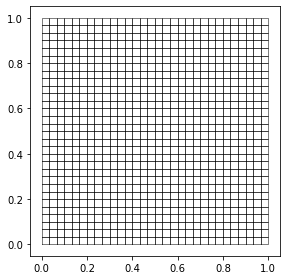

In [6]:
# Show mesh
fig, ax = plt.subplots()
def plotMesh(c='k',lw=0.5,ax=None):
    if ax is None:
        ax=plt
    for element in grid.elements:
        ax.plot( *zip(*[(v.x, v.y) for v in list(element.vertices)+[element.vertices[0]] ]) , color=c, linewidth=lw)
plotMesh()
ax.set_aspect("equal", "box")
fig.tight_layout()

In [7]:
dt = 25                                                     # Time step
T = 100*dt                                                  # Simulation duration
t = np.arange(0,T,dt)                                       # Time domain

In [8]:
alpha = 1.14e-04                                            # Thermal Diffusivity
sigma = 0.05                                                # Std. dev. of initial distribution
u0func = lambda x,y: np.exp(-(x-1/2)**2/sigma) * np.exp(-(y-1/2)**2/sigma)
u0 = np.array([u0func(v.x, v.y) for v in grid.vertices])    # Initial temperature distribution

In [9]:
points = np.array([(v.x, v.y) for v in grid.vertices])      # Array with all the vertex coordinates
xi, yi = np.mgrid[0:1:75j, 0:1:75j]                         # Array with a grid so that we can plot the distribution
interp_grid = lambda u: griddata(points, u, (xi, yi), method='cubic')        # Interpolating the field onto the grid

idxs = sorted([v.handle for v in grid.vertices if v.x==0.5],key=lambda i:grid.vertices[i].y)
yc = [grid.vertices[i].y for i in idxs]

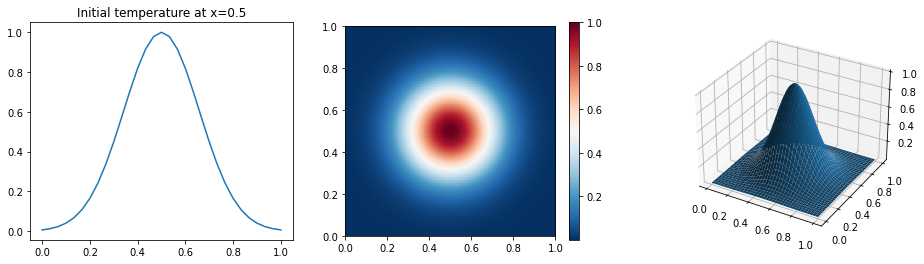

In [10]:
fig = plt.figure(figsize=(16,4))
ax = plt.subplot(1,3,1);
ax.plot(yc, u0[idxs]); ax.set_title("Initial temperature at x=0.5")
ax = plt.subplot(1,3,2);
img = ax.imshow(interp_grid(u0).T, cmap="RdBu_r", extent=(0,1,0,1), origin='lower');
# plotMesh('w',0.1)
plt.colorbar(img)
ax = plt.subplot(1,3,3,projection="3d");
ax.plot_surface(xi,yi,interp_grid(u0).T);

In [11]:
M = np.zeros((N,N))
# du/dt                                                     # This for loop implements the first term in our discretized eqn.
for vertex in grid.vertices:
    # 𝛥𝛺i/𝛥t
    M[vertex.handle][vertex.handle] += vertex.volume / dt
for element in grid.elements:                               # Loop over the elements so that we can apply the shape fncs.
    # 𝛼∇²u                                                 # This for loop implements the second term in our discretized eqn.
    for innerFace in element.innerFaces:
        area = innerFace.area.getCoordinates()[:dimension]  # 𝛥s
        # 𝛼 𝛥s.T G
        matrixCoefficients = -alpha * np.matmul( area.T, innerFace.globalDerivatives )
        # We're applying the equations to each inner face, however, each inner face divides two control
        # volumes, that's why we call the backward and forward. Also, since we're applying a dot product
        # the area vector points away from the backward vertex, and towards the forward vertex, and thus
        # we have to invert the sign of the terms when adding to the forward vertex.
        backwardHandle, forwardHandle = innerFace.getNeighborVerticesHandles()
        # local indicates the local index of each vertex in the element. That's because when calculating
        # the operator G = innerFace.globalDerivatives, we index each vertex using local.
        # Each row of the matrix corresponds
        for local, vertex in enumerate(element.vertices):
            M[backwardHandle][vertex.handle] += matrixCoefficients[local]
            M[forwardHandle][vertex.handle] -= matrixCoefficients[local]

# Dirichlet Boundary Conditions
for boundary in grid.boundaries:
    for vertex in boundary.vertices:
        M[vertex.handle] = np.zeros(N)
        M[vertex.handle][vertex.handle] = 1.0

M_1 = np.linalg.inv(M)

In [12]:
# Assembly of the independent term
def ind(u_old):
    ind = u_old.copy()
    for vertex in grid.vertices:
        ind[vertex.handle] *= vertex.volume / dt # 𝛥𝛺i/𝛥t
    for boundary in grid.boundaries:
        for vertex in boundary.vertices:
            ind[vertex.handle] = 0
    return ind

In [13]:
# Solving the problem
U_fv = np.array([u0]).T
for _t in t[1:]:
    u = M_1 @ ind(U_fv.T[-1])
    U_fv = np.stack((*U_fv.T,u)).T
U_fv0 = U_fv.copy()

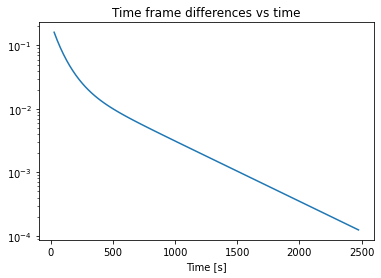

In [14]:
plt.title("Time frame differences vs time")
plt.xlabel("Time [s]")
plt.semilogy(t[1:], np.max(np.abs(U_fv[:,1:]-U_fv[:,:-1]),axis=0));

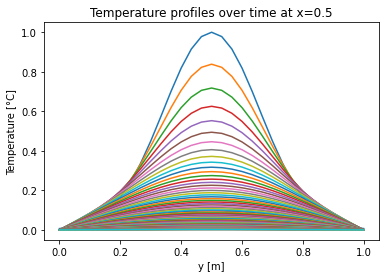

In [15]:
plt.title("Temperature profiles over time at x=0.5")
plt.ylabel("Temperature [°C]"); plt.xlabel("y [m]")
plt.plot(yc, U_fv[idxs]);

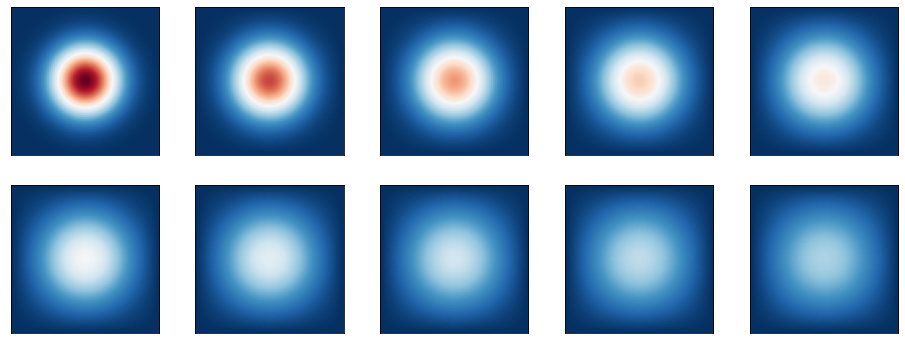

In [16]:
vmin, vmax = np.min(U_fv[:,:10]), np.max(U_fv[:,:10])
plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(interp_grid(U_fv[:,i]).T, vmin=vmin, vmax=vmax, cmap="RdBu_r", extent=(0,1,0,1), origin='lower')
    plt.xticks([]); plt.yticks([])

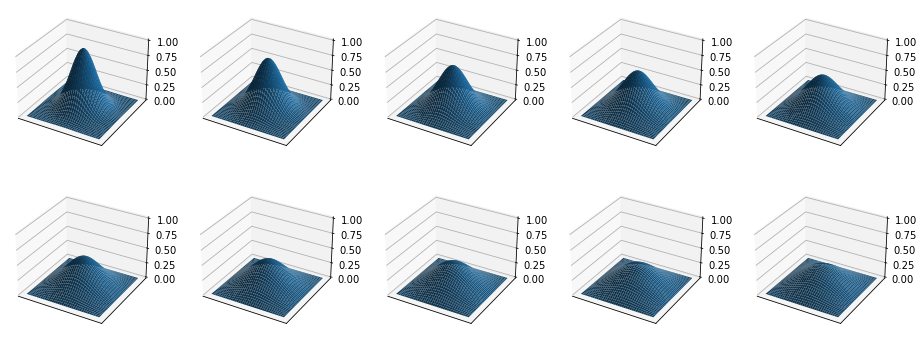

In [17]:
plt.figure(figsize=(16,6))
for i in range(10):
    ax = plt.subplot(2,5,i+1,projection='3d')
    ax.plot_surface(xi,yi,interp_grid(U_fv[:,i]).T);
    ax.set_zlim(0,np.max(U_fv))
    plt.xticks([]); plt.yticks([]);

In [18]:
os.remove(fileName)

### Computing a Laplacian Kernel

Since we already know how to compute the gradient of a field using shape functions, we'll compute the laplacian of a field using the divergence theorem
$$\nabla^2 u = \nabla \cdot \nabla u = \mathrm{div}( \mathrm{grad}(u) )\\
\iiint \limits_{\Omega_i} \nabla^2 u\ d\Omega_i = 
\iiint \limits_{\Omega_i} \nabla \cdot \nabla u\ d\Omega_i = 
\iint \limits_{\Gamma_i} \nabla u \cdot \mathbf{\hat{n}}\ d\Gamma_i \\
\boxed{\nabla^2 u_i \approx \frac{1}{\Delta\Omega_i} \sum\limits_{e \in \mathbb{E}_i} \sum\limits_{f \in \Gamma^e} \Delta \mathbf{s}_f^T \mathbf{G}_{\dot{f}} \mathbf{\hat{u}}^e}
$$

In [19]:
# Analytical laplacian
import sympy as smp
x_smp, y_smp, sigma_smp = smp.symbols("x y \sigma"); half_smp = smp.Rational(1,2)
u0_smp = smp.exp(-( (x_smp-half_smp)**2 + (y_smp-half_smp)**2 )/sigma_smp)
Lu0_smp = smp.diff(smp.diff(u0_smp,x_smp),x_smp) + smp.diff(smp.diff(u0_smp,y_smp),y_smp)
Lu0_smp = Lu0_smp.subs(sigma_smp,sigma)
Lu0_func = smp.lambdify((x_smp, y_smp),Lu0_smp)

In [20]:
L = np.zeros((N,N))
for element in grid.elements:
    for innerFace in element.innerFaces:
        area = innerFace.area.getCoordinates()[:dimension]
        coefficients = area @ innerFace.globalDerivatives
        
        backwardHandle, forwardHandle = innerFace.getNeighborVerticesHandles()
        for local, elementVertex in enumerate(element.vertices):
            L[backwardHandle][elementVertex.handle] += coefficients[local]
            L[forwardHandle][elementVertex.handle] -= coefficients[local]
for vertex in grid.vertices:
    L[vertex.handle] /= vertex.volume

In [21]:
Lu0_fv = L @ u0
Lu0_a  = np.array([Lu0_func(v.x,v.y) for v in grid.vertices])

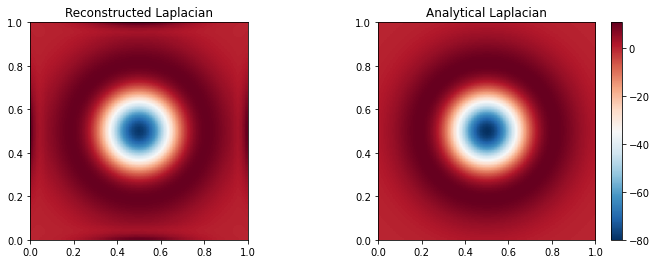

In [22]:
vmin,vmax = np.min([Lu0_fv,Lu0_a]), np.max([Lu0_fv,Lu0_a])
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].set_title("Reconstructed Laplacian")
axs[0].imshow(interp_grid(Lu0_fv).T, vmin=vmin, vmax=vmax, cmap="RdBu_r", extent=(0,1,0,1), origin='lower')
# plotMesh('w',0.1,axs[0])
axs[1].set_title("Analytical Laplacian")
img = axs[1].imshow(interp_grid(Lu0_a).T, vmin=vmin, vmax=vmax, cmap="RdBu_r", extent=(0,1,0,1), origin='lower');
plt.colorbar(img);

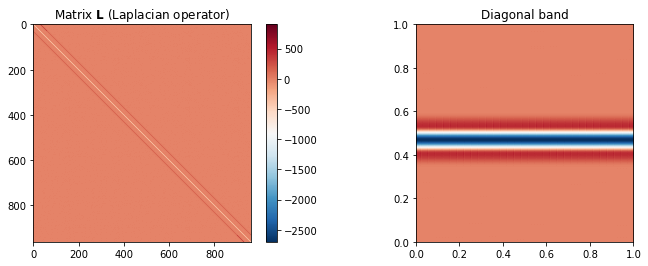

In [23]:
diagBandL = []
bw = 8
for i,col in enumerate(L.T[bw:-bw],bw):
  diagBandL.append(col[i-bw:i+bw])
diagBandL = np.transpose(diagBandL)

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].set_title(r"Matrix $\mathbf{L}$ (Laplacian operator)")
img = axs[0].imshow(L,cmap="RdBu_r")
axs[1].set_title(r"Diagonal band")
axs[1].imshow(diagBandL,cmap="RdBu_r",extent=(0,1,0,1))
plt.colorbar(img,ax=axs[0]);

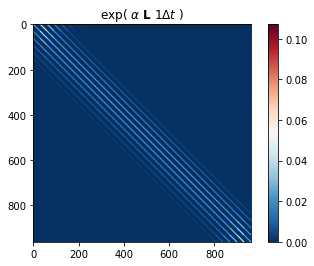

In [24]:
# The reason we're plotting the matrix expm(alpha*L*dt*_n) is because the solution for the problem
# _n steps after u0 depends on it. The main purpose is to analyze if the values are too high such that
# it'll diverge. More specifically, we're hoping to see values << 1.
_n = 1
A = expm(alpha*L*dt*_n)
plt.title(r"$\exp(\ \alpha\ \mathbf{L}\ %s \Delta t\ )$" % _n)
plt.imshow(A,cmap="RdBu_r")
plt.colorbar();

In [25]:
loc = (0.5,0.8)
vtx = min(grid.vertices, key=lambda v: (v.x-loc[0])**2+(v.y-loc[1])**2)
Lu0_fv[vtx.handle], Lu0_a[vtx.handle]

(10.326528094121443, 10.579128846181536)

### Computing a first derivative Kernel

We'll compute the first derivative in the same way we computed the laplacian
$$\partial _{x} u=\nabla \cdotp \begin{bmatrix}
u\\
0
\end{bmatrix}\\
\iiint\limits _{\Omega _{i}} \partial _{x} u\ d\Omega _{i} =\iint\limits _{\Gamma _{i}}\begin{bmatrix}
u\\
0
\end{bmatrix} \cdotp \begin{bmatrix}
\hat{n}_{x}\\
\hat{n}_{y}
\end{bmatrix} \ d\Gamma _{i}\\
\partial _{x} u\ \Delta \Omega _{i} \approx \sum _{e\in \mathbb{E}_{i}}\sum _{f\in \Gamma _{i}^{e}} u_{\dot{f}} \Delta s_{x}\\
\boxed{\partial _{x} u\approx \frac{1}{\Delta \Omega _{i}}\sum _{e\in \mathbb{E}_{i}}\sum _{f\in \Gamma _{i}^{e}}\mathbf{N}_{\dot{f}}\hat{\mathbf{u}}^{e} \Delta s_{x}}
$$
Where
$$\mathbf{N}_{\mathfrak{r}} =\begin{bmatrix}
\mathcal{N}_{1}(\mathfrak{r}) & \mathcal{N}_{1}(\mathfrak{r}) & \dotsc  & \mathcal{N}_{N}(\mathfrak{r})
\end{bmatrix}$$

In [26]:
# Analytical first derivative
u0x_smp = smp.diff(u0_smp,x_smp)
u0x_smp = u0x_smp.subs(sigma_smp,sigma)
u0x_func = smp.lambdify((x_smp, y_smp),u0x_smp)

In [27]:
F = np.zeros((N,N))
for element in grid.elements:
    for innerFace in element.innerFaces:
        area_x = innerFace.area.x
        coefficients = area_x * innerFace.getShapeFunctions()
        
        backwardHandle, forwardHandle = innerFace.getNeighborVerticesHandles()
        for local, elementVertex in enumerate(element.vertices):
            F[backwardHandle][elementVertex.handle] += coefficients[local]
            F[forwardHandle][elementVertex.handle] -= coefficients[local]
for vertex in grid.vertices:
    F[vertex.handle] /= vertex.volume

In [28]:
u0x_fv = F @ u0
u0x_a  = np.array([u0x_func(v.x,v.y) for v in grid.vertices])

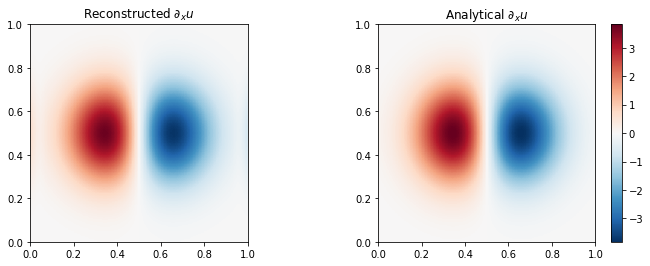

In [29]:
vmin,vmax = np.min([u0x_fv,u0x_a]), np.max([u0x_fv,u0x_a])
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].set_title("Reconstructed $\partial_x u$")
axs[0].imshow(interp_grid(u0x_fv).T, vmin=vmin, vmax=vmax, cmap="RdBu_r", extent=(0,1,0,1), origin='lower')
axs[1].set_title("Analytical $\partial_x u$")
img = axs[1].imshow(interp_grid(u0x_a).T, vmin=vmin, vmax=vmax, cmap="RdBu_r", extent=(0,1,0,1), origin='lower');
plt.colorbar(img);

In [30]:
loc = (0.3,0.5)
vtx = min(grid.vertices, key=lambda v: (v.x-loc[0])**2+(v.y-loc[1])**2)
u0x_fv[vtx.handle], u0x_a[vtx.handle]

(3.5379015653707127, 3.594631712937772)

## Analytical Solution Validation
Since we are trying to validate a numerical method that depends on another, it's important to validate each step in order to guarantee the validity of our solution

In the previous notebook we derived the equation
$$u_t = \alpha \nabla^2 u$$
Which in two dimensions is written as 
$$u_t = \alpha u_{xx} + \alpha u_{yy}$$
And just as before we solved it analytically by making use of the separation of variables, we'll do it again, by stating that
$$u(x,y,t) = \psi(x) \phi(y) a(t)$$
The boundary conditions will be
$$\cases{ u(0,y,t) = u(w,y,t) = 0\\ u(x,0,t) = u(x,h,t) = 0}$$
For a rectangular domain with width $w$ and height $h$.
The initial condition is given by the function
$$u(x,y,0) = f(x,y)$$

Substituting the separation of variables into the differential equation, and dividing both sides by $\psi(x)\phi(y)a(t)$ we get
$$\frac{a_{t}( t)}{a( t)} =\alpha \frac{\psi _{xx}( x)}{\psi ( x)} +\alpha \frac{\phi _{yy}( y)}{\phi ( y)}$$

If we isolate the terms that are function of $x$, we'll have a function of $x$ equals to another function of $(y,t)$, which is true for all $(x,y,t)$, which means that both sides of the equation are constants
$$\frac{\psi _{xx}( x)}{\psi ( x)} =\frac{1}{\alpha }\frac{a_{t}( t)}{a( t)} -\frac{\phi _{yy}( y)}{\phi ( y)} =-\mu ^{2}$$

We can do the same thing isolating $y$ in the new equation
$$\frac{\phi _{yy}( y)}{\phi ( y)} =\frac{1}{\alpha }\frac{a_{t}( t)}{a( t)} +\mu ^{2} =-\nu ^{2}$$

And that way we arrive at three uncoupled ODEs
$$\cases{
\psi_{xx}(x)+\mu ^{2} \psi(x)=0\\
\phi_{yy}(y)+\nu ^{2} \phi(y) =0\\
a_t(t)+\lambda a(t) = 0
}$$

Where $\lambda = \alpha ( \mu^2 + \nu^2)$. These three equations can be easily solved using standard procedures, and if we apply the boundary conditions of the initial problem to the new functions we get the boundary conditions
$$\cases{ \psi (0) = \psi (w) = 0 \\ \phi (0) = \phi (h) = 0 }$$

Now we can finally solve the ODEs. The spatial equations have solution
$$\begin{array}{ c c c }
\psi _{m}( x) =c_1\sin( \mu_m x) , & \mu_m =\displaystyle{\frac{m\pi}{w}} , & m\in \mathbb{N}\\
\phi _{n}( y) =c_2\sin( \nu_n y) , & \nu_n =\displaystyle{\frac{n\pi}{h}} , & n\in \mathbb{N}
\end{array}$$
And $a(t)$ has the solution
$$a_{mn}( t) =c_3\exp(-\lambda _{mn} t)$$

Substituting in the original separation of variables equation, and since the general solution is the linear combination of all possible different solutions, the general solution is given by
$$\boxed{u( x,y,t) =\sum _{m=1}^{\infty }\sum _{n=1}^{\infty } C_{mn}\sin( \mu _{m} x) \sin( \nu _{n} y) \ e^{-\lambda _{mn} t}}$$

And we now can use the initial condition to find $C_{mn}$.
$$f( x,y) =\sum _{m=1}^{\infty }\sum _{n=1}^{\infty } C_{mn}\sin( \mu _{m} x) \sin( \nu _{n} y)$$

For that, we'll define the $x$ and $y$ internal products in our domain
$$\begin{array}{ c c|c c }
\left<\ g_{1}( x) ,\ g_{2}( x)\ \right> _{x} = \displaystyle{\int\limits _{0}^{w} g_{1}( x) g_{2}^{*}( x) dx} &  &  & 
\left<\ g_{3}( y) ,\ g_{4}( y)\ \right> _{y} = \displaystyle{\int\limits _{0}^{h} g_{3}( y) g_{4}^{*}( y) dy}
\end{array}$$

Since the sine function is orthogonal, we'll take the $x$ internal product from both sides of the equation with a modal sine function and then do the same in the $y$ direction.

$$\left< \sin\left(\tfrac{i\pi }{w} x\right) ,f( x,y)\right> _{x} =\sum _{m=1}^{\infty }\sum _{n=1}^{\infty } C_{mn}\left< \sin\left(\tfrac{i\pi }{w} x\right) ,\sin\left(\tfrac{m\pi }{w} x\right)\right> _{x} \ \sin\left(\tfrac{n\pi }{h} y\right)$$

Where $i$ isn't the imaginary unit, it is just an index. And since
$$
\left< \sin\left(\tfrac{i\pi }{w} x\right) ,\sin\left(\tfrac{m\pi }{w} x\right)\right> _{x} =\begin{cases}
0 & \text{if} \ i\neq m\\
\tfrac{w}{2} & \text{if} \ i=m
\end{cases}$$

Then
$$\left< \sin\left(\tfrac{i\pi }{w} x\right) ,f( x,y)\right> _{x} =\sum _{n=1}^{\infty } C_{in}\tfrac{w}{2}\sin\left(\tfrac{n\pi }{h} y\right)$$

And doing the same thing in the $y$ direction we got
$$\left< \sin\left(\tfrac{j\pi }{h} y\right) ,\left< \sin\left(\tfrac{i\pi }{w} x\right) ,f( x,y)\right> _{x}\right> _{y} =\sum _{n=1}^{\infty } C_{in}\tfrac{w}{2}\left< \sin\left(\tfrac{j\pi }{h} y\right) ,\sin\left(\tfrac{n\pi }{h} y\right)\right>_y \\
\boxed{C_{jk} =\frac{4}{wh}\int\limits _{0}^{w}\int\limits _{0}^{h} f( x,y)\sin\left(\tfrac{i\pi }{w} x\right)\sin\left(\tfrac{j\pi }{h} y\right) dy\ dx}$$

In [31]:
from scipy.integrate import dblquad                            # Used for numerical integration

In [32]:
# Dimensions of the domain
w,h = 1,1
# Number of sines (x and y)
Nc = 10
# That's the integrant of the double intergal in the C_ij definition
integrand = lambda i,j: (lambda y,x: u0func(x,y) * np.sin(i*np.pi*x/w) * np.sin(j*np.pi*y/h))
# The definition of C_ij, but in function format
Cij_func = lambda i,j: (4/(w*h)) * dblquad(integrand(i,j), 0, w, 0, h)[0]
# 2D array with all C_mn for all m,n ∈ N ∩ (0,Nc)
Cmn = [[Cij_func(m,n) for n in range(Nc)] for m in range(Nc)]
# 𝜆_mn function
l_func = lambda m,n: alpha * ((m*np.pi/w)**2 + (n*np.pi/h)**2)
# 𝜆_mn 2D array
l = [[l_func(m,n) for n in range(Nc)] for m in range(Nc)]

In [33]:
# Vertex Coordinates
Xv, Yv = zip(*[(v.x, v.y) for v in grid.vertices]); Xv, Yv = np.array(Xv), np.array(Yv)
# Analytical solution (profiles in the columns)
U_a = np.transpose([np.sum([[Cmn[m][n] * np.sin(m*np.pi*Xv/w) * np.sin(n*np.pi*Yv/h) * np.exp(-l[m][n] * _t) for n in range(Nc)] for m in range(Nc)], axis=(0,1)) for _t in t])

In [34]:
LU_a = ( np.transpose([np.sum([[-((m*np.pi/w)**2) * Cmn[m][n] * np.sin(m*np.pi*Xv/w) * np.sin(n*np.pi*Yv/h) * np.exp(-l[m][n] * _t) for n in range(Nc)] for m in range(Nc)], axis=(0,1)) for _t in t])
       + np.transpose([np.sum([[-((n*np.pi/h)**2) * Cmn[m][n] * np.sin(m*np.pi*Xv/w) * np.sin(n*np.pi*Yv/h) * np.exp(-l[m][n] * _t) for n in range(Nc)] for m in range(Nc)], axis=(0,1)) for _t in t]) )
Ut_a = np.transpose([np.sum([[-l[m][n] * Cmn[m][n] * np.sin(m*np.pi*Xv/w) * np.sin(n*np.pi*Yv/h) * np.exp(-l[m][n] * _t) for n in range(Nc)] for m in range(Nc)], axis=(0,1)) for _t in t])

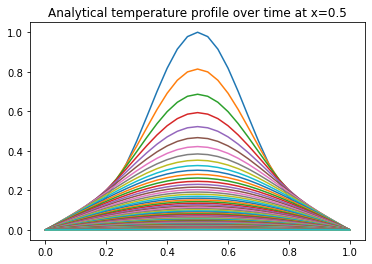

In [35]:
plt.title("Analytical temperature profile over time at x=0.5")
plt.plot(yc, U_a[idxs]);

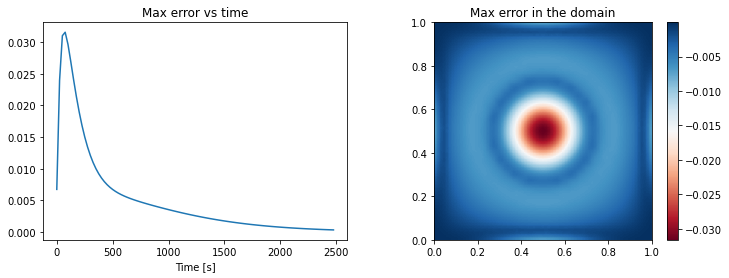

In [36]:
error_fv = np.abs(U_fv - U_a)
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].set_title("Max error vs time"); axs[0].set_xlabel("Time [s]")
axs[0].plot(t, np.max(error_fv,axis=0))
axs[1].set_title("Max error in the domain")
img = axs[1].imshow(-interp_grid(np.max(error_fv,axis=1)).T, cmap="RdBu", extent=(0,1,0,1), origin='lower');
plt.colorbar(img)

## POD / SVD Decompositions
In this section we are going to perform the Proper Orthogonal Decomposition / Singular Value Decomposition in order to extract the most relevant basis modes for our problem, in an attempt to generalize to other problems


In [37]:
U, s, Vt = np.linalg.svd(U_fv); U,Vt = -U,-Vt

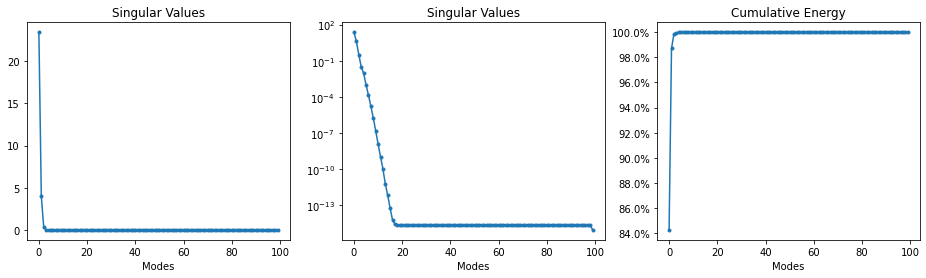

In [38]:
# Figure 04 - Singular Values Plot
fig,axs = plt.subplots(1,3,figsize=(16,4))
axs[0].set_title("Singular Values"); axs[0].plot(s,'.-'); axs[0].set_xlabel("Modes")
axs[1].set_title("Singular Values"); axs[1].semilogy(s,'.-'); axs[1].set_xlabel("Modes")
axs[2].set_title("Cumulative Energy"); axs[2].plot(100*np.cumsum(s)/np.sum(s),'.-');
axs[2].yaxis.set_major_formatter(mtick.PercentFormatter()); axs[2].set_xlabel("Modes");

Which shows how helpful the POD can be when solving PDEs. This problem is analogous to the 1D problem solved before, with a gaussian field as initial condition and dirichlet boundary conditions. However now we're solving for way more degrees of freedom, and we're still getting a super low rank decomposition. This way, because we know the physics have 'low rank structures', instead of simulating $m$ time steps of a simulation with a mesh containing $n$ nodes, we could simulate just a few time steps with a super refined mesh, and then use the POD to continue the behaviour, in such a way that when we join the dynamics with the spatial modes we have way more refined results.

In [39]:
for i in range(4):
    print(f"The first {i+1} modes carry {np.cumsum(s)[i]/np.sum(s):>7.3%} of the energy / variance")

The first 1 modes carry 84.256% of the energy / variance
The first 2 modes carry 98.706% of the energy / variance
The first 3 modes carry 99.850% of the energy / variance
The first 4 modes carry 99.962% of the energy / variance


In [40]:
r = 4
Psi = U[:,:r]
A_fv = Psi.T @ U_fv

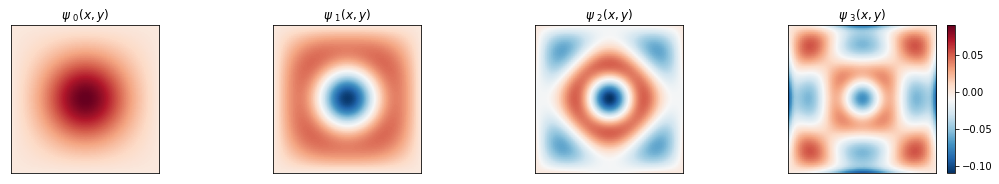

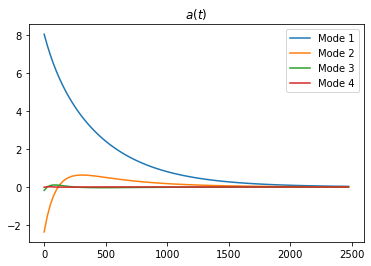

In [41]:
vmin, vmax = np.min(Psi), np.max(Psi)
plt.figure(figsize=(18,6))
for i in range(r):
    plt.subplot(2,4,i+1)
    plt.title(f"$\psi\ _{i}(x,y)$")
    img = plt.imshow(interp_grid(Psi[:,i]).T, vmin=vmin, vmax=vmax, cmap="RdBu_r", extent=(0,1,0,1), origin='lower')
    plt.xticks([]); plt.yticks([])
plt.colorbar(img)

plt.figure()
plt.title(r"$a(t)$")
plt.plot(t,A_fv.T)
plt.legend(list(map(lambda n:f"Mode {n}",range(1,r+1))));

In [42]:
At_fv = np.array([np.gradient(a,t) for a in A_fv])
LPsi = L @ Psi

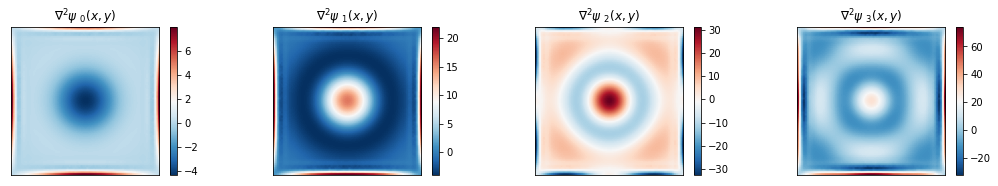

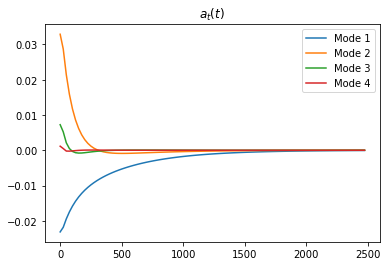

In [43]:
vmin, vmax = np.min(LPsi), np.max(LPsi)
plt.figure(figsize=(18,6))
for i in range(r):
    plt.subplot(2,4,i+1)
    plt.title(f"$\\nabla^2 \psi\ _{i}(x,y)$")
    img = plt.imshow(interp_grid(LPsi[:,i]).T, cmap="RdBu_r", extent=(0,1,0,1), origin='lower')
    plt.xticks([]); plt.yticks([])
    plt.colorbar(img)

plt.figure()
plt.title(r"$a_t(t)$")
plt.plot(t,At_fv.T)
plt.legend(list(map(lambda n:f"Mode {n}",range(1,r+1))));

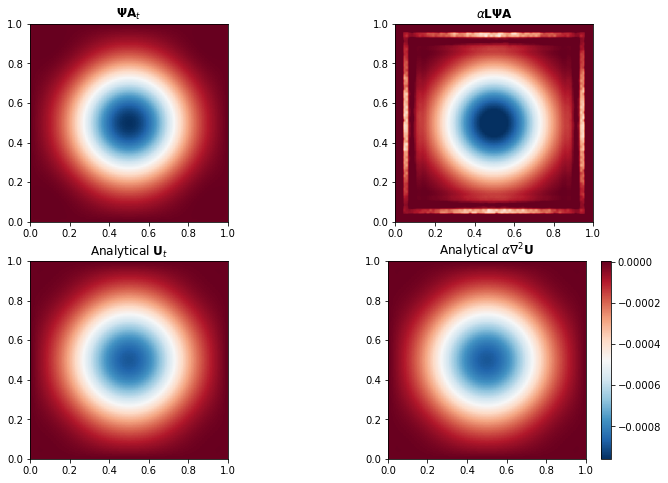

In [44]:
_ti = 10
_psi_at = (Psi @ At_fv)[:,_ti]
_a_L_psi_A = (alpha * LPsi @ A_fv)[:,_ti]
# vmin,vmax = np.min([_psi_at,_a_L_psi_A,Ut_a[:,_ti],alpha*LU_a[:,_ti]]), np.max([_psi_at,_a_L_psi_A,Ut_a[:,_ti],alpha*LU_a[:,_ti]])
vmin,vmax = np.min([_psi_at,Ut_a[:,_ti],alpha*LU_a[:,_ti]]), np.max([_psi_at,Ut_a[:,_ti],alpha*LU_a[:,_ti]])
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0][0].set_title(r"$\mathbf{\Psi A}_t$")
axs[0][0].imshow(interp_grid(_psi_at).T, cmap="RdBu_r", extent=(0,1,0,1), origin='lower', vmin=vmin, vmax=vmax)

axs[0][1].set_title(r"$\alpha \mathbf{L\Psi A}$")
img = axs[0][1].imshow(interp_grid(_a_L_psi_A).T, cmap="RdBu_r", extent=(0,1,0,1), origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar(img)

axs[1][0].set_title(r"Analytical $\mathbf{U}_t$")
axs[1][0].imshow(interp_grid(Ut_a[:,_ti]).T, cmap="RdBu_r", extent=(0,1,0,1), origin='lower', vmin=vmin, vmax=vmax)

axs[1][1].set_title(r"Analytical $\alpha \nabla^2\mathbf{U}$")
axs[1][1].imshow(interp_grid(alpha*LU_a[:,_ti]).T, cmap="RdBu_r", extent=(0,1,0,1), origin='lower', vmin=vmin, vmax=vmax)

del _psi_at, _a_L_psi_A

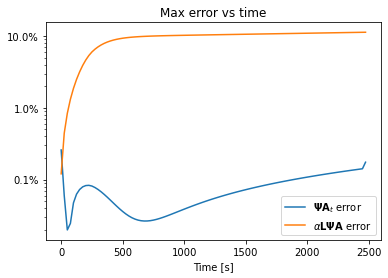

In [45]:
rng = np.max(Ut_a,axis=0) - np.min(Ut_a,axis=0)
Ut_fv_err = np.max(np.abs(Psi @ At_fv - Ut_a),axis=0) / rng
aLU_fv_err = np.max(np.abs(alpha * LPsi @ A_fv - Ut_a),axis=0) / rng

ax = plt.axes()
plt.title("Max error vs time")
plt.xlabel("Time [s]");
plt.semilogy(t, Ut_fv_err, label=r"$\mathbf{\Psi A}_t$ error")
plt.semilogy(t, aLU_fv_err, label=r"$\alpha \mathbf{L\Psi A}$ error")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend();

## ROM Solution of the same problem
Although the main goal of the ROMs isn't to solve the same problem they're based on, this step can be important while validating our model

In this section we are going to solve the problem using our tailored basis that we got applying the SVD on the EbFVM solution. Since some modes were looking kind of noisy, especially their laplacian, we are also going to use a fourier basis, since it shows up naturally in the analytical solution (which is kind of cheating considering that we are using the anlytical solution to make decisions on our ROM solution, but not really, since the Fourier basis is such a common one).

### Solution using tailored basis (SVD)

The dynamics of our problem is governed by the equation
$$u_t = \alpha \nabla^2 u$$
Which can be expressed in our spatially discretized matrix form as
$$\mathbf{a}_t(t) = \alpha \Psi^T L \Psi \mathbf{a}(t)$$
And although we could use an odeint solver, we will take advantage of the fact that the problem is super linear and simple and go ahead and express the solution as
$$\mathbf{a}(t) = \exp(\alpha \Psi^T L \Psi t) \mathbf{a}(0)$$
In the future we'll solve more complex systems, but for the time we'll stick with this method.

In [46]:
r = 100
Psi = U[:,:r]
A_fv = Psi.T @ U_fv
At_fv = np.array([np.gradient(a,t) for a in A_fv])
LPsi = L @ Psi

In [47]:
a0 = Psi.T @ u0
A_rom = np.array([a0]).T
Lm = alpha * Psi.T @ LPsi
d, T = np.linalg.eig(Lm); T_1 = np.linalg.inv(T); b0 = T_1 @ a0
for _t in t[1:]:
    A_rom = np.stack([*A_rom.T, T @ np.diag(np.exp(d*_t)) @ b0]).T

In [48]:
U_rom = np.real(Psi @ A_rom)

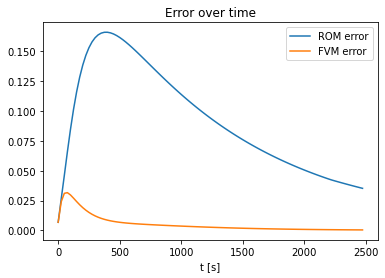

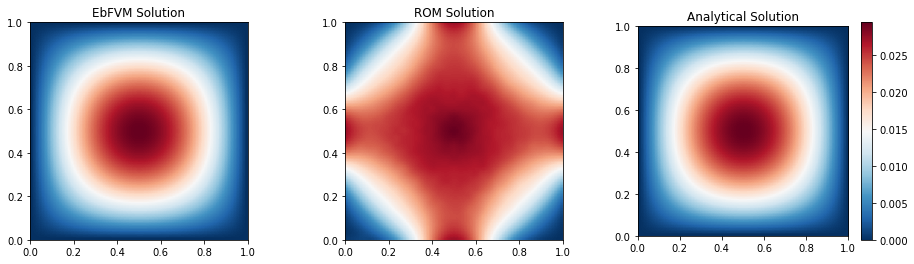

In [49]:
_ti = 50
rom_err = [np.max(np.abs(ua-urom)) for ua,urom in zip(U_a.T, U_rom.T)]
fv_err = [np.max(np.abs(ua-ufv)) for ua,ufv in zip(U_a.T, U_fv.T)]
plt.title("Error over time")
plt.plot(t, rom_err, label="ROM error")
plt.plot(t, fv_err, label="FVM error")
plt.xlabel("t [s]");
plt.legend();

fig, axs = plt.subplots(1,3,figsize=(16,4))
axs[0].set_title("EbFVM Solution")
axs[0].imshow(interp_grid(U_fv[:,_ti]).T, cmap="RdBu_r", extent=(0,1,0,1), origin='lower');
axs[1].set_title("ROM Solution")
axs[1].imshow(interp_grid(U_rom[:,_ti]).T, cmap="RdBu_r", extent=(0,1,0,1), origin='lower');
axs[2].set_title("Analytical Solution")
img = axs[2].imshow(interp_grid(U_a[:,_ti]).T, cmap="RdBu_r", extent=(0,1,0,1), origin='lower');
plt.colorbar(img);